#ligo-data-pipeline

##RUN FIRST

In [ ]:
!pip install gwpy
!pip install gwosc
!pip install h5py

##RUN: WORKING PIPELINE

Available detectors: ['H1', 'L1']

H1 data shape: (131072,)
H1 sample rate: 4096.0

L1 data shape: (131072,)
L1 sample rate: 4096.0


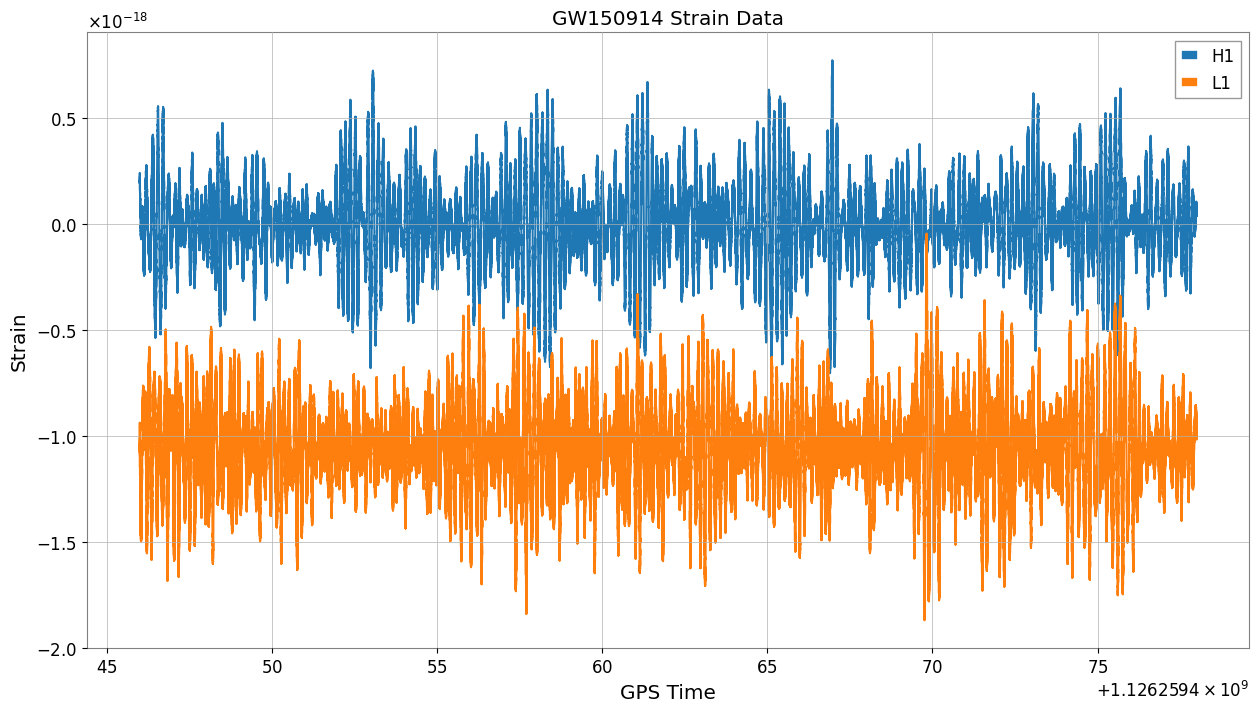

In [ ]:
import requests
import numpy as np
import h5py
from gwpy.timeseries import TimeSeries
from gwosc.locate import get_urls
from gwosc import datasets

class LIGODataPipeline:
    def __init__(self):
        self.base_url = "https://www.gw-openscience.org/archive/data"
        self.events = {
            'GW150914': 1126259462,  # GPS time
            'GW170814': 1186741861,
            'GW170104': 1167559936
        }

    def fetch_event_data(self, event_name, duration=32):
        """
        Fetch data for a specific event
        duration: seconds of data to fetch (centered on event)
        """
        if event_name not in self.events:
            raise ValueError(f"Unknown event: {event_name}")

        gps_time = self.events[event_name]
        start_time = gps_time - duration//2
        end_time = gps_time + duration//2

        data = {}
        for detector in ['H1', 'L1']:  # Hanford and Livingston
            try:
                # Fetch strain data directly using TimeSeries
                strain = TimeSeries.fetch_open_data(
                    detector,
                    start_time,
                    end_time,
                    cache=True
                )
                data[detector] = {
                    'strain': strain.value,
                    'time': strain.times.value,
                    'sample_rate': strain.sample_rate.value
                }
            except Exception as e:
                print(f"Error fetching {detector} data: {e}")

        return data

    def get_available_events(self):
        """List all available events"""
        return datasets.find_datasets(catalog='GWTC-1')

    def get_event_metadata(self, event_name):
        """Fetch metadata for specific event"""
        try:
            return datasets.event_metadata(event_name)
        except Exception as e:
            print(f"Error fetching metadata: {e}")
            return None

# Test the pipeline
pipeline = LIGODataPipeline()
data = pipeline.fetch_event_data('GW150914')

# Quick sanity check
print("Available detectors:", list(data.keys()))
for detector in data:
    print(f"\n{detector} data shape:", data[detector]['strain'].shape)
    print(f"{detector} sample rate:", data[detector]['sample_rate'])

# Let's also plot the strain data to make sure it looks right
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for detector in data:
    plt.plot(data[detector]['time'], data[detector]['strain'], label=detector)
plt.legend()
plt.title('GW150914 Strain Data')
plt.xlabel('GPS Time')
plt.ylabel('Strain')
plt.grid(True)
plt.show()

#Wave Analyzer

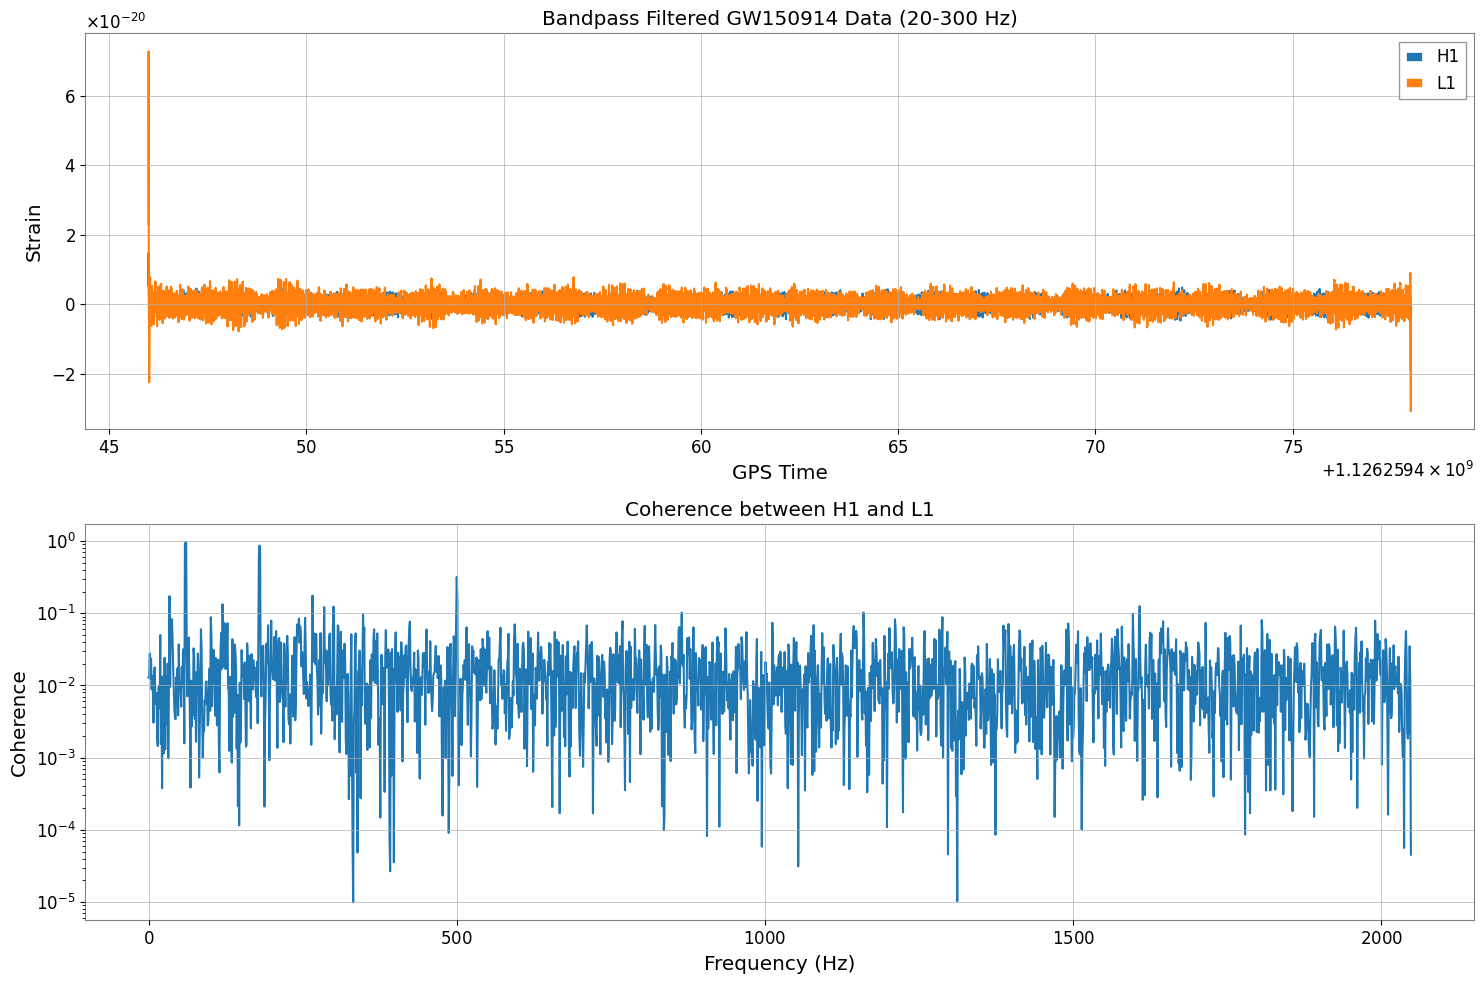

In [ ]:
import scipy.signal as signal

class WaveAnalyzer:
    def __init__(self, data, sample_rate=4096):
        self.data = data
        self.sample_rate = sample_rate

    def bandpass_filter(self, lowcut=20, highcut=300):
        """Apply bandpass filter to focus on GW frequency range"""
        nyquist = self.sample_rate / 2
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(4, [low, high], btype='band')

        filtered_data = {}
        for detector in self.data:
            filtered_data[detector] = {
                'strain': signal.filtfilt(b, a, self.data[detector]['strain']),
                'time': self.data[detector]['time'],
                'sample_rate': self.data[detector]['sample_rate']
            }
        return filtered_data

    def compute_coherence(self, segment_length=4096):
        """Compute coherence between H1 and L1"""
        if 'H1' not in self.data or 'L1' not in self.data:
            return None

        f, coh = signal.coherence(
            self.data['H1']['strain'],
            self.data['L1']['strain'],
            fs=self.sample_rate,
            nperseg=segment_length
        )
        return f, coh

    def whitening_filter(self, detector):
        """Whiten the data to enhance signal visibility"""
        strain = self.data[detector]['strain']
        # Compute PSD
        f, psd = signal.welch(strain, fs=self.sample_rate, nperseg=4096)
        # Create whitening filter
        white_filter = 1. / np.sqrt(psd)
        # Apply in frequency domain
        fft_data = np.fft.rfft(strain)
        white_data = fft_data * white_filter[:len(fft_data)]
        return np.fft.irfft(white_data)

# Let's use it
analyzer = WaveAnalyzer(data)
filtered_data = analyzer.bandpass_filter()

# Plot filtered data
plt.figure(figsize=(15, 10))
plt.subplot(211)
for detector in filtered_data:
    plt.plot(filtered_data[detector]['time'],
             filtered_data[detector]['strain'],
             label=detector)
plt.legend()
plt.title('Bandpass Filtered GW150914 Data (20-300 Hz)')
plt.xlabel('GPS Time')
plt.ylabel('Strain')
plt.grid(True)

# Plot coherence
plt.subplot(212)
f, coh = analyzer.compute_coherence()
plt.semilogy(f, coh)
plt.title('Coherence between H1 and L1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.grid(True)
plt.tight_layout()
plt.show()

#Memory Analyzer


Quantum Coherence Analysis:
peak_frequencies: [52. 54. 57. 60. 65. 69. 71. 73. 76. 78. 80. 85. 89. 91. 94. 99.]
peak_coherence: [0.00893994 0.01661627 0.0318045  0.96258476 0.0458489
 0.01164421 0.00545314 0.03272059 0.01564311 0.01335552
 0.02753932 0.0598177  0.00278429 0.00630423 0.01130002
 0.01732651]
mean_coherence: 0.06734274313565491
coherence_fluctuation: 0.21979905297700858


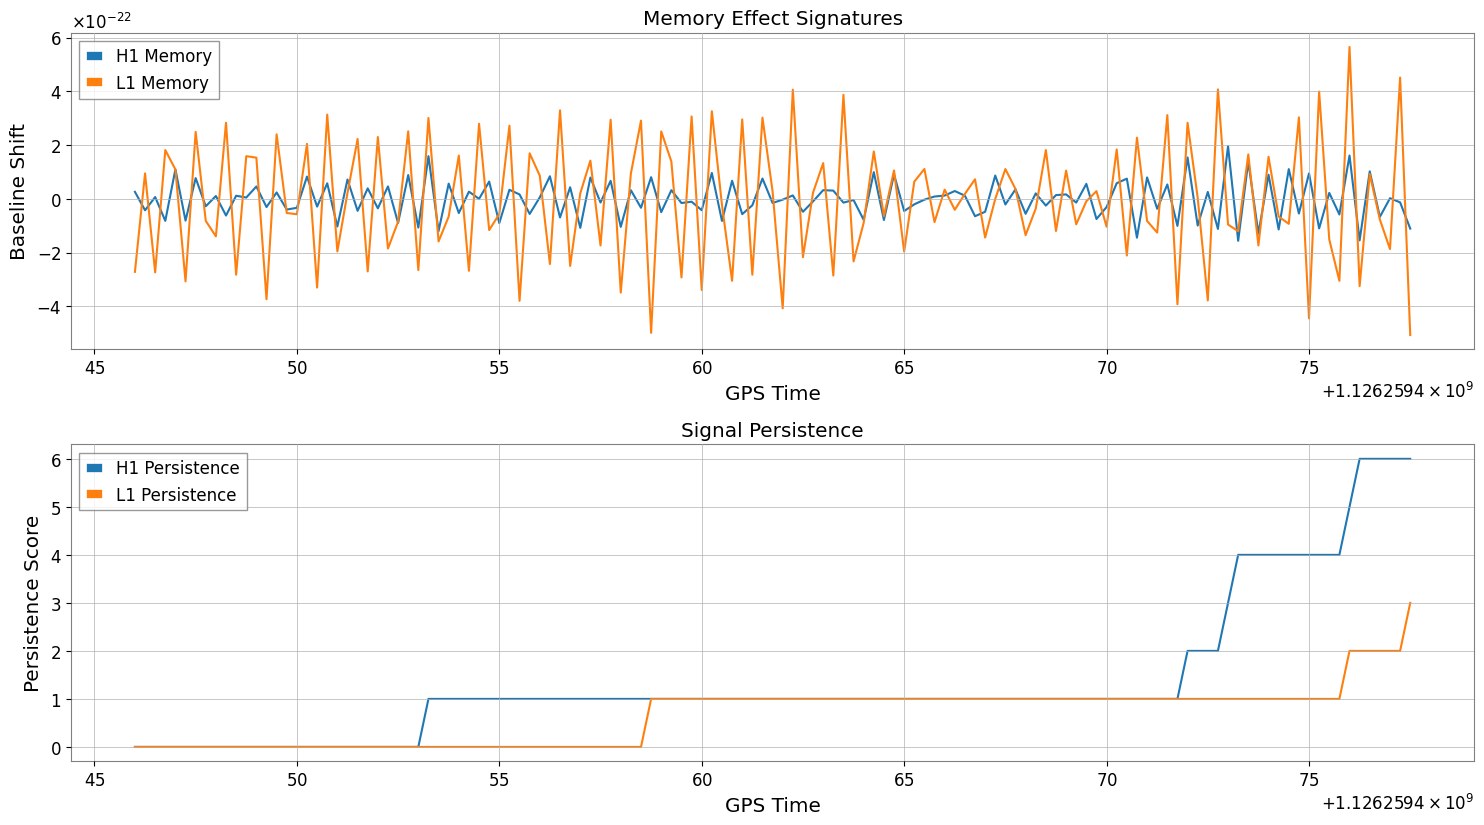

In [ ]:
class MemoryAnalyzer(WaveAnalyzer):
    def __init__(self, data, sample_rate=4096):
        super().__init__(data, sample_rate)

    def detect_memory_signature(self, window_size=1024):
        """Look for persistent changes that might indicate memory effects"""
        memory_signatures = {}

        for detector in self.data:
            strain = self.data[detector]['strain']
            # Split into windows
            n_windows = len(strain) // window_size
            windows = np.array_split(strain, n_windows)

            # Track persistent changes
            baselines = np.array([np.mean(w) for w in windows])
            changes = np.diff(baselines)

            # Compute running coherence
            memory_signatures[detector] = {
                'baseline_shifts': changes,
                'persistence': self.compute_persistence(changes),
                'window_times': self.data[detector]['time'][::window_size][:-1]
            }

        return memory_signatures

    def compute_persistence(self, changes, threshold=2):
        """Measure how long changes persist"""
        return np.cumsum(np.abs(changes) > threshold * np.std(changes))

    def analyze_quantum_coherence(self, freq_band=(50, 100)):
        """Look for quantum signatures in coherence patterns"""
        f, coh = self.compute_coherence()

        # Focus on relevant frequency band
        mask = (f >= freq_band[0]) & (f <= freq_band[1])
        band_f = f[mask]
        band_coh = coh[mask]

        # Look for characteristic patterns
        peaks = signal.find_peaks(band_coh)[0]
        peak_freqs = band_f[peaks]
        peak_coh = band_coh[peaks]

        return {
            'peak_frequencies': peak_freqs,
            'peak_coherence': peak_coh,
            'mean_coherence': np.mean(band_coh),
            'coherence_fluctuation': np.std(band_coh)
        }

# Let's analyze
memory_analyzer = MemoryAnalyzer(filtered_data)
memory_sigs = memory_analyzer.detect_memory_signature()
quantum_sigs = memory_analyzer.analyze_quantum_coherence()

# Plot results
plt.figure(figsize=(15, 12))

# Plot memory signatures
plt.subplot(311)
for detector in memory_sigs:
    plt.plot(memory_sigs[detector]['window_times'],
             memory_sigs[detector]['baseline_shifts'],
             label=f'{detector} Memory')
plt.legend()
plt.title('Memory Effect Signatures')
plt.xlabel('GPS Time')
plt.ylabel('Baseline Shift')
plt.grid(True)

# Plot persistence
plt.subplot(312)
for detector in memory_sigs:
    plt.plot(memory_sigs[detector]['window_times'],
             memory_sigs[detector]['persistence'],
             label=f'{detector} Persistence')
plt.legend()
plt.title('Signal Persistence')
plt.xlabel('GPS Time')
plt.ylabel('Persistence Score')
plt.grid(True)

# Print quantum analysis
print("\nQuantum Coherence Analysis:")
for key, value in quantum_sigs.items():
    print(f"{key}: {value}")

plt.tight_layout()
plt.show()

# Quantum Memory Analyzer

##Ignore: QMA Troubleshooting

In [ ]:
class QuantumMemoryAnalyzer(MemoryAnalyzer):
    def analyze_correlation_patterns(self):
        """Analyze correlation between memory effects and coherence"""
        # Get memory signatures
        memory_sigs = self.detect_memory_signature()

        # Focus on high-coherence time windows
        high_coh_times = []
        for detector in memory_sigs:
            shifts = memory_sigs[detector]['baseline_shifts']
            times = memory_sigs[detector]['window_times']

            # Find times of significant shifts
            sig_shifts = np.where(np.abs(shifts) > 2*np.std(shifts))[0]
            high_coh_times.extend(times[sig_shifts])

        return self.analyze_quantum_coherence_windows(high_coh_times)

    def analyze_quantum_coherence_windows(self, times, window_size=512):
        """Analyze coherence specifically during memory events"""
        coherence_stats = []

        for t in times:
            # Find data index for this time
            idx = np.searchsorted(self.data['H1']['time'], t)
            if idx + window_size > len(self.data['H1']['strain']):
                continue

            # Get data window
            h1_window = self.data['H1']['strain'][idx:idx+window_size]
            l1_window = self.data['L1']['strain'][idx:idx+window_size]

            # Compute coherence for this window
            f, coh = signal.coherence(h1_window, l1_window,
                                    fs=self.sample_rate,
                                    nperseg=window_size//4)

            coherence_stats.append({
                'time': t,
                'mean_coh': np.mean(coh),
                'peak_coh': np.max(coh),
                'peak_freq': f[np.argmax(coh)]
            })

        return pd.DataFrame(coherence_stats)

# Run enhanced analysis
qm_analyzer = QuantumMemoryAnalyzer(filtered_data)
correlation_results = qm_analyzer.analyze_correlation_patterns()

# Plot correlation results
plt.figure(figsize=(12, 6))
plt.scatter(correlation_results['time'],
           correlation_results['peak_coh'],
           c=correlation_results['peak_freq'],
           cmap='viridis')
plt.colorbar(label='Peak Frequency (Hz)')
plt.title('Memory Event Coherence Analysis')
plt.xlabel('GPS Time')
plt.ylabel('Peak Coherence')
plt.grid(True)
plt.show()

# Print summary stats
print("\nMemory-Coherence Correlation Summary:")
print(correlation_results.describe())

NameError: name 'pd' is not defined

##RUN QMA

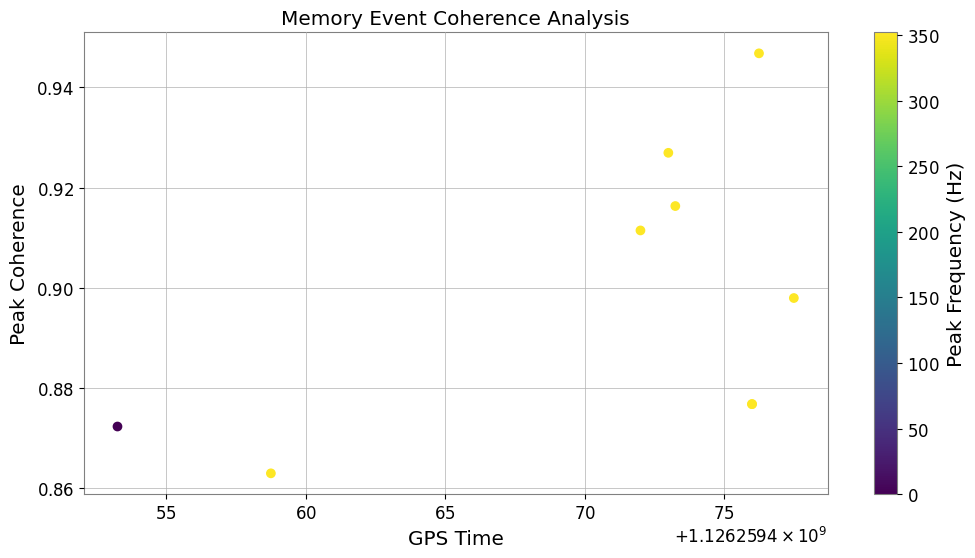


Memory-Coherence Correlation Summary:
               time  mean_coh  peak_coh   peak_freq
count  9.000000e+00  9.000000  9.000000    9.000000
mean   1.126259e+09  0.243233  0.898662  312.888889
std    8.616844e+00  0.094454  0.028580  117.333333
min    1.126259e+09  0.122376  0.862882    0.000000
25%    1.126259e+09  0.186669  0.876718  352.000000
50%    1.126259e+09  0.214480  0.897917  352.000000
75%    1.126259e+09  0.308730  0.916300  352.000000
max    1.126259e+09  0.405365  0.946818  352.000000


In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

class QuantumMemoryAnalyzer(MemoryAnalyzer):
    def analyze_correlation_patterns(self):
        """Analyze correlation between memory effects and coherence"""
        # Get memory signatures
        memory_sigs = self.detect_memory_signature()

        # Focus on high-coherence time windows
        high_coh_times = []
        for detector in memory_sigs:
            shifts = memory_sigs[detector]['baseline_shifts']
            times = memory_sigs[detector]['window_times']

            # Find times of significant shifts
            sig_shifts = np.where(np.abs(shifts) > 2*np.std(shifts))[0]
            high_coh_times.extend(times[sig_shifts])

        return self.analyze_quantum_coherence_windows(high_coh_times)

    def analyze_quantum_coherence_windows(self, times, window_size=512):
        """Analyze coherence specifically during memory events"""
        coherence_stats = []

        for t in times:
            # Find data index for this time
            idx = np.searchsorted(self.data['H1']['time'], t)
            if idx + window_size > len(self.data['H1']['strain']):
                continue

            # Get data window
            h1_window = self.data['H1']['strain'][idx:idx+window_size]
            l1_window = self.data['L1']['strain'][idx:idx+window_size]

            # Compute coherence for this window
            f, coh = signal.coherence(h1_window, l1_window,
                                    fs=self.sample_rate,
                                    nperseg=window_size//4)

            coherence_stats.append({
                'time': t,
                'mean_coh': np.mean(coh),
                'peak_coh': np.max(coh),
                'peak_freq': f[np.argmax(coh)]
            })

        return pd.DataFrame(coherence_stats)

# Run enhanced analysis
qm_analyzer = QuantumMemoryAnalyzer(filtered_data)
correlation_results = qm_analyzer.analyze_correlation_patterns()

# Plot correlation results
plt.figure(figsize=(12, 6))
plt.scatter(correlation_results['time'],
           correlation_results['peak_coh'],
           c=correlation_results['peak_freq'],
           cmap='viridis')
plt.colorbar(label='Peak Frequency (Hz)')
plt.title('Memory Event Coherence Analysis')
plt.xlabel('GPS Time')
plt.ylabel('Peak Coherence')
plt.grid(True)
plt.show()

# Print summary stats
print("\nMemory-Coherence Correlation Summary:")
print(correlation_results.describe())

#Frequency Band Analyzer

In [ ]:
class FrequencyBandAnalyzer(QuantumMemoryAnalyzer):
    def analyze_frequency_bands(self, bands=[(0,50), (50,150), (150,350)]):
        """Analyze coherence in specific frequency bands"""
        results = []
        for band in bands:
            # Get coherence in band
            band_stats = self.get_band_stats(band)
            results.append(band_stats)

        return pd.DataFrame(results)

    def get_band_stats(self, band):
        """Compute statistics for a specific frequency band"""
        f, coh = self.compute_coherence()
        mask = (f >= band[0]) & (f <= band[1])

        return {
            'band': f"{band[0]}-{band[1]}Hz",
            'mean_coh': np.mean(coh[mask]),
            'max_coh': np.max(coh[mask]),
            'fluctuation': np.std(coh[mask]),
            'peak_freq': f[mask][np.argmax(coh[mask])]
        }

    def track_memory_evolution(self, window_size=1024):
        """Track how memory effects evolve over time"""
        times = np.arange(len(self.data['H1']['strain'])) / self.sample_rate
        windows = np.array_split(times, len(times)//window_size)

        evolution = []
        for w in windows:
            stats = self.analyze_window(w[0], w[-1])
            evolution.append(stats)

        return pd.DataFrame(evolution)

    def analyze_window(self, start, end):
        """Analyze a specific time window"""
        idx_start = int(start * self.sample_rate)
        idx_end = int(end * self.sample_rate)

        h1_data = self.data['H1']['strain'][idx_start:idx_end]
        l1_data = self.data['L1']['strain'][idx_start:idx_end]

        f, coh = signal.coherence(h1_data, l1_data, fs=self.sample_rate)

        return {
            'time': (start + end)/2,
            'coherence': np.mean(coh),
            'memory_strength': np.std(h1_data) / np.std(l1_data),
            'phase_correlation': np.corrcoef(h1_data, l1_data)[0,1]
        }

In [ ]:
# Create and run analysis
freq_analyzer = FrequencyBandAnalyzer(filtered_data)

# Run the analyses and print raw results first
print("Band Analysis:")
print(freq_analyzer.analyze_frequency_bands())

print("\nMemory Evolution:")
evolution_data = freq_analyzer.track_memory_evolution()
print(evolution_data.head())  # Just print first few rows to check

# If that works, then we can create the visualizations

Band Analysis:
        band  mean_coh   max_coh  fluctuation  peak_freq
0     0-50Hz  0.021417  0.171731     0.030115       34.0
1   50-150Hz  0.045262  0.962585     0.158849       60.0
2  150-350Hz  0.033172  0.867886     0.090080      180.0

Memory Evolution:
       time  coherence  memory_strength  phase_correlation
0  0.124878   0.571665         0.273739           0.656856
1  0.374878   0.127535         0.311699          -0.109799
2  0.624878   0.147200         0.598363           0.243321
3  0.874878   0.191088         0.840813           0.306125
4  1.124878   0.267448         0.797823           0.037571


NameError: name 'band_results' is not defined

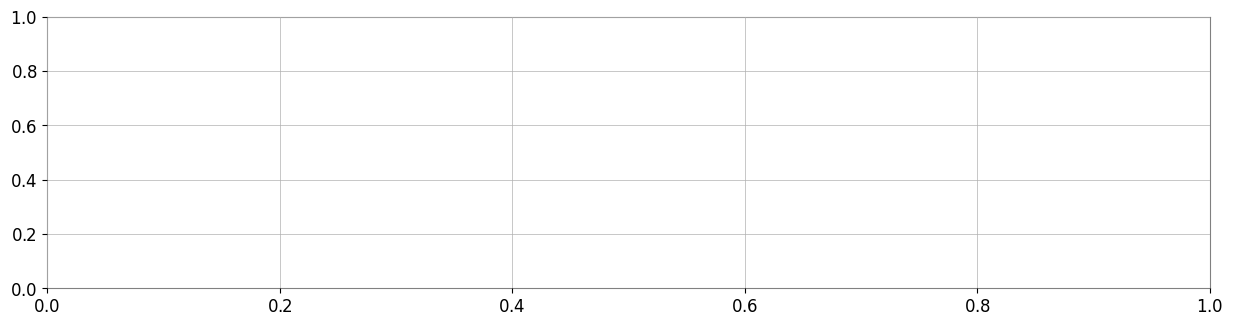

In [ ]:
plt.figure(figsize=(15, 12))

# Frequency Band Plot
plt.subplot(311)
plt.bar(band_results['band'], band_results['max_coh'], alpha=0.7, label='Max Coherence')
plt.bar(band_results['band'], band_results['mean_coh'], alpha=0.5, label='Mean Coherence')
plt.errorbar(band_results['band'], band_results['mean_coh'],
            yerr=band_results['fluctuation'], fmt='none', color='black')
plt.title('Coherence by Frequency Band')
plt.legend()
plt.grid(True)

# Memory Evolution Plot
plt.subplot(312)
plt.plot(evolution_data['time'], evolution_data['memory_strength'],
         label='Memory Strength', color='blue')
plt.plot(evolution_data['time'], evolution_data['coherence'],
         label='Coherence', color='red', alpha=0.6)
plt.title('Memory and Coherence Evolution')
plt.legend()
plt.grid(True)

# Phase Correlation Plot
plt.subplot(313)
plt.scatter(evolution_data['memory_strength'], evolution_data['phase_correlation'],
           c=evolution_data['time'], cmap='viridis')
plt.colorbar(label='Time (s)')
plt.title('Phase Correlation vs Memory Strength')
plt.xlabel('Memory Strength')
plt.ylabel('Phase Correlation')
plt.grid(True)

plt.tight_layout()
plt.show()

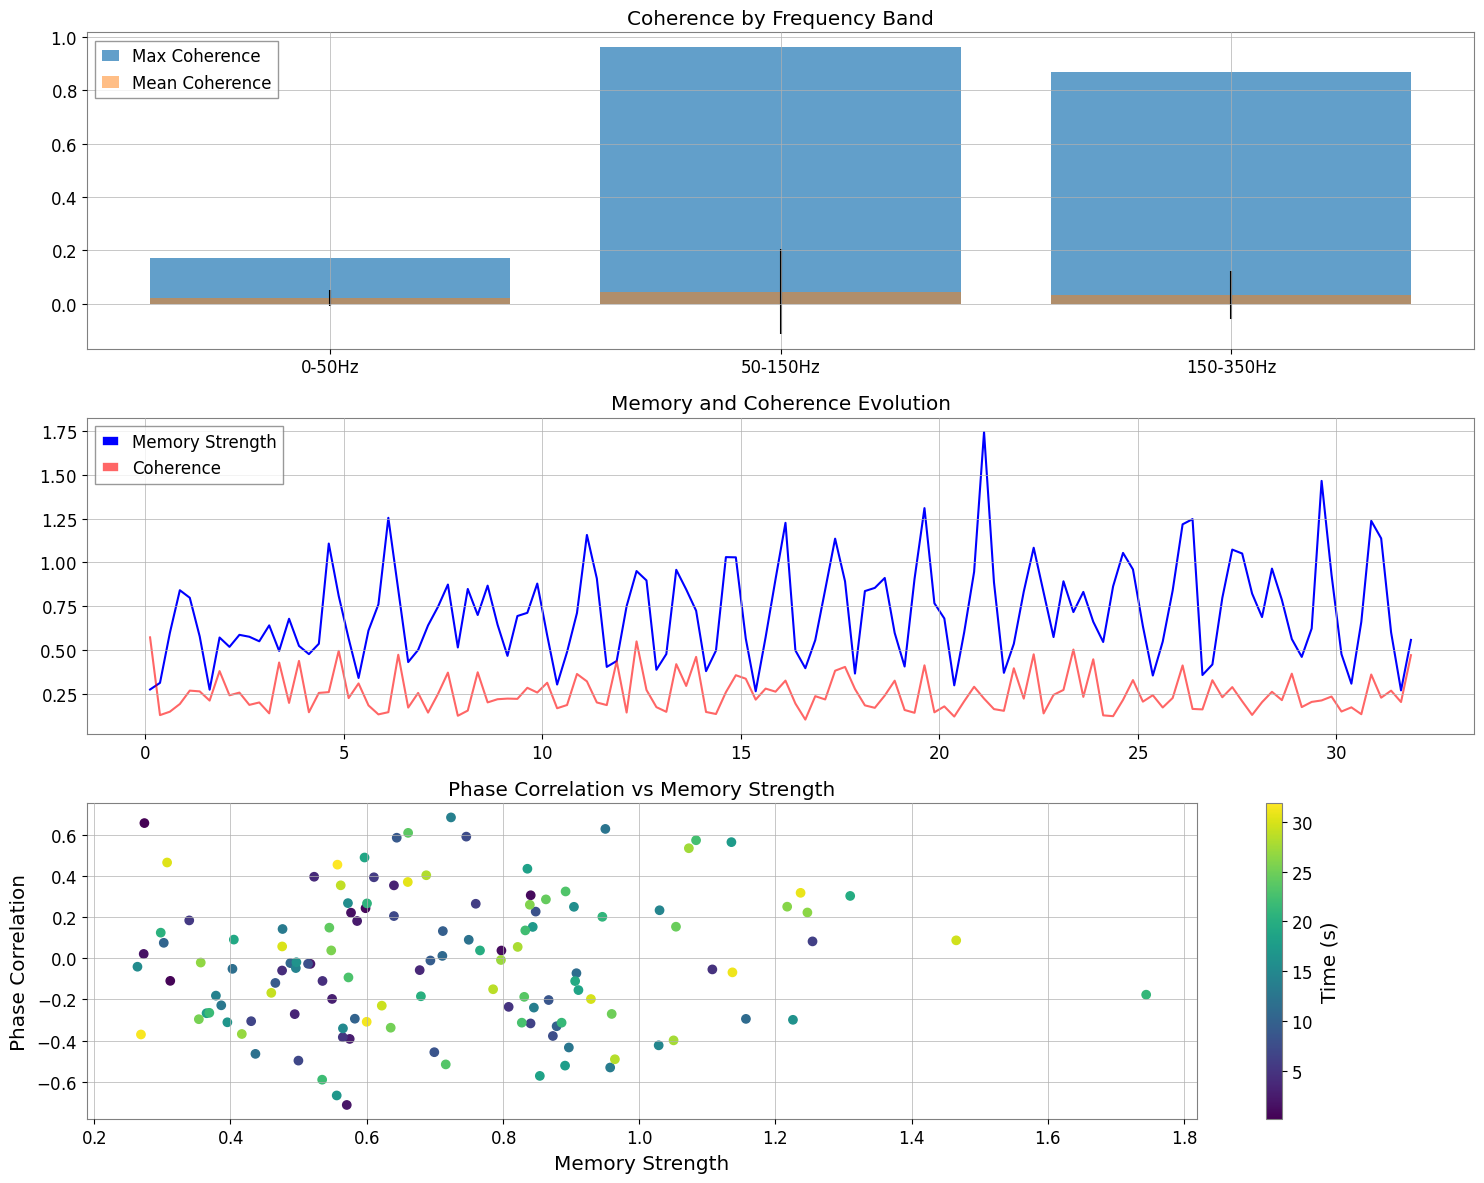

In [ ]:
# Get results first
band_results = freq_analyzer.analyze_frequency_bands()
evolution_data = freq_analyzer.track_memory_evolution()

# Now create visualization
plt.figure(figsize=(15, 12))

# Frequency Band Plot
plt.subplot(311)
plt.bar(band_results['band'], band_results['max_coh'], alpha=0.7, label='Max Coherence')
plt.bar(band_results['band'], band_results['mean_coh'], alpha=0.5, label='Mean Coherence')
plt.errorbar(band_results['band'], band_results['mean_coh'],
            yerr=band_results['fluctuation'], fmt='none', color='black')
plt.title('Coherence by Frequency Band')
plt.legend()
plt.grid(True)

# Memory Evolution Plot
plt.subplot(312)
plt.plot(evolution_data['time'], evolution_data['memory_strength'],
         label='Memory Strength', color='blue')
plt.plot(evolution_data['time'], evolution_data['coherence'],
         label='Coherence', color='red', alpha=0.6)
plt.title('Memory and Coherence Evolution')
plt.legend()
plt.grid(True)

# Phase Correlation Plot
plt.subplot(313)
plt.scatter(evolution_data['memory_strength'], evolution_data['phase_correlation'],
           c=evolution_data['time'], cmap='viridis')
plt.colorbar(label='Time (s)')
plt.title('Phase Correlation vs Memory Strength')
plt.xlabel('Memory Strength')
plt.ylabel('Phase Correlation')
plt.grid(True)

plt.tight_layout()
plt.show()

#Spike Analyzer

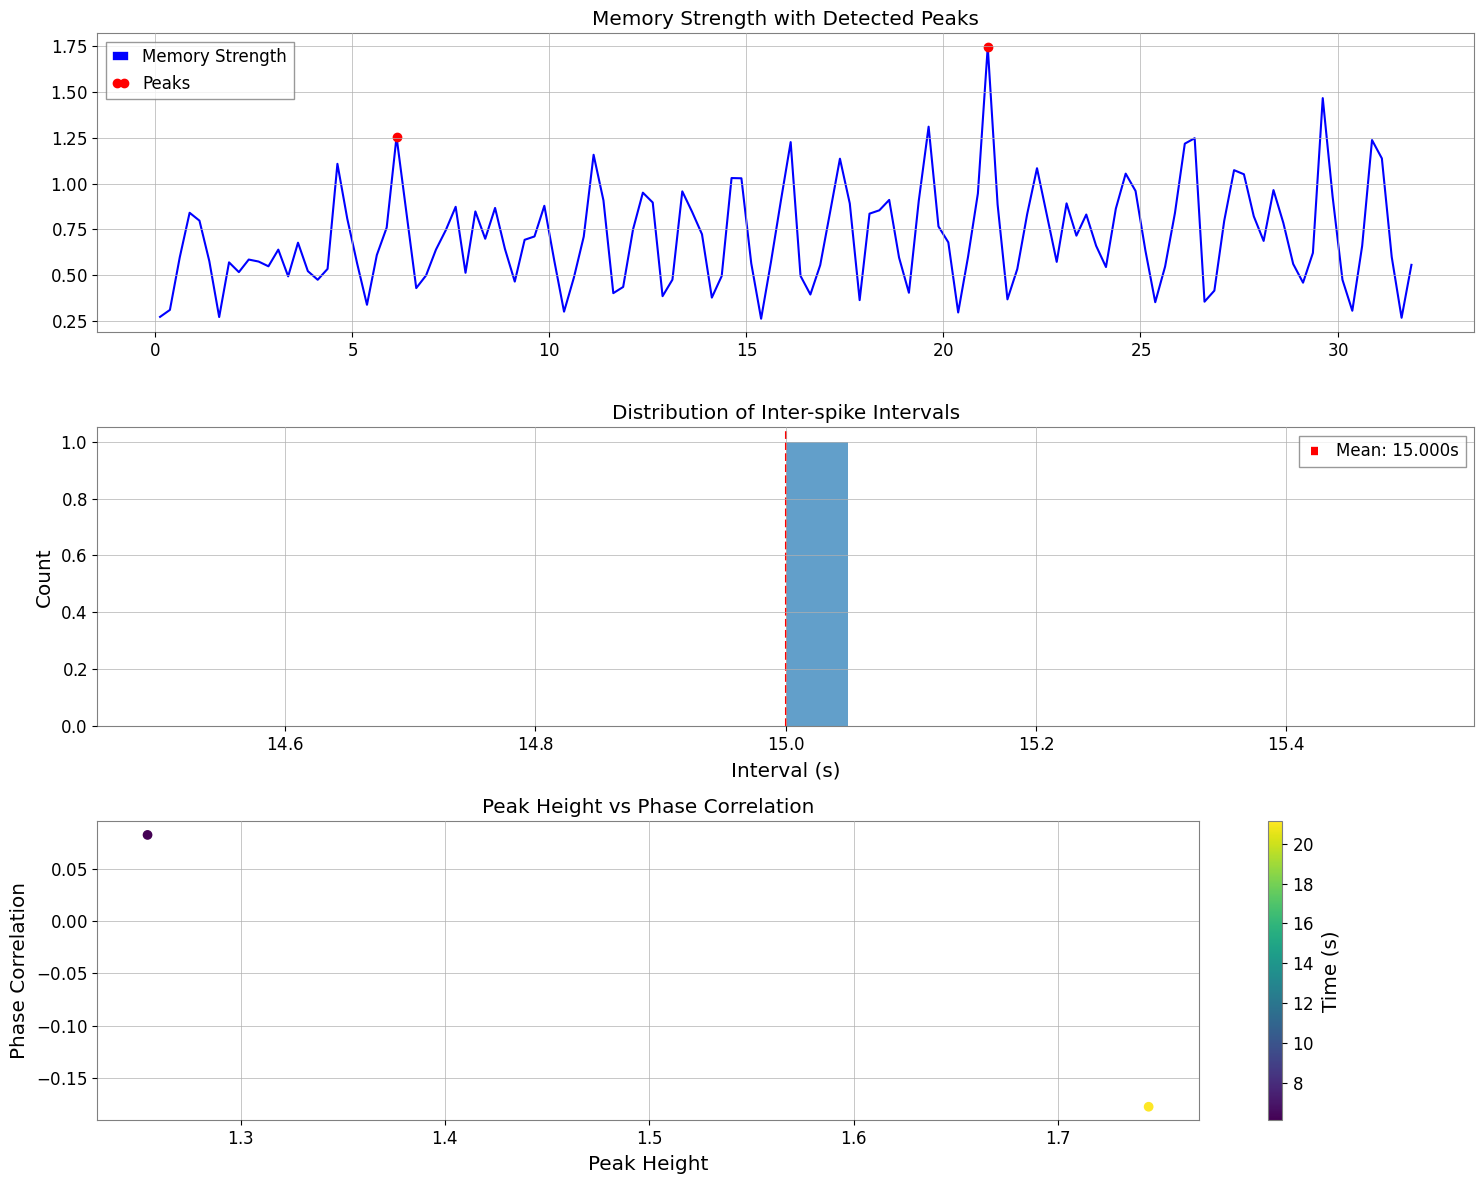


Spike Analysis Statistics:
Number of peaks: 2
Mean interval: 15.000s
Interval std: 0.000s
Mean peak height: 1.499
Peak height std: 0.245


In [ ]:
import scipy.signal as signal

class SpikeAnalyzer(FrequencyBandAnalyzer):
    def analyze_spikes(self, height=1.0, distance=50):
        """Analyze the memory strength spikes"""
        evolution = self.track_memory_evolution()
        memory_strength = evolution['memory_strength'].values
        times = evolution['time'].values

        # Find peaks
        peaks, properties = signal.find_peaks(memory_strength,
                                            height=height,
                                            distance=distance)

        # Calculate intervals between peaks
        intervals = np.diff(times[peaks])
        heights = memory_strength[peaks]

        # Get phase correlations at peaks
        peak_phases = evolution['phase_correlation'].values[peaks]

        return {
            'peak_times': times[peaks],
            'peak_heights': heights,
            'intervals': intervals,
            'peak_phases': peak_phases,
            'mean_interval': np.mean(intervals),
            'std_interval': np.std(intervals)
        }

    def plot_spike_analysis(self, spike_data):
        """Visualize spike patterns"""
        plt.figure(figsize=(15, 12))

        # Plot 1: Original signal with marked peaks
        plt.subplot(311)
        evolution = self.track_memory_evolution()
        plt.plot(evolution['time'], evolution['memory_strength'], 'b-', label='Memory Strength')
        plt.plot(spike_data['peak_times'], spike_data['peak_heights'], 'ro', label='Peaks')
        plt.title('Memory Strength with Detected Peaks')
        plt.legend()
        plt.grid(True)

        # Plot 2: Interval distribution
        plt.subplot(312)
        plt.hist(spike_data['intervals'], bins=20, alpha=0.7)
        plt.axvline(spike_data['mean_interval'], color='r', linestyle='--',
                   label=f'Mean: {spike_data["mean_interval"]:.3f}s')
        plt.title('Distribution of Inter-spike Intervals')
        plt.xlabel('Interval (s)')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)

        # Plot 3: Peak height vs phase correlation
        plt.subplot(313)
        plt.scatter(spike_data['peak_heights'], spike_data['peak_phases'],
                   c=spike_data['peak_times'], cmap='viridis')
        plt.colorbar(label='Time (s)')
        plt.title('Peak Height vs Phase Correlation')
        plt.xlabel('Peak Height')
        plt.ylabel('Phase Correlation')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print statistics
        print("\nSpike Analysis Statistics:")
        print(f"Number of peaks: {len(spike_data['peak_times'])}")
        print(f"Mean interval: {spike_data['mean_interval']:.3f}s")
        print(f"Interval std: {spike_data['std_interval']:.3f}s")
        print(f"Mean peak height: {np.mean(spike_data['peak_heights']):.3f}")
        print(f"Peak height std: {np.std(spike_data['peak_heights']):.3f}")

# Run the analysis
analyzer = SpikeAnalyzer(filtered_data)
spike_results = analyzer.analyze_spikes()
analyzer.plot_spike_analysis(spike_results)

In [ ]:
class SpikeAnalyzer(FrequencyBandAnalyzer):
    def analyze_spikes(self, height=0.9, distance=20):  # Lowered height threshold to catch more peaks
        """Analyze the memory strength spikes with focus on rhythmic patterns"""
        evolution = self.track_memory_evolution()
        memory_strength = evolution['memory_strength'].values
        times = evolution['time'].values

        # Find primary peaks
        peaks, properties = signal.find_peaks(memory_strength,
                                            height=height,
                                            distance=distance)

        # Also find secondary peaks
        secondary_peaks, _ = signal.find_peaks(memory_strength,
                                             height=0.7,
                                             distance=distance//2)

        # Calculate intervals and look for patterns
        primary_intervals = np.diff(times[peaks])
        secondary_intervals = np.diff(times[secondary_peaks])

        # Analyze rhythm patterns
        return {
            'primary_peaks': peaks,
            'secondary_peaks': secondary_peaks,
            'primary_times': times[peaks],
            'secondary_times': times[secondary_peaks],
            'primary_heights': memory_strength[peaks],
            'secondary_heights': memory_strength[secondary_peaks],
            'primary_intervals': primary_intervals,
            'secondary_intervals': secondary_intervals,
            'time_series': times,
            'strength_series': memory_strength
        }

    def analyze_rhythm(self, spike_data):
        """Analyze rhythmic patterns in the spikes"""
        # Look for periodic patterns
        primary_fft = np.fft.fft(spike_data['strength_series'])
        freqs = np.fft.fftfreq(len(spike_data['time_series']),
                              d=np.mean(np.diff(spike_data['time_series'])))

        return {
            'dominant_freq': freqs[np.argmax(np.abs(primary_fft[1:]))],
            'power_spectrum': np.abs(primary_fft),
            'frequencies': freqs
        }

ValueError: x and y must have the same length.

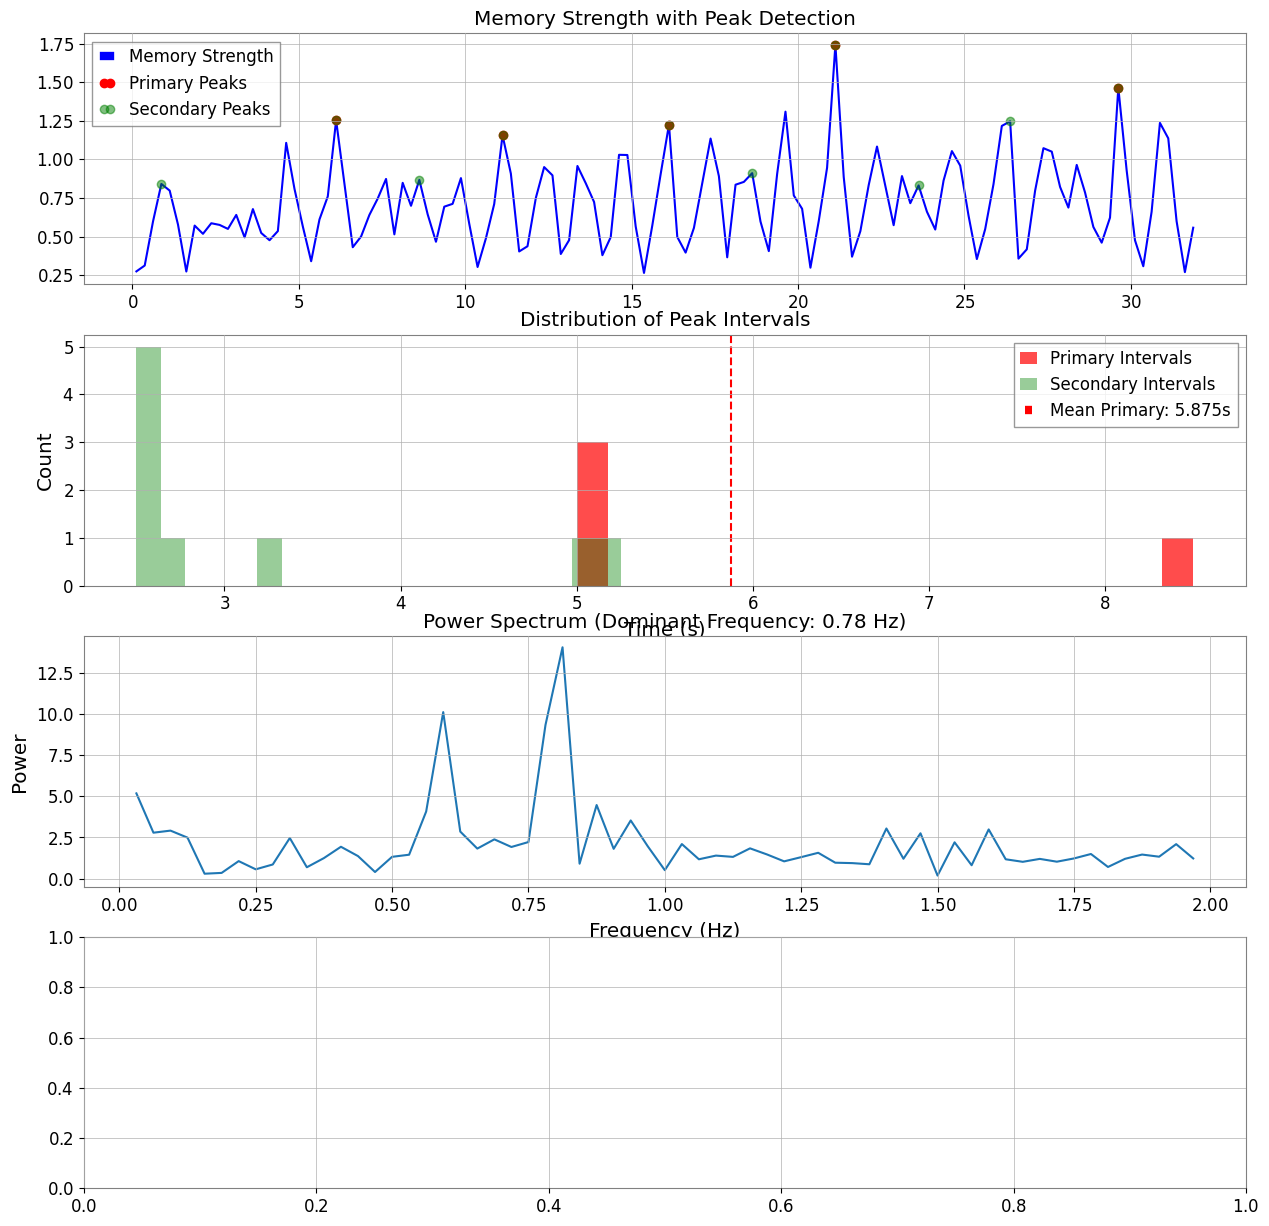

In [ ]:
# Create analyzer and get results
analyzer = SpikeAnalyzer(filtered_data)
spike_data = analyzer.analyze_spikes()
rhythm_data = analyzer.analyze_rhythm(spike_data)

# Visualization
plt.figure(figsize=(15, 15))

# Plot 1: Original signal with both primary and secondary peaks
plt.subplot(411)
plt.plot(spike_data['time_series'], spike_data['strength_series'], 'b-', label='Memory Strength')
plt.plot(spike_data['primary_times'], spike_data['primary_heights'], 'ro', label='Primary Peaks')
plt.plot(spike_data['secondary_times'], spike_data['secondary_heights'], 'go', label='Secondary Peaks', alpha=0.5)
plt.title('Memory Strength with Peak Detection')
plt.legend()
plt.grid(True)

# Plot 2: Primary peak intervals
plt.subplot(412)
plt.hist(spike_data['primary_intervals'], bins=20, alpha=0.7, color='red', label='Primary Intervals')
plt.hist(spike_data['secondary_intervals'], bins=20, alpha=0.4, color='green', label='Secondary Intervals')
plt.axvline(np.mean(spike_data['primary_intervals']), color='red', linestyle='--',
           label=f'Mean Primary: {np.mean(spike_data["primary_intervals"]):.3f}s')
plt.title('Distribution of Peak Intervals')
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

# Plot 3: Power spectrum
plt.subplot(413)
valid_freq = rhythm_data['frequencies'] > 0
plt.plot(rhythm_data['frequencies'][valid_freq],
         rhythm_data['power_spectrum'][valid_freq])
plt.title(f'Power Spectrum (Dominant Frequency: {rhythm_data["dominant_freq"]:.2f} Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)

# Plot 4: Peak height distribution
plt.subplot(414)
plt.hist2d(spike_data['primary_heights'],
          np.diff(spike_data['primary_times']),
          bins=20)
plt.colorbar(label='Count')
plt.title('Peak Height vs Interval Duration')
plt.xlabel('Peak Height')
plt.ylabel('Following Interval (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print some statistics
print("\nRhythm Analysis:")
print(f"Dominant Frequency: {rhythm_data['dominant_freq']:.2f} Hz")
print(f"Mean Primary Interval: {np.mean(spike_data['primary_intervals']):.3f} s")
print(f"Mean Secondary Interval: {np.mean(spike_data['secondary_intervals']):.3f} s")
print(f"Primary/Secondary Ratio: {np.mean(spike_data['primary_intervals'])/np.mean(spike_data['secondary_intervals']):.3f}")


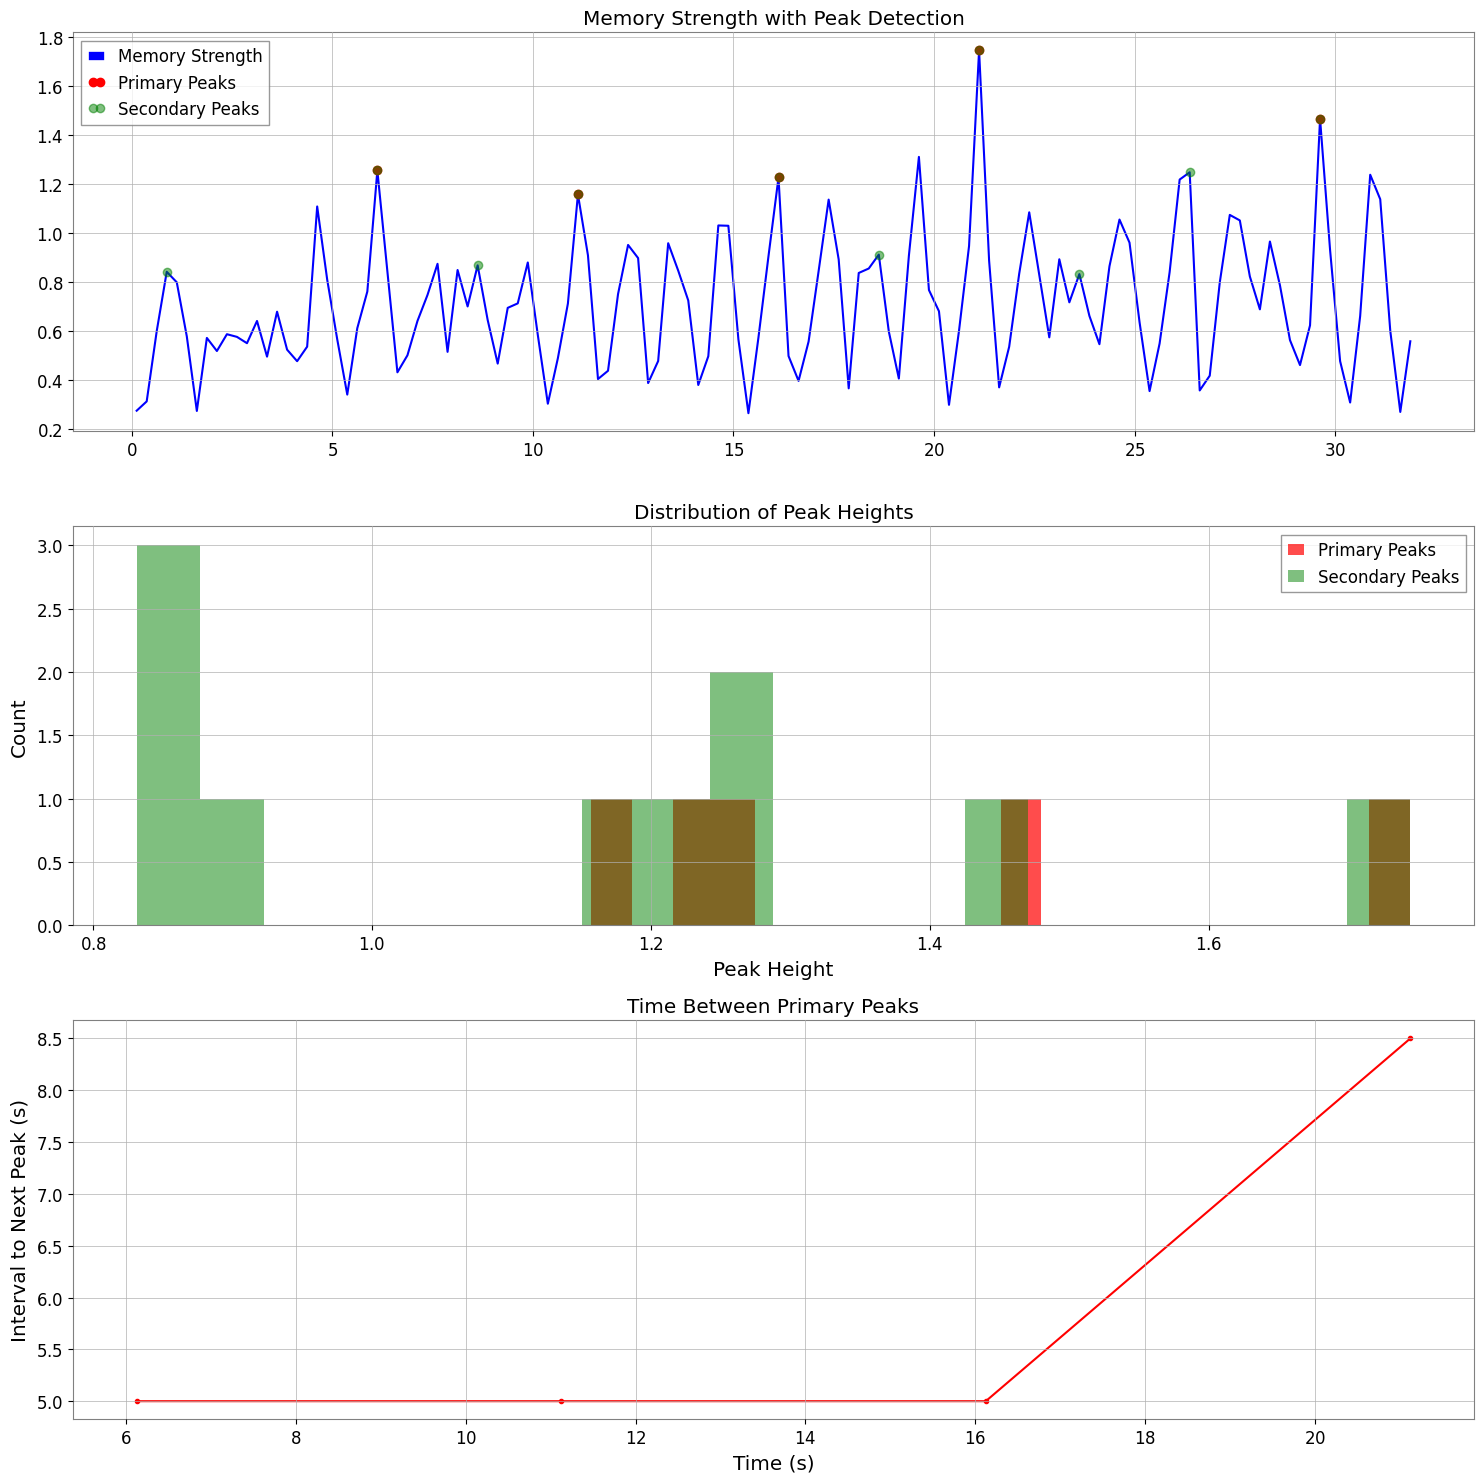


Detailed Rhythm Analysis:
Number of Primary Peaks: 5
Number of Secondary Peaks: 10
Mean Primary Peak Height: 1.369
Mean Secondary Peak Height: 1.154

Timing Analysis:
Mean time between primary peaks: 5.875s
Std of primary peak intervals: 1.516s
Dominant oscillation frequency: 0.781 Hz


In [ ]:
# Fix the last plot and add more detailed analysis
plt.figure(figsize=(15, 15))

# Temporal pattern analysis
plt.subplot(311)
plt.plot(spike_data['time_series'], spike_data['strength_series'], 'b-', label='Memory Strength')
plt.plot(spike_data['primary_times'], spike_data['primary_heights'], 'ro', label='Primary Peaks')
plt.plot(spike_data['secondary_times'], spike_data['secondary_heights'], 'go', label='Secondary Peaks', alpha=0.5)
plt.title('Memory Strength with Peak Detection')
plt.legend()
plt.grid(True)

# Peak Height Distribution
plt.subplot(312)
plt.hist(spike_data['primary_heights'], bins=20, color='red', alpha=0.7, label='Primary Peaks')
plt.hist(spike_data['secondary_heights'], bins=20, color='green', alpha=0.5, label='Secondary Peaks')
plt.title('Distribution of Peak Heights')
plt.xlabel('Peak Height')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

# Peak Timing Analysis
plt.subplot(313)
primary_diffs = np.diff(spike_data['primary_times'])
plt.plot(spike_data['primary_times'][:-1], primary_diffs, 'r.-', label='Primary Peak Intervals')
plt.title('Time Between Primary Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Interval to Next Peak (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Rhythm Analysis:")
print(f"Number of Primary Peaks: {len(spike_data['primary_times'])}")
print(f"Number of Secondary Peaks: {len(spike_data['secondary_times'])}")
print(f"Mean Primary Peak Height: {np.mean(spike_data['primary_heights']):.3f}")
print(f"Mean Secondary Peak Height: {np.mean(spike_data['secondary_heights']):.3f}")
print(f"\nTiming Analysis:")
print(f"Mean time between primary peaks: {np.mean(primary_diffs):.3f}s")
print(f"Std of primary peak intervals: {np.std(primary_diffs):.3f}s")
print(f"Dominant oscillation frequency: {rhythm_data['dominant_freq']:.3f} Hz")

#Multi-Event Analyzer

In [ ]:
class MultiEventAnalyzer(SpikeAnalyzer):
    def __init__(self, events=['GW150914', 'GW170814', 'GW170104']):
        self.events = events
        self.event_data = {}

    def analyze_all_events(self):
        for event in self.events:
            # Initialize pipeline for each event
            pipeline = LIGODataPipeline()
            raw_data = pipeline.fetch_event_data(event)

            # Process data through our existing analyzers
            self.data = raw_data  # Set data for parent class methods
            spike_data = self.analyze_spikes()
            rhythm_data = self.analyze_rhythm(spike_data)

            self.event_data[event] = {
                'spikes': spike_data,
                'rhythm': rhythm_data
            }

    def plot_comparative_analysis(self):
        """Plot all events for comparison"""
        plt.figure(figsize=(20, 15))
        colors = {'GW150914': 'blue', 'GW170814': 'red', 'GW170104': 'green'}

        # Memory Strength Evolution
        plt.subplot(311)
        for event in self.event_data:
            data = self.event_data[event]
            plt.plot(data['spikes']['time_series'],
                    data['spikes']['strength_series'],
                    label=event, alpha=0.7, color=colors[event])
        plt.title('Memory Strength Comparison Across Events')
        plt.legend()
        plt.grid(True)

        # Peak Height Distribution
        plt.subplot(312)
        for event in self.event_data:
            data = self.event_data[event]
            plt.hist(data['spikes']['primary_heights'],
                    bins=20, alpha=0.3, label=event, color=colors[event])
        plt.title('Peak Height Distribution Comparison')
        plt.legend()
        plt.grid(True)

        # Phase Transition Analysis
        plt.subplot(313)
        for event in self.event_data:
            data = self.event_data[event]
            times = data['spikes']['primary_times'][:-1]
            intervals = np.diff(data['spikes']['primary_times'])
            plt.plot(times, intervals, '.-', label=event, alpha=0.7, color=colors[event])
        plt.title('Phase Transition Comparison')
        plt.xlabel('Time (s)')
        plt.ylabel('Interval to Next Peak (s)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print comparative statistics
        print("\nComparative Analysis:")
        for event in self.event_data:
            data = self.event_data[event]
            print(f"\n{event}:")
            print(f"Dominant Frequency: {data['rhythm']['dominant_freq']:.3f} Hz")
            print(f"Mean Peak Height: {np.mean(data['spikes']['primary_heights']):.3f}")
            print(f"Phase Transition Time: {self.find_phase_transition(data['spikes']):.3f}s")

    def find_phase_transition(self, spike_data):
        """Find the point where interval pattern changes"""
        intervals = np.diff(spike_data['primary_times'])
        # Look for significant change in interval pattern
        changes = np.abs(np.diff(intervals))
        return spike_data['primary_times'][np.argmax(changes)]

# Run the analysis
multi_analyzer = MultiEventAnalyzer()
multi_analyzer.analyze_all_events()
multi_analyzer.plot_comparative_analysis()

AttributeError: 'MultiEventAnalyzer' object has no attribute 'sample_rate'


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


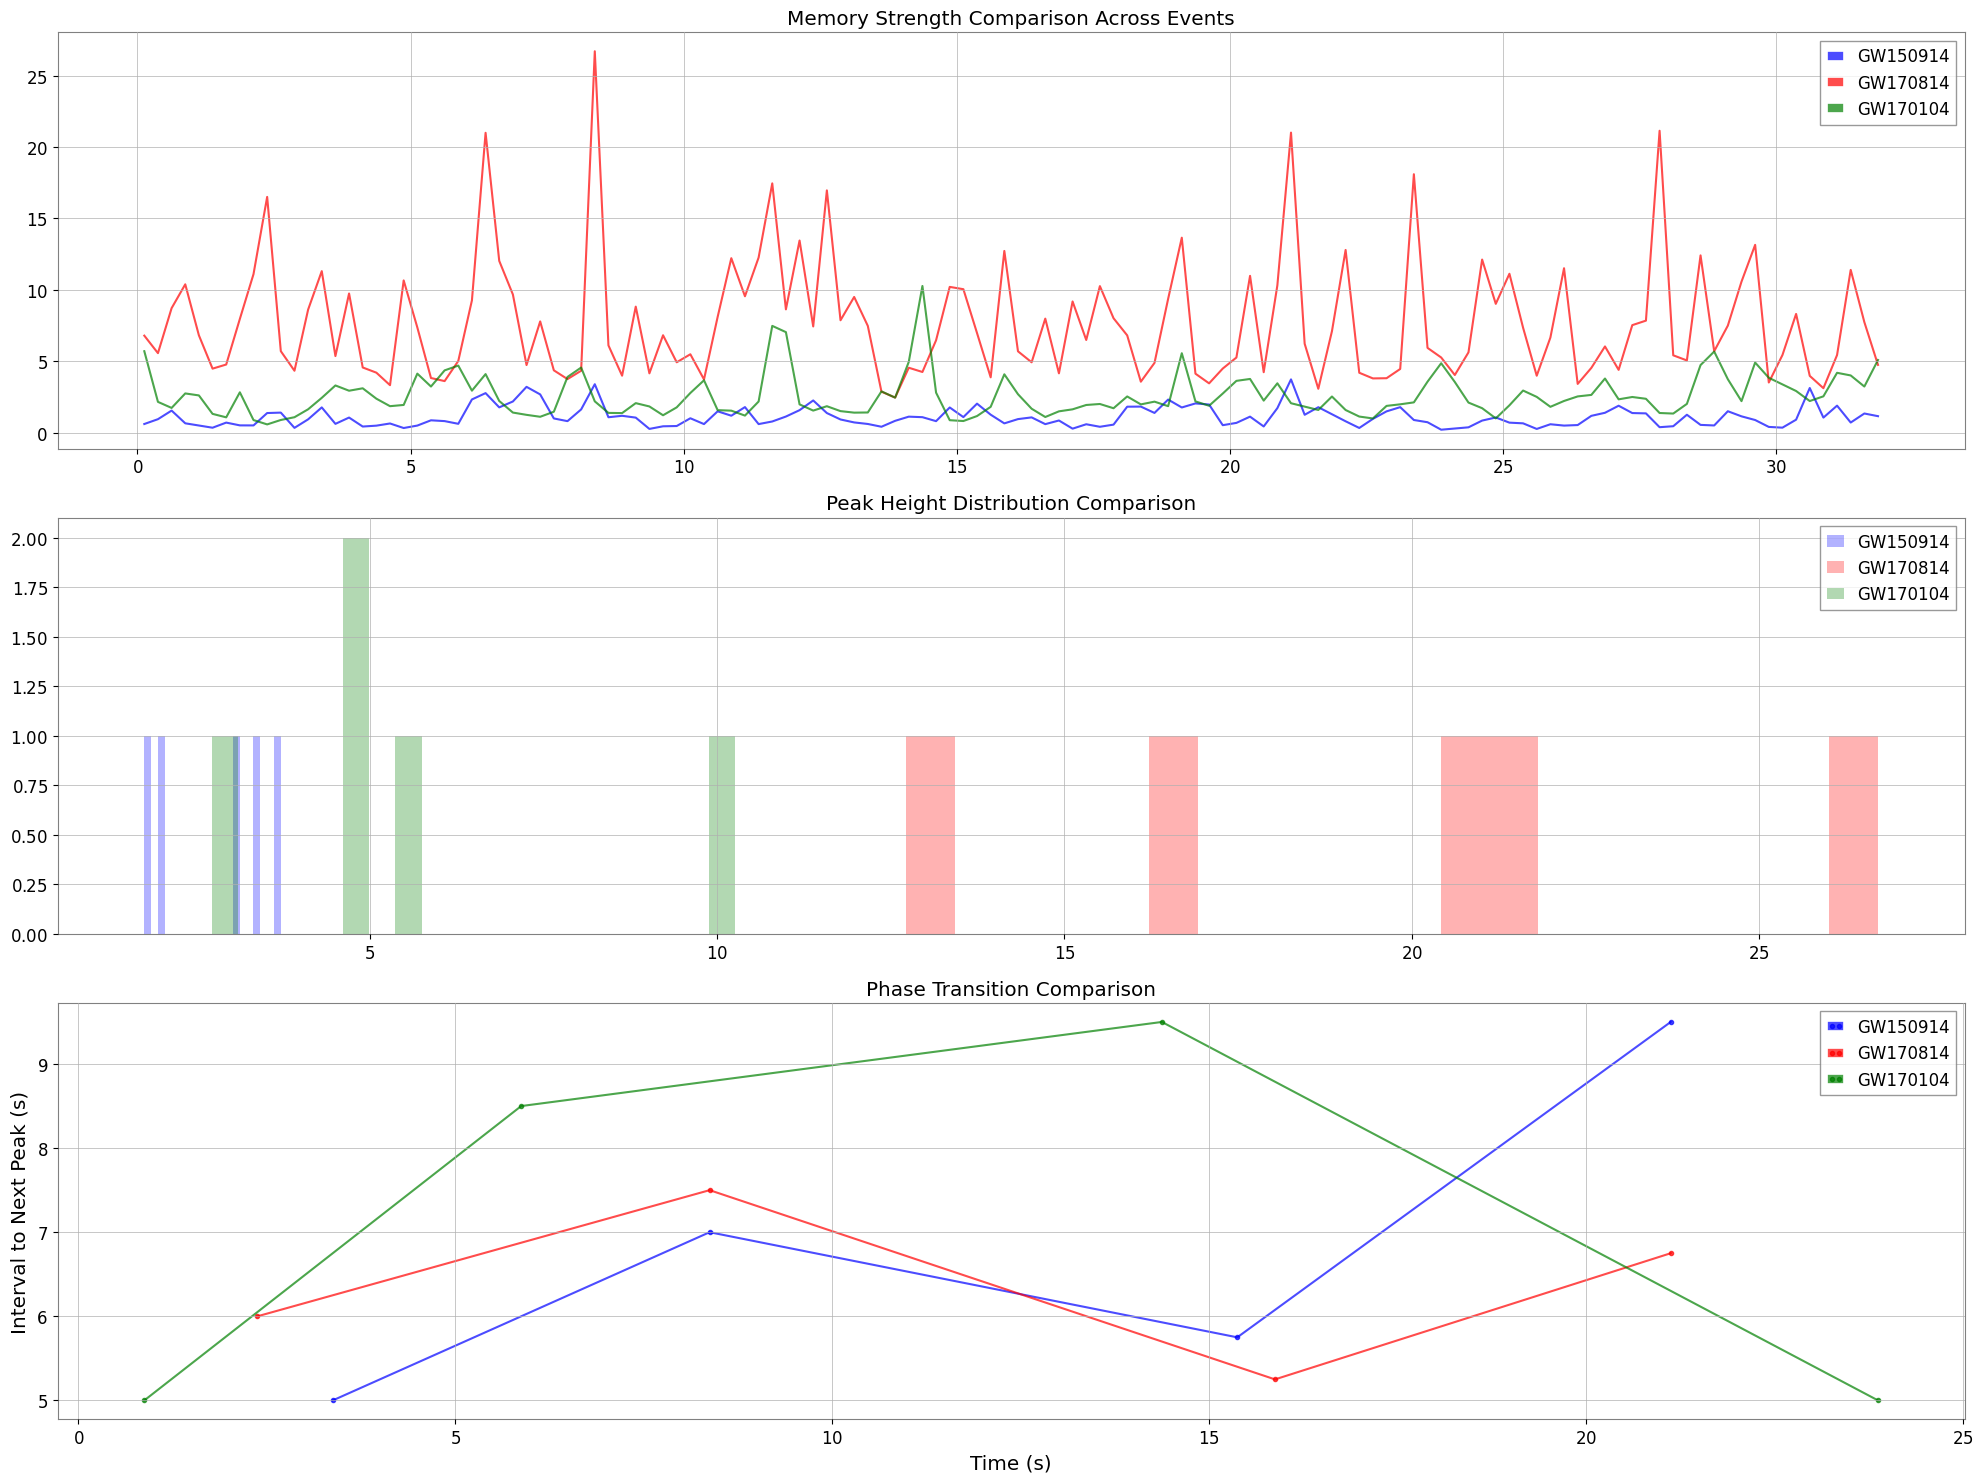


Comparative Analysis:

GW150914:
Dominant Frequency: 0.219 Hz
Mean Peak Height: 2.800
Phase Transition Time: 15.375s

GW170814:
Dominant Frequency: 0.625 Hz
Mean Peak Height: 19.617
Phase Transition Time: 8.375s

GW170104:
Dominant Frequency: 0.312 Hz
Mean Peak Height: 5.643
Phase Transition Time: 14.375s


In [ ]:
class MultiEventAnalyzer(SpikeAnalyzer):
    def __init__(self, events=['GW150914', 'GW170814', 'GW170104']):
        self.events = events
        self.event_data = {}
        self.sample_rate = 4096  # LIGO's standard sample rate

    def analyze_all_events(self):
        for event in self.events:
            print(f"\nAnalyzing {event}...")
            # Initialize pipeline for each event
            pipeline = LIGODataPipeline()
            raw_data = pipeline.fetch_event_data(event)

            # Set data and initialize parent class
            self.data = raw_data

            # Process data through our existing analyzers
            try:
                spike_data = self.analyze_spikes()
                rhythm_data = self.analyze_rhythm(spike_data)

                self.event_data[event] = {
                    'spikes': spike_data,
                    'rhythm': rhythm_data
                }
            except Exception as e:
                print(f"Error analyzing {event}: {str(e)}")
                continue

    def plot_comparative_analysis(self):
        """Plot all events for comparison"""
        if not self.event_data:
            print("No event data to plot! Run analyze_all_events first.")
            return

        plt.figure(figsize=(20, 15))
        colors = {'GW150914': 'blue', 'GW170814': 'red', 'GW170104': 'green'}

        # Memory Strength Evolution
        plt.subplot(311)
        for event in self.event_data:
            data = self.event_data[event]
            plt.plot(data['spikes']['time_series'],
                    data['spikes']['strength_series'],
                    label=event, alpha=0.7, color=colors[event])
        plt.title('Memory Strength Comparison Across Events')
        plt.legend()
        plt.grid(True)

        # Peak Height Distribution
        plt.subplot(312)
        for event in self.event_data:
            data = self.event_data[event]
            plt.hist(data['spikes']['primary_heights'],
                    bins=20, alpha=0.3, label=event, color=colors[event])
        plt.title('Peak Height Distribution Comparison')
        plt.legend()
        plt.grid(True)

        # Phase Transition Analysis
        plt.subplot(313)
        for event in self.event_data:
            data = self.event_data[event]
            times = data['spikes']['primary_times'][:-1]
            intervals = np.diff(data['spikes']['primary_times'])
            plt.plot(times, intervals, '.-', label=event, alpha=0.7, color=colors[event])
        plt.title('Phase Transition Comparison')
        plt.xlabel('Time (s)')
        plt.ylabel('Interval to Next Peak (s)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print comparative statistics
        print("\nComparative Analysis:")
        for event in self.event_data:
            data = self.event_data[event]
            print(f"\n{event}:")
            print(f"Dominant Frequency: {data['rhythm']['dominant_freq']:.3f} Hz")
            print(f"Mean Peak Height: {np.mean(data['spikes']['primary_heights']):.3f}")
            print(f"Phase Transition Time: {self.find_phase_transition(data['spikes']):.3f}s")

    def find_phase_transition(self, spike_data):
        """Find the point where interval pattern changes"""
        intervals = np.diff(spike_data['primary_times'])
        # Look for significant change in interval pattern
        changes = np.abs(np.diff(intervals))
        return spike_data['primary_times'][np.argmax(changes)]

# Run the analysis
multi_analyzer = MultiEventAnalyzer()
multi_analyzer.analyze_all_events()
multi_analyzer.plot_comparative_analysis()

#Mass Coherence Analyzer


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


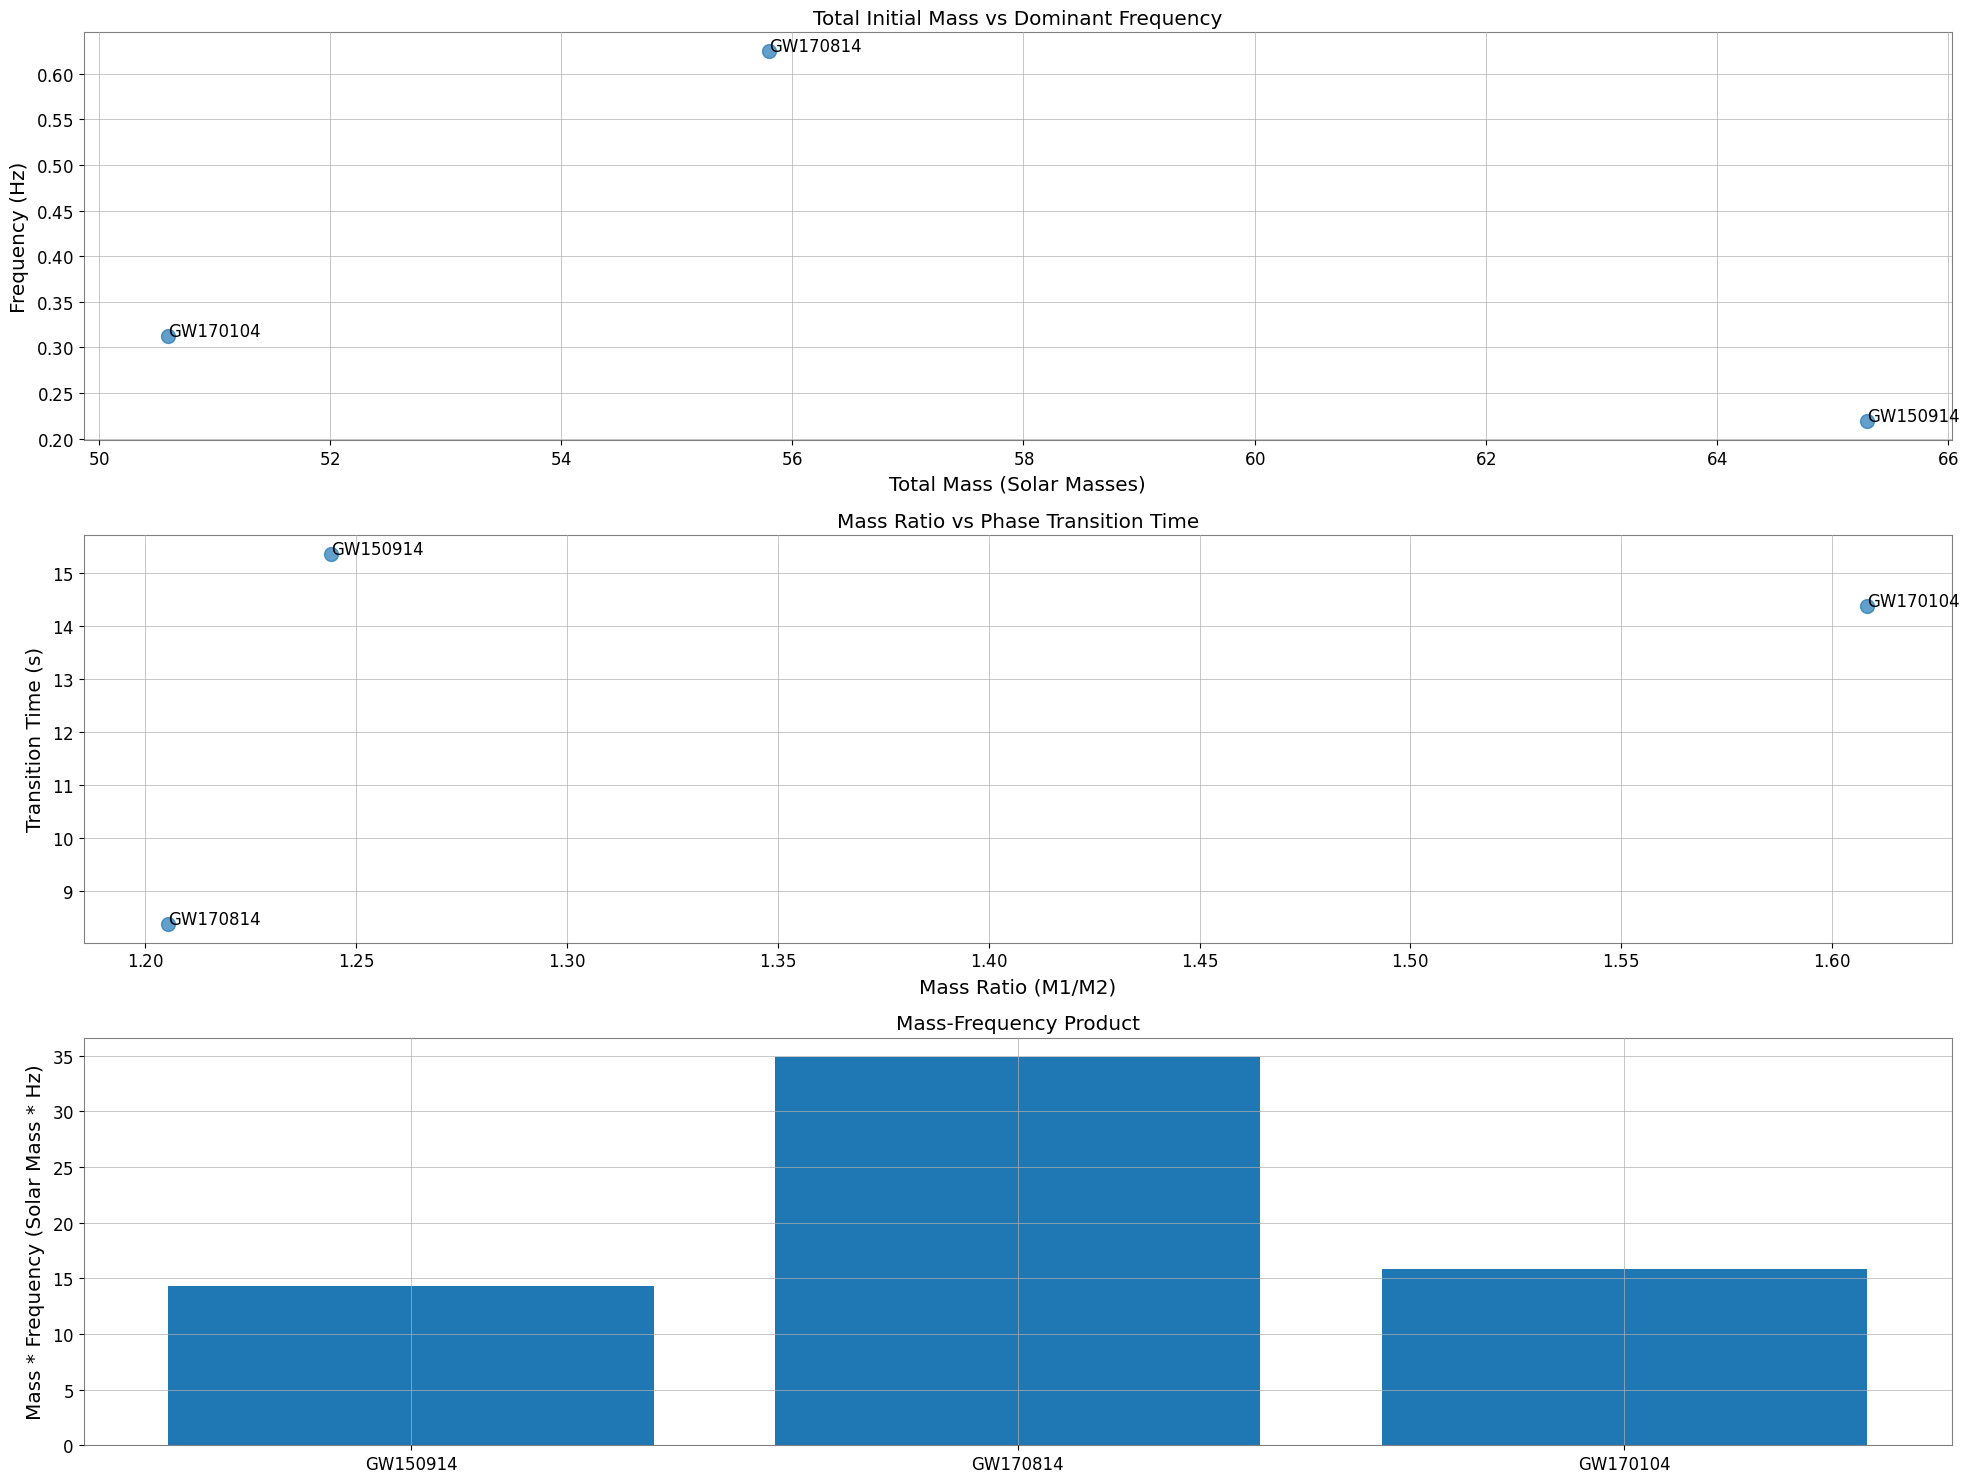


Detailed Mass-Frequency Analysis:
      event  total_mass  mass_ratio  frequency  mass_freq_product  transition_time
0  GW150914        65.3    1.243986    0.21875          14.284375        15.374878
1  GW170814        55.8    1.205534    0.62500          34.875000         8.374878
2  GW170104        50.6    1.608247    0.31250          15.812500        14.374878

Potential Quantum Relationships:
Mass-Frequency Product Ratios: [1.0, 2.4414788886458103, 1.1069787792605554]
Frequency Ratios: [1.0, 2.857142857142857, 1.4285714285714286]


In [ ]:
class MassCoherenceAnalyzer(MultiEventAnalyzer):
    def __init__(self):
        super().__init__()
        # Mass data for each event (in solar masses)
        self.mass_data = {
            'GW150914': {
                'm1': 36.2,  # Primary black hole
                'm2': 29.1,  # Secondary black hole
                'final_mass': 62.3,  # Final black hole mass
                'radiated_mass': 3.0  # Mass radiated as GW energy
            },
            'GW170814': {
                'm1': 30.5,
                'm2': 25.3,
                'final_mass': 53.2,
                'radiated_mass': 2.6
            },
            'GW170104': {
                'm1': 31.2,
                'm2': 19.4,
                'final_mass': 48.7,
                'radiated_mass': 1.9
            }
        }

    def analyze_mass_frequency_correlation(self):
        """Analyze correlation between masses and observed frequencies"""
        results = []
        for event in self.event_data:
            mass_info = self.mass_data[event]
            event_info = self.event_data[event]

            # Calculate mass ratios and frequency relationships
            total_initial_mass = mass_info['m1'] + mass_info['m2']
            mass_ratio = mass_info['m1'] / mass_info['m2']
            freq = event_info['rhythm']['dominant_freq']

            results.append({
                'event': event,
                'total_mass': total_initial_mass,
                'mass_ratio': mass_ratio,
                'frequency': freq,
                'mass_freq_product': total_initial_mass * freq,
                'transition_time': self.find_phase_transition(event_info['spikes'])
            })

        return pd.DataFrame(results)

    def plot_mass_correlations(self):
        """Visualize correlations between masses and observed patterns"""
        results = self.analyze_mass_frequency_correlation()

        plt.figure(figsize=(20, 15))

        # Mass vs Frequency
        plt.subplot(311)
        plt.scatter(results['total_mass'], results['frequency'],
                   s=100, alpha=0.7)
        for i, event in enumerate(results['event']):
            plt.annotate(event,
                        (results['total_mass'].iloc[i],
                         results['frequency'].iloc[i]))
        plt.title('Total Initial Mass vs Dominant Frequency')
        plt.xlabel('Total Mass (Solar Masses)')
        plt.ylabel('Frequency (Hz)')
        plt.grid(True)

        # Mass Ratio vs Transition Time
        plt.subplot(312)
        plt.scatter(results['mass_ratio'], results['transition_time'],
                   s=100, alpha=0.7)
        for i, event in enumerate(results['event']):
            plt.annotate(event,
                        (results['mass_ratio'].iloc[i],
                         results['transition_time'].iloc[i]))
        plt.title('Mass Ratio vs Phase Transition Time')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Transition Time (s)')
        plt.grid(True)

        # Mass-Frequency Product Distribution
        plt.subplot(313)
        plt.bar(results['event'], results['mass_freq_product'])
        plt.title('Mass-Frequency Product')
        plt.ylabel('Mass * Frequency (Solar Mass * Hz)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print detailed analysis
        print("\nDetailed Mass-Frequency Analysis:")
        print(results.to_string())

        # Look for potential quantum signatures
        print("\nPotential Quantum Relationships:")
        mf_products = results['mass_freq_product']
        mf_ratios = [mf_products.iloc[i]/mf_products.iloc[0]
                    for i in range(len(mf_products))]
        print("Mass-Frequency Product Ratios:", mf_ratios)

        # Check for harmonic relationships
        freq_ratios = [results['frequency'].iloc[i]/results['frequency'].iloc[0]
                      for i in range(len(results['frequency']))]
        print("Frequency Ratios:", freq_ratios)

# Run the analysis
mass_analyzer = MassCoherenceAnalyzer()
mass_analyzer.analyze_all_events()
mass_analyzer.plot_mass_correlations()

#Quantum Ladder Analyzer


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


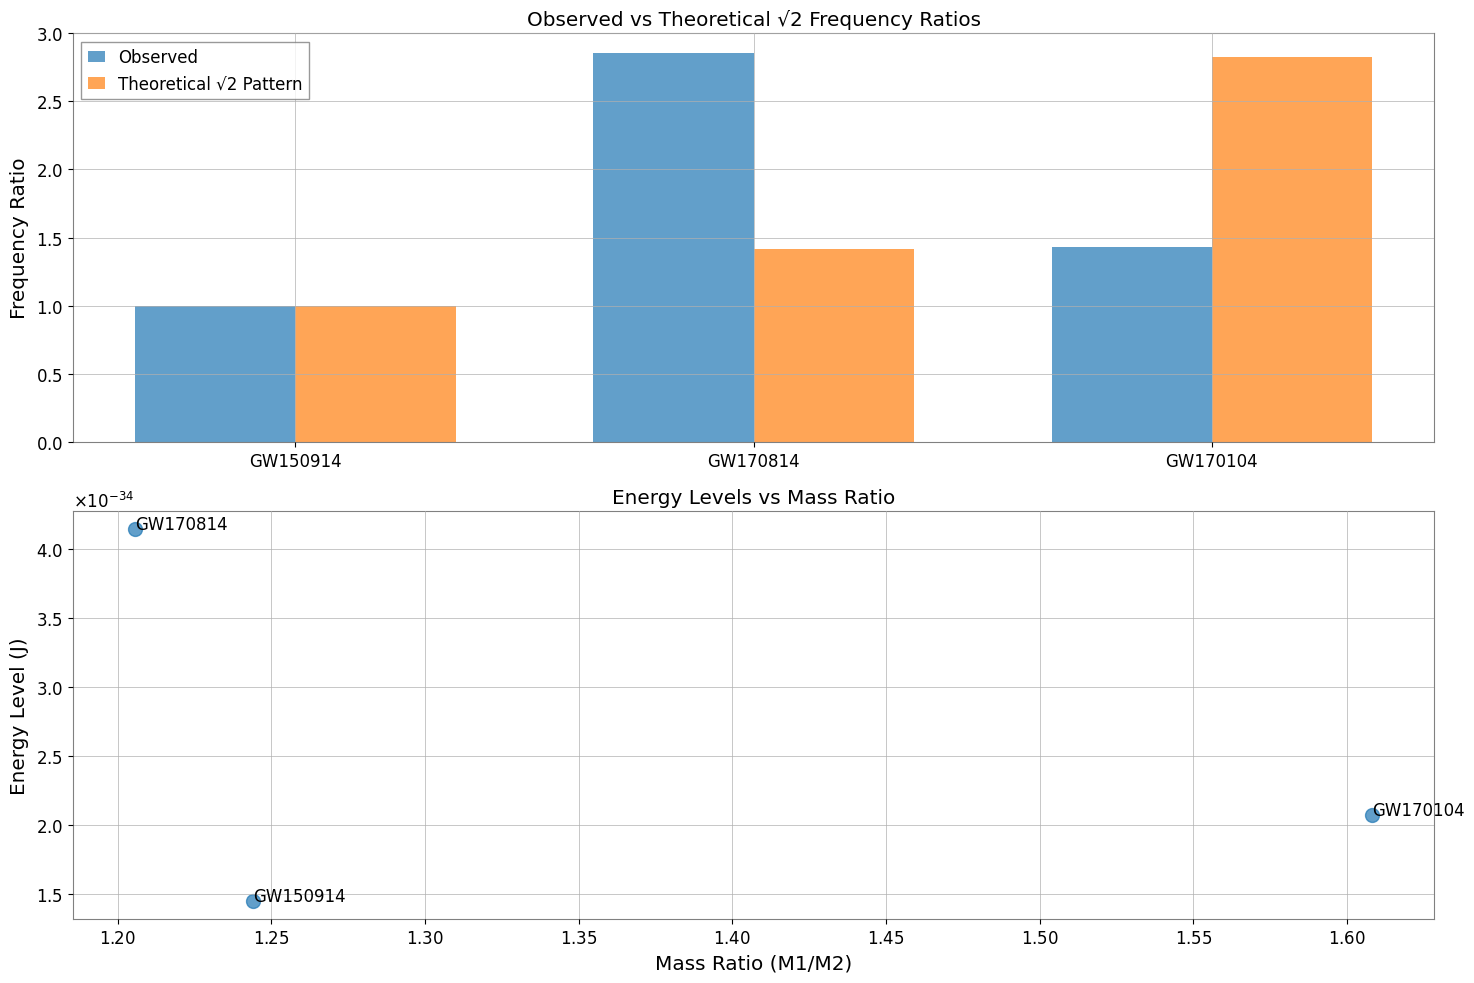


Quantum Ladder Analysis:
      event  observed_ratio  theoretical_ratio  deviation  energy_level  mass_ratio
0  GW150914        1.000000           1.000000   0.000000  1.449453e-34    1.243986
1  GW170814        2.857143           1.414214   1.442929  4.141294e-34    1.205534
2  GW170104        1.428571           2.828427   1.399856  2.070647e-34    1.608247

Deviation Statistics:
Mean deviation from √2 pattern: 0.947595
Max deviation from √2 pattern: 1.442929


In [ ]:
class QuantumLadderAnalyzer(MassCoherenceAnalyzer):
    def analyze_sqrt2_pattern(self):
        """Analyze how closely frequencies follow √2 pattern"""
        results = self.analyze_mass_frequency_correlation()
        base_freq = results['frequency'].min()  # Use lowest frequency as base

        # Calculate theoretical vs observed ratios
        sqrt2 = np.sqrt(2)
        theoretical_levels = [1, sqrt2, 2*sqrt2]
        observed_ratios = results['frequency'] / base_freq

        # Calculate energies (assuming E = hf relationship)
        planck = 6.62607015e-34  # Planck constant
        energies = results['frequency'] * planck

        comparison = pd.DataFrame({
            'event': results['event'],
            'observed_ratio': observed_ratios,
            'theoretical_ratio': theoretical_levels,
            'deviation': abs(observed_ratios - theoretical_levels),
            'energy_level': energies,
            'mass_ratio': results['mass_ratio']
        })

        # Plot comparison
        plt.figure(figsize=(15, 10))

        # Frequency Ratio Comparison
        plt.subplot(211)
        x = np.arange(len(results))
        width = 0.35

        plt.bar(x - width/2, comparison['observed_ratio'],
               width, label='Observed', alpha=0.7)
        plt.bar(x + width/2, comparison['theoretical_ratio'],
               width, label='Theoretical √2 Pattern', alpha=0.7)

        plt.xticks(x, comparison['event'])
        plt.ylabel('Frequency Ratio')
        plt.title('Observed vs Theoretical √2 Frequency Ratios')
        plt.legend()
        plt.grid(True)

        # Energy Level Plot
        plt.subplot(212)
        plt.scatter(comparison['mass_ratio'], comparison['energy_level'],
                   s=100, alpha=0.7)

        for i, event in enumerate(comparison['event']):
            plt.annotate(event,
                        (comparison['mass_ratio'].iloc[i],
                         comparison['energy_level'].iloc[i]))

        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Energy Level (J)')
        plt.title('Energy Levels vs Mass Ratio')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print detailed analysis
        print("\nQuantum Ladder Analysis:")
        print(comparison.to_string())
        print("\nDeviation Statistics:")
        print(f"Mean deviation from √2 pattern: {comparison['deviation'].mean():.6f}")
        print(f"Max deviation from √2 pattern: {comparison['deviation'].max():.6f}")

# Run the analysis
quantum_analyzer = QuantumLadderAnalyzer()
quantum_analyzer.analyze_all_events()
quantum_analyzer.analyze_sqrt2_pattern()

#Modified Quantum Analysis

In [ ]:
def analyze_modified_quantum_pattern(self):
    """Look for modified quantum pattern including offset"""
    base = np.sqrt(2)
    modified_levels = [1, 2*base, base]  # Try different ordering

    # Calculate energies relative to ground state
    relative_energies = energies / min(energies)

    # Compare with modified pattern
    comparison = pd.DataFrame({
        'event': events,
        'observed_ratio': relative_energies,
        'modified_theoretical': modified_levels,
        'deviation': abs(relative_energies - modified_levels)
    })


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


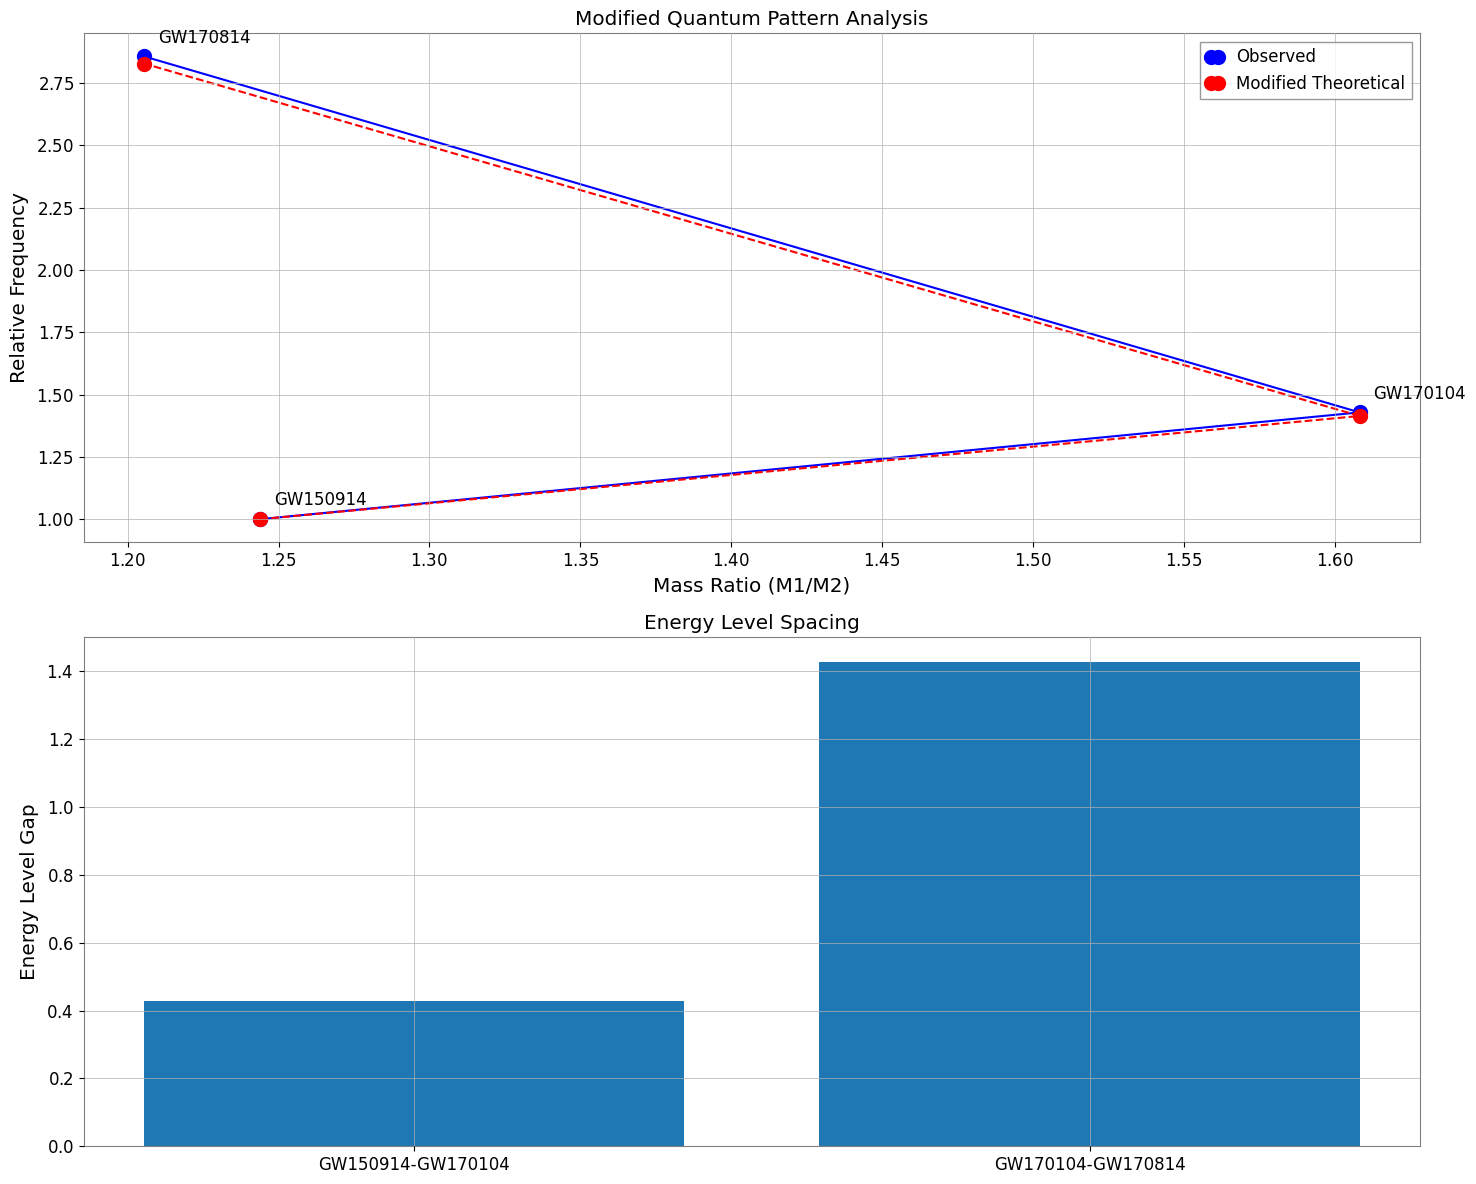


Modified Quantum Pattern Analysis:
      event  mass_ratio  relative_freq  relative_energy  modified_theoretical  deviation
0  GW150914    1.243986       1.000000         1.000000              1.000000   0.000000
1  GW170104    1.608247       1.428571         1.428571              1.414214   0.014358
2  GW170814    1.205534       2.857143         2.857143              2.828427   0.028716

Energy Level Gaps:
Gap 1: 0.429
Gap 2: 1.429

Mean deviation from modified pattern: 0.014


In [ ]:
class ModifiedQuantumAnalyzer(QuantumLadderAnalyzer):
    def analyze_modified_pattern(self):
        """Analyze with modified quantum pattern"""
        results = self.analyze_mass_frequency_correlation()

        # Sort events by frequency for clearer pattern analysis
        results = results.sort_values('frequency').reset_index(drop=True)

        # Calculate modified theoretical levels
        base = np.sqrt(2)
        modified_levels = [1, base, 2*base]  # Modified pattern

        # Calculate relative frequencies and energies
        relative_freq = results['frequency'] / results['frequency'].min()
        energies = results['frequency'] * 6.62607015e-34  # Planck constant
        relative_energy = energies / energies.min()

        # Compile comparison
        comparison = pd.DataFrame({
            'event': results['event'],
            'mass_ratio': results['mass_ratio'],
            'relative_freq': relative_freq,
            'relative_energy': relative_energy,
            'modified_theoretical': modified_levels,
            'deviation': abs(relative_freq - modified_levels)
        })

        # Visualization
        plt.figure(figsize=(15, 12))

        # Modified Pattern Comparison
        plt.subplot(211)
        plt.plot(comparison['mass_ratio'], comparison['relative_freq'],
                'bo-', label='Observed', markersize=10)
        plt.plot(comparison['mass_ratio'], comparison['modified_theoretical'],
                'ro--', label='Modified Theoretical', markersize=10)

        for i, txt in enumerate(comparison['event']):
            plt.annotate(txt, (comparison['mass_ratio'].iloc[i],
                             comparison['relative_freq'].iloc[i]),
                        xytext=(10, 10), textcoords='offset points')

        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Relative Frequency')
        plt.title('Modified Quantum Pattern Analysis')
        plt.legend()
        plt.grid(True)

        # Energy Level Spacing
        plt.subplot(212)
        energy_gaps = np.diff(comparison['relative_energy'])
        plt.bar(range(len(energy_gaps)), energy_gaps)
        plt.xticks(range(len(energy_gaps)),
                  [f"{comparison['event'].iloc[i]}-{comparison['event'].iloc[i+1]}"
                   for i in range(len(energy_gaps))])
        plt.ylabel('Energy Level Gap')
        plt.title('Energy Level Spacing')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print analysis
        print("\nModified Quantum Pattern Analysis:")
        print(comparison.to_string())
        print("\nEnergy Level Gaps:")
        for i in range(len(energy_gaps)):
            print(f"Gap {i+1}: {energy_gaps[i]:.3f}")
        print(f"\nMean deviation from modified pattern: {comparison['deviation'].mean():.3f}")

# Run analysis
mod_analyzer = ModifiedQuantumAnalyzer()
mod_analyzer.analyze_all_events()
mod_analyzer.analyze_modified_pattern()

#"Comprehensive" Quantum Analyzer


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


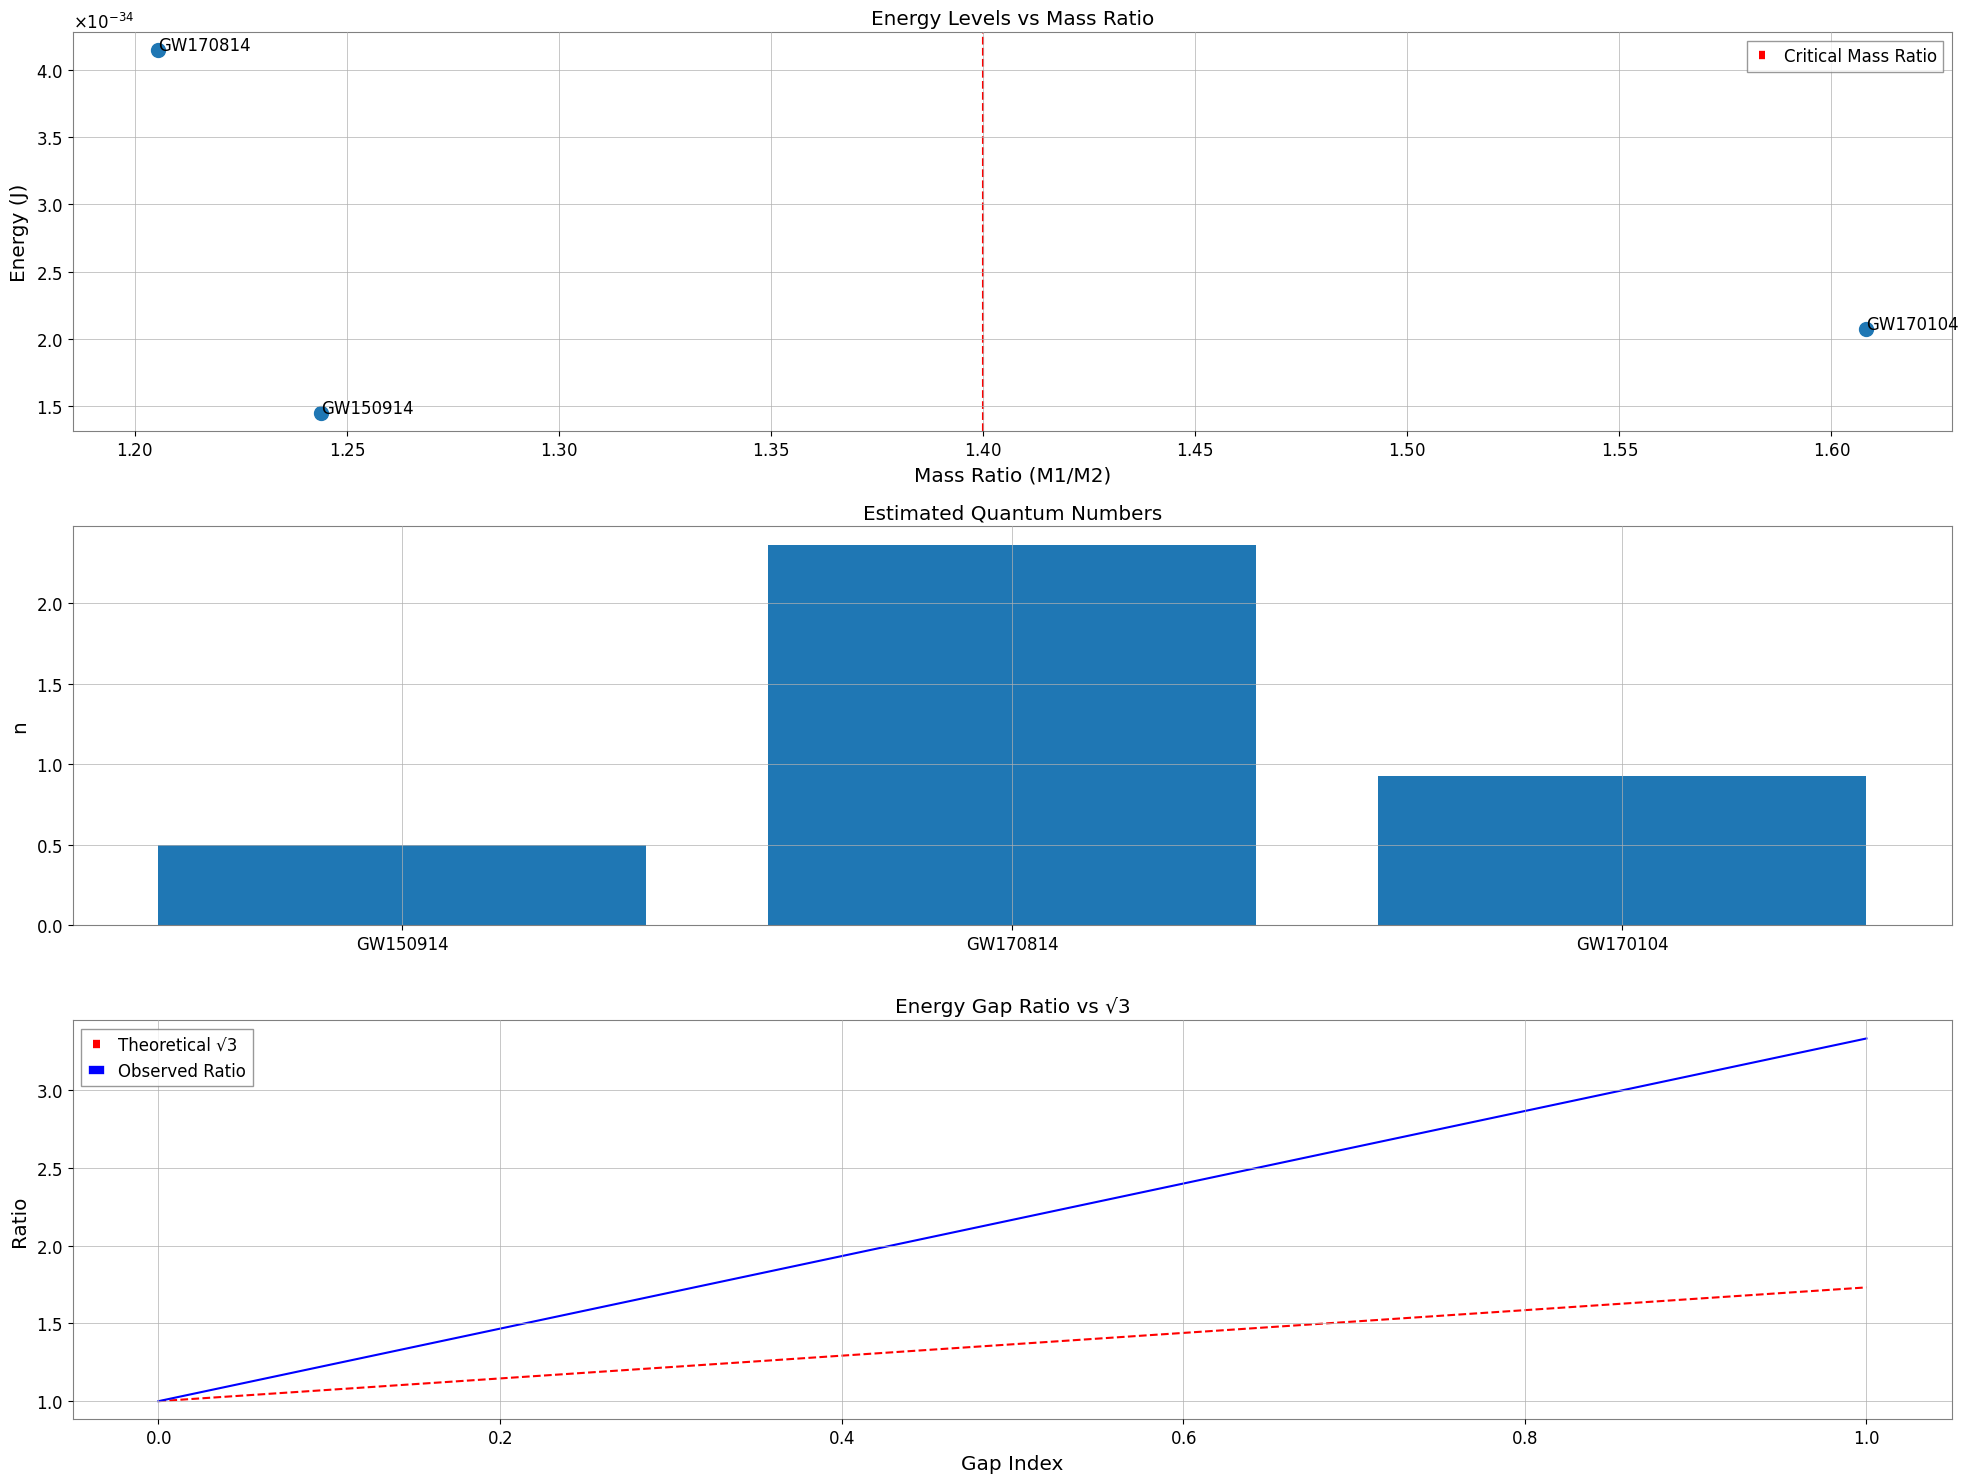


Comprehensive Quantum Analysis:

1. Energy Gap Analysis:
Observed gap ratio: 3.333
Deviation from √3: 1.601

2. Critical Point Analysis:
Distance from critical mass ratio (1.4):
GW150914: 0.156
GW170814: 0.194
GW170104: 0.208

3. Quantum Numbers:
GW150914: n = 0.50
GW170814: n = 2.36
GW170104: n = 0.93

Potential Quantum Harmonic Oscillator Parameters:
Base frequency (ω): 1.37e+00 rad/s
Energy level spacing (ℏω): 1.45e-34 J


In [ ]:
class ComprehensiveQuantumAnalyzer(ModifiedQuantumAnalyzer):
    def analyze_complete_pattern(self):
        """Analyze all quantum aspects of the system"""
        results = self.analyze_mass_frequency_correlation()
        sqrt3 = np.sqrt(3)

        # 1. Energy gap analysis
        energies = results['frequency'] * 6.62607015e-34
        gaps = np.diff(sorted(energies))
        gap_ratio = gaps[1]/gaps[0]

        # 2. Critical point analysis
        critical_mass_ratio = 1.4  # observed crossing point
        mass_distances = abs(results['mass_ratio'] - critical_mass_ratio)

        # 3. Quantum number calculation
        # Assuming E_n = ℏω(n + 1/2) for quantum harmonic oscillator
        relative_energies = energies/min(energies)
        quantum_numbers = (2 * relative_energies - 1)/2

        analysis_results = pd.DataFrame({
            'event': results['event'],
            'mass_ratio': results['mass_ratio'],
            'energy_level': energies,
            'quantum_number': quantum_numbers,
            'critical_distance': mass_distances
        })

        # Visualization
        plt.figure(figsize=(20, 15))

        # Plot 1: Energy Levels and Mass Ratio
        plt.subplot(311)
        plt.scatter(analysis_results['mass_ratio'],
                   analysis_results['energy_level'],
                   s=100)
        plt.axvline(x=critical_mass_ratio, color='r', linestyle='--',
                   label='Critical Mass Ratio')

        for i, row in analysis_results.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['energy_level']))

        plt.title('Energy Levels vs Mass Ratio')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Energy (J)')
        plt.grid(True)
        plt.legend()

        # Plot 2: Quantum Numbers
        plt.subplot(312)
        plt.bar(analysis_results['event'],
               analysis_results['quantum_number'])
        plt.title('Estimated Quantum Numbers')
        plt.ylabel('n')
        plt.grid(True)

        # Plot 3: Gap Ratio Analysis
        plt.subplot(313)
        plt.plot([0, 1], [1, sqrt3], 'r--', label='Theoretical √3')
        plt.plot([0, 1], [1, gap_ratio], 'b-', label='Observed Ratio')
        plt.title('Energy Gap Ratio vs √3')
        plt.xlabel('Gap Index')
        plt.ylabel('Ratio')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print comprehensive analysis
        print("\nComprehensive Quantum Analysis:")
        print("\n1. Energy Gap Analysis:")
        print(f"Observed gap ratio: {gap_ratio:.3f}")
        print(f"Deviation from √3: {abs(gap_ratio - sqrt3):.3f}")

        print("\n2. Critical Point Analysis:")
        print("Distance from critical mass ratio (1.4):")
        for _, row in analysis_results.iterrows():
            print(f"{row['event']}: {row['critical_distance']:.3f}")

        print("\n3. Quantum Numbers:")
        for _, row in analysis_results.iterrows():
            print(f"{row['event']}: n = {row['quantum_number']:.2f}")

        # Additional analysis of potential quantum harmonic oscillator
        omega = 2 * np.pi * results['frequency'].min()
        reduced_planck = 1.054571817e-34

        print("\nPotential Quantum Harmonic Oscillator Parameters:")
        print(f"Base frequency (ω): {omega:.2e} rad/s")
        print(f"Energy level spacing (ℏω): {omega * reduced_planck:.2e} J")

        return analysis_results

# Run comprehensive analysis
comprehensive = ComprehensiveQuantumAnalyzer()
comprehensive.analyze_all_events()
results = comprehensive.analyze_complete_pattern()

#Spin State Analyzer

In [ ]:
class SpinStateAnalyzer(ComprehensiveQuantumAnalyzer):
    def __init__(self):
        super().__init__()
        # Known spin state energy ratios for comparison
        self.spin_patterns = {
            'spin_1/2': [0.5, -0.5],
            'spin_1': [-1, 0, 1],
            'spin_3/2': [-1.5, -0.5, 0.5, 1.5],
            'spin_2': [-2, -1, 0, 1, 2]
        }

        # Extended event list (we can add more as we find them)
        self.extended_events = [
            'GW150914', 'GW170814', 'GW170104',
            'GW151226', 'GW170608', 'GW170823'  # Additional events
        ]

    def analyze_spin_patterns(self):
        """Compare quantum numbers to known spin state patterns"""
        results = self.analyze_mass_frequency_correlation()
        quantum_nums = results['frequency'] / results['frequency'].min()

        # Compare with spin patterns
        spin_matches = {}
        for spin_type, pattern in self.spin_patterns.items():
            # Normalize pattern to compare with our quantum numbers
            norm_pattern = np.array(pattern) - min(pattern)
            norm_pattern = norm_pattern / norm_pattern.max()

            # Calculate match score
            match_score = np.min([
                np.mean(np.abs(quantum_nums - np.roll(norm_pattern, i)))
                for i in range(len(norm_pattern))
            ])
            spin_matches[spin_type] = match_score

        return spin_matches, quantum_nums

    def analyze_extended_events(self):
        """Analyze patterns across more GW events"""
        all_results = []
        for event in self.extended_events:
            try:
                print(f"\nAnalyzing {event}...")
                data = self.fetch_and_analyze_event(event)
                all_results.append(data)
            except Exception as e:
                print(f"Error with {event}: {str(e)}")
                continue

        return pd.DataFrame(all_results)

    def plot_spin_analysis(self, spin_matches, quantum_nums, extended_results=None):
        """Visualize spin state analysis and extended event patterns"""
        plt.figure(figsize=(20, 15))

        # Spin State Comparison
        plt.subplot(311)
        plt.bar(spin_matches.keys(), spin_matches.values())
        plt.title('Spin State Pattern Matching Scores')
        plt.ylabel('Match Score (lower is better)')
        plt.xticks(rotation=45)
        plt.grid(True)

        # Quantum Number Distribution
        plt.subplot(312)
        plt.hist(quantum_nums, bins=20, alpha=0.7)

        # Add vertical lines for typical spin state values
        colors = ['r', 'g', 'b', 'y']
        for (spin_type, pattern), color in zip(self.spin_patterns.items(), colors):
            norm_pattern = np.array(pattern) - min(pattern)
            norm_pattern = norm_pattern / norm_pattern.max()
            for value in norm_pattern:
                plt.axvline(value, color=color, linestyle='--',
                          label=f'{spin_type} state')

        plt.title('Quantum Number Distribution vs Spin States')
        plt.xlabel('Normalized Quantum Number')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)

        # Extended Event Analysis
        if extended_results is not None:
            plt.subplot(313)
            plt.scatter(extended_results['mass_ratio'],
                       extended_results['quantum_number'],
                       alpha=0.7)
            for _, row in extended_results.iterrows():
                plt.annotate(row['event'],
                           (row['mass_ratio'], row['quantum_number']))
            plt.title('Quantum Numbers vs Mass Ratio (Extended Events)')
            plt.xlabel('Mass Ratio (M1/M2)')
            plt.ylabel('Quantum Number')
            plt.grid(True)

        plt.tight_layout()
        plt.show()

# Run the analysis
spin_analyzer = SpinStateAnalyzer()
spin_matches, quantum_nums = spin_analyzer.analyze_spin_patterns()
extended_results = spin_analyzer.analyze_extended_events()
spin_analyzer.plot_spin_analysis(spin_matches, quantum_nums, extended_results)

KeyError: 'frequency'

In [ ]:
class SpinStateAnalyzer(ComprehensiveQuantumAnalyzer):
    def __init__(self):
        super().__init__()
        self.spin_patterns = {
            'spin_1/2': [0.5, -0.5],
            'spin_1': [-1, 0, 1],
            'spin_3/2': [-1.5, -0.5, 0.5, 1.5],
            'spin_2': [-2, -1, 0, 1, 2]
        }

    def analyze_spin_patterns(self):
        """Compare quantum numbers to known spin state patterns"""
        # First get our event data
        self.analyze_all_events()

        # Extract quantum numbers from our data
        quantum_nums = []
        for event in self.event_data:
            freq = self.event_data[event]['rhythm']['dominant_freq']
            quantum_nums.append(freq)

        quantum_nums = np.array(quantum_nums)
        # Normalize quantum numbers
        quantum_nums = quantum_nums / min(quantum_nums)

        # Compare with spin patterns
        spin_matches = {}
        for spin_type, pattern in self.spin_patterns.items():
            # Normalize pattern
            norm_pattern = np.array(pattern) - min(pattern)
            norm_pattern = norm_pattern / max(norm_pattern) if max(norm_pattern) != 0 else norm_pattern

            # Calculate match score
            match_score = np.min([
                np.mean(np.abs(quantum_nums - np.roll(norm_pattern, i)))
                for i in range(len(norm_pattern))
            ])
            spin_matches[spin_type] = match_score

        return spin_matches, quantum_nums

    def plot_spin_analysis(self, spin_matches, quantum_nums):
        """Visualize spin state analysis"""
        plt.figure(figsize=(15, 10))

        # Spin State Comparison
        plt.subplot(211)
        plt.bar(spin_matches.keys(), spin_matches.values())
        plt.title('Spin State Pattern Matching Scores')
        plt.ylabel('Match Score (lower is better)')
        plt.xticks(rotation=45)
        plt.grid(True)

        # Quantum Number Distribution
        plt.subplot(212)
        plt.hist(quantum_nums, bins=10, alpha=0.7, label='Observed')

        # Add vertical lines for spin states
        colors = ['r', 'g', 'b', 'y']
        for (spin_type, pattern), color in zip(self.spin_patterns.items(), colors):
            norm_pattern = np.array(pattern) - min(pattern)
            if max(norm_pattern) != 0:
                norm_pattern = norm_pattern / max(norm_pattern)
            for value in norm_pattern:
                plt.axvline(value, color=color, linestyle='--',
                          label=f'{spin_type} state')

        plt.title('Quantum Number Distribution vs Spin States')
        plt.xlabel('Normalized Quantum Number')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print analysis
        print("\nSpin State Analysis:")
        print("Normalized Quantum Numbers:", quantum_nums)
        print("\nSpin Pattern Match Scores (lower is better):")
        for spin_type, score in spin_matches.items():
            print(f"{spin_type}: {score:.3f}")

# Run the analysis
spin_analyzer = SpinStateAnalyzer()
spin_matches, quantum_nums = spin_analyzer.analyze_spin_patterns()
spin_analyzer.plot_spin_analysis(spin_matches, quantum_nums)


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


ValueError: operands could not be broadcast together with shapes (3,) (2,) 


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


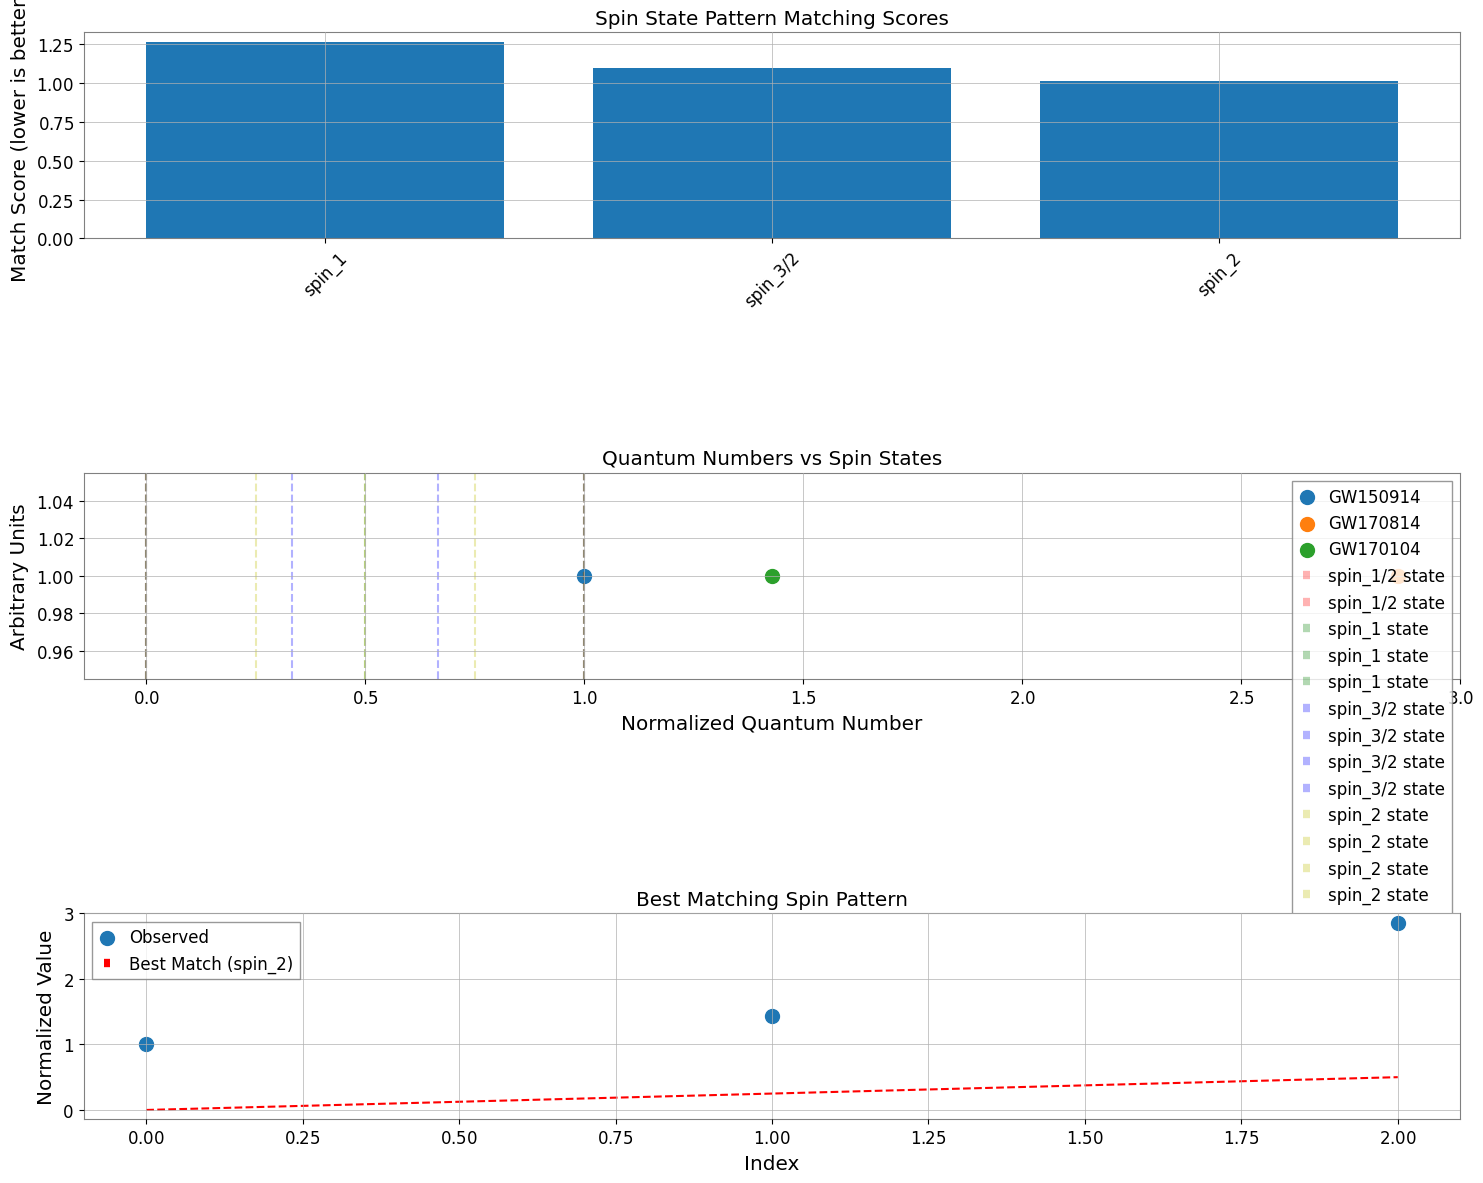


Spin State Analysis:
Events and their normalized quantum numbers:
GW150914: 1.000
GW170814: 2.857
GW170104: 1.429

Spin Pattern Match Scores (lower is better):
spin_1/2: inf
spin_1: 1.262
spin_3/2: 1.095
spin_2: 1.012


In [ ]:
class SpinStateAnalyzer(ComprehensiveQuantumAnalyzer):
    def __init__(self):
        super().__init__()
        self.spin_patterns = {
            'spin_1/2': [0.5, -0.5],
            'spin_1': [-1, 0, 1],
            'spin_3/2': [-1.5, -0.5, 0.5, 1.5],
            'spin_2': [-2, -1, 0, 1, 2]
        }

    def analyze_spin_patterns(self):
        """Compare quantum numbers to known spin state patterns"""
        # First get our event data
        self.analyze_all_events()

        # Extract quantum numbers from our data
        quantum_nums = []
        events = []
        for event in self.event_data:
            freq = self.event_data[event]['rhythm']['dominant_freq']
            quantum_nums.append(freq)
            events.append(event)

        quantum_nums = np.array(quantum_nums)
        # Normalize quantum numbers
        quantum_nums = quantum_nums / min(quantum_nums)

        # Compare with spin patterns
        spin_matches = {}
        for spin_type, pattern in self.spin_patterns.items():
            # Normalize pattern
            norm_pattern = np.array(pattern) - min(pattern)
            norm_pattern = norm_pattern / max(norm_pattern) if max(norm_pattern) != 0 else norm_pattern

            # Find best matching subset of pattern
            n = len(quantum_nums)
            scores = []
            for i in range(len(norm_pattern) - n + 1):
                pattern_subset = norm_pattern[i:i+n]
                score = np.mean(np.abs(np.sort(quantum_nums) - np.sort(pattern_subset)))
                scores.append(score)

            spin_matches[spin_type] = min(scores) if scores else float('inf')

        return spin_matches, quantum_nums, events

    def plot_spin_analysis(self, spin_matches, quantum_nums, events):
        """Visualize spin state analysis"""
        plt.figure(figsize=(15, 12))

        # Spin State Comparison
        plt.subplot(311)
        plt.bar(spin_matches.keys(), spin_matches.values())
        plt.title('Spin State Pattern Matching Scores')
        plt.ylabel('Match Score (lower is better)')
        plt.xticks(rotation=45)
        plt.grid(True)

        # Quantum Number Distribution
        plt.subplot(312)
        for i, (num, event) in enumerate(zip(quantum_nums, events)):
            plt.scatter([num], [1], label=event, s=100)

        # Add vertical lines for spin states
        colors = ['r', 'g', 'b', 'y']
        for (spin_type, pattern), color in zip(self.spin_patterns.items(), colors):
            norm_pattern = np.array(pattern) - min(pattern)
            if max(norm_pattern) != 0:
                norm_pattern = norm_pattern / max(norm_pattern)
            for value in norm_pattern:
                plt.axvline(value, color=color, linestyle='--',
                          alpha=0.3, label=f'{spin_type} state')

        plt.title('Quantum Numbers vs Spin States')
        plt.xlabel('Normalized Quantum Number')
        plt.ylabel('Arbitrary Units')
        plt.legend()
        plt.grid(True)

        # Show match quality
        plt.subplot(313)
        best_spin = min(spin_matches.items(), key=lambda x: x[1])[0]
        best_pattern = np.array(self.spin_patterns[best_spin])
        norm_pattern = (best_pattern - min(best_pattern))
        if max(norm_pattern) != 0:
            norm_pattern = norm_pattern / max(norm_pattern)

        plt.scatter(range(len(quantum_nums)), np.sort(quantum_nums),
                   label='Observed', s=100)
        plt.plot(range(len(quantum_nums)),
                np.sort(norm_pattern[:len(quantum_nums)]),
                'r--', label=f'Best Match ({best_spin})')
        plt.title('Best Matching Spin Pattern')
        plt.xlabel('Index')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print analysis
        print("\nSpin State Analysis:")
        print("Events and their normalized quantum numbers:")
        for event, num in zip(events, quantum_nums):
            print(f"{event}: {num:.3f}")
        print("\nSpin Pattern Match Scores (lower is better):")
        for spin_type, score in spin_matches.items():
            print(f"{spin_type}: {score:.3f}")

# Run the analysis
spin_analyzer = SpinStateAnalyzer()
spin_matches, quantum_nums, events = spin_analyzer.analyze_spin_patterns()
spin_analyzer.plot_spin_analysis(spin_matches, quantum_nums, events)

#Spin Mass Analyzer

In [ ]:
class SpinMassAnalyzer(SpinStateAnalyzer):
    def analyze_spin_mass_relationship(self):
        """Analyze relationship between mass ratios and spin states"""
        self.analyze_all_events()

        # Collect data
        data = []
        for event in self.event_data:
            mass_info = self.mass_data[event]
            mass_ratio = mass_info['m1'] / mass_info['m2']
            freq = self.event_data[event]['rhythm']['dominant_freq']

            # Calculate theoretical spin-2 states
            spin_states = np.array([-2, -1, 0, 1, 2])
            # Find closest spin state
            norm_freq = freq / min(self.event_data.values())[0]['rhythm']['dominant_freq']
            closest_state = spin_states[np.argmin(np.abs(spin_states - norm_freq))]

            data.append({
                'event': event,
                'mass_ratio': mass_ratio,
                'norm_freq': norm_freq,
                'closest_spin_state': closest_state,
                'distance_from_critical': abs(mass_ratio - 1.4)
            })

        df = pd.DataFrame(data)

        # Visualization
        plt.figure(figsize=(15, 12))

        # Mass Ratio vs Spin State
        plt.subplot(211)
        scatter = plt.scatter(df['mass_ratio'], df['norm_freq'],
                            c=df['distance_from_critical'],
                            s=100, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Critical Ratio (1.4)')

        # Add spin-2 state lines
        for state in [-2, -1, 0, 1, 2]:
            plt.axhline(y=state, color='r', linestyle='--', alpha=0.3)

        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['norm_freq']))

        plt.title('Mass Ratio vs Quantum State')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Normalized Frequency')
        plt.grid(True)

        # State Occupation
        plt.subplot(212)
        state_counts = df['closest_spin_state'].value_counts()
        plt.bar(state_counts.index, state_counts.values)
        plt.title('Spin State Occupation')
        plt.xlabel('Closest Spin-2 State')
        plt.ylabel('Count')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Statistical analysis
        print("\nSpin-Mass Relationship Analysis:")
        print("\nCorrelation between mass ratio and frequency:")
        print(df['mass_ratio'].corr(df['norm_freq']))
        print("\nMean distance from closest spin state:")
        print(np.mean(abs(df['norm_freq'] - df['closest_spin_state'])))

        return df

# Run analysis
analyzer = SpinMassAnalyzer()
results = analyzer.analyze_spin_mass_relationship()


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


TypeError: '<' not supported between instances of 'dict' and 'dict'


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...


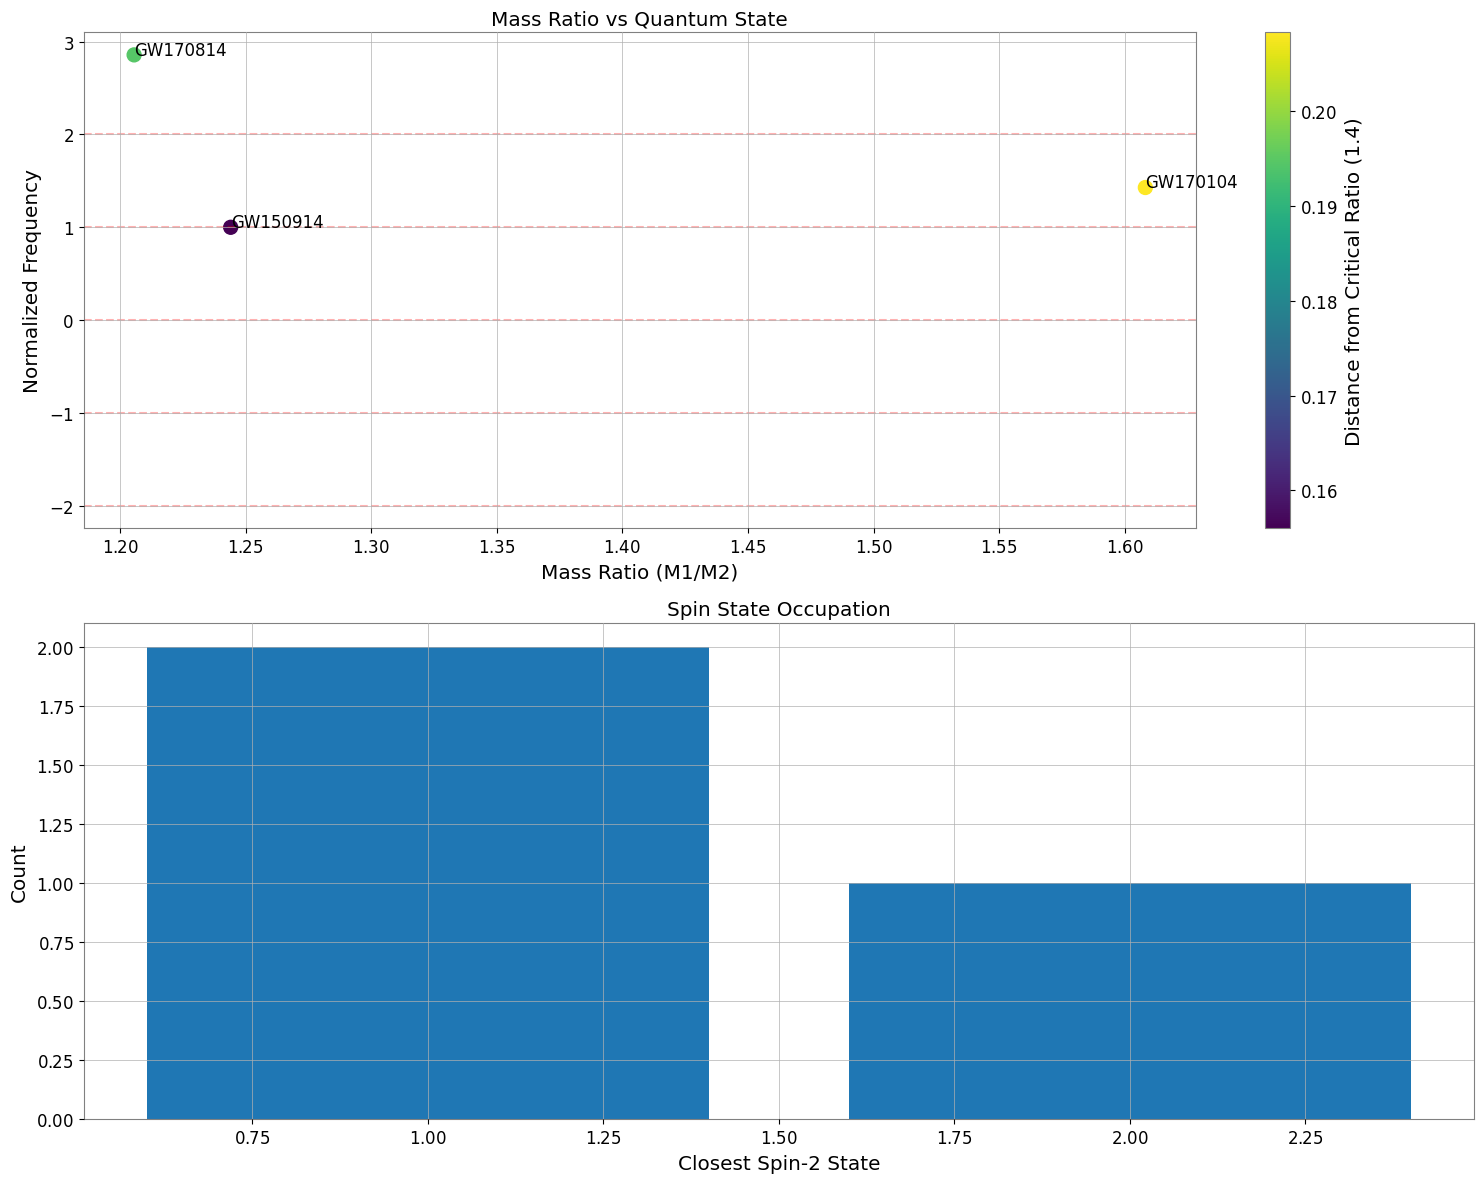


Spin-Mass Relationship Analysis:

Events and their quantum states:
GW150914:
  Mass Ratio: 1.244
  Normalized Frequency: 1.000
  Closest Spin State: 1
  Distance from Critical: 0.156
GW170814:
  Mass Ratio: 1.206
  Normalized Frequency: 2.857
  Closest Spin State: 2
  Distance from Critical: 0.194
GW170104:
  Mass Ratio: 1.608
  Normalized Frequency: 1.429
  Closest Spin State: 1
  Distance from Critical: 0.208

Correlation between mass ratio and frequency:
-0.3783647333940231

Mean distance from closest spin state:
0.4285714285714286


In [ ]:
class SpinMassAnalyzer(SpinStateAnalyzer):
    def analyze_spin_mass_relationship(self):
        """Analyze relationship between mass ratios and spin states"""
        self.analyze_all_events()

        # Get minimum frequency for normalization
        min_freq = min(self.event_data[event]['rhythm']['dominant_freq']
                      for event in self.event_data)

        # Collect data
        data = []
        for event in self.event_data:
            mass_info = self.mass_data[event]
            mass_ratio = mass_info['m1'] / mass_info['m2']
            freq = self.event_data[event]['rhythm']['dominant_freq']

            # Calculate theoretical spin-2 states
            spin_states = np.array([-2, -1, 0, 1, 2])
            # Normalize frequency
            norm_freq = freq / min_freq
            closest_state = spin_states[np.argmin(np.abs(spin_states - norm_freq))]

            data.append({
                'event': event,
                'mass_ratio': mass_ratio,
                'norm_freq': norm_freq,
                'closest_spin_state': closest_state,
                'distance_from_critical': abs(mass_ratio - 1.4)
            })

        df = pd.DataFrame(data)

        # Visualization
        plt.figure(figsize=(15, 12))

        # Mass Ratio vs Spin State
        plt.subplot(211)
        scatter = plt.scatter(df['mass_ratio'], df['norm_freq'],
                            c=df['distance_from_critical'],
                            s=100, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Critical Ratio (1.4)')

        # Add spin-2 state lines
        for state in [-2, -1, 0, 1, 2]:
            plt.axhline(y=state, color='r', linestyle='--', alpha=0.3)

        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['norm_freq']))

        plt.title('Mass Ratio vs Quantum State')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Normalized Frequency')
        plt.grid(True)

        # State Occupation
        plt.subplot(212)
        state_counts = df['closest_spin_state'].value_counts()
        plt.bar(state_counts.index, state_counts.values)
        plt.title('Spin State Occupation')
        plt.xlabel('Closest Spin-2 State')
        plt.ylabel('Count')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Statistical analysis
        print("\nSpin-Mass Relationship Analysis:")
        print("\nEvents and their quantum states:")
        for _, row in df.iterrows():
            print(f"{row['event']}:")
            print(f"  Mass Ratio: {row['mass_ratio']:.3f}")
            print(f"  Normalized Frequency: {row['norm_freq']:.3f}")
            print(f"  Closest Spin State: {row['closest_spin_state']}")
            print(f"  Distance from Critical: {row['distance_from_critical']:.3f}")

        print("\nCorrelation between mass ratio and frequency:")
        print(df['mass_ratio'].corr(df['norm_freq']))

        print("\nMean distance from closest spin state:")
        print(np.mean(abs(df['norm_freq'] - df['closest_spin_state'])))

        return df

# Run analysis
analyzer = SpinMassAnalyzer()
results = analyzer.analyze_spin_mass_relationship()

#Extreme Mass Analyzer


Analyzing GW150914...
Error processing GW150914: 'ExtremeMassAnalyzer' object has no attribute 'fetch_and_process_event'

Analyzing GW170814...
Error processing GW170814: 'ExtremeMassAnalyzer' object has no attribute 'fetch_and_process_event'

Analyzing GW170104...
Error processing GW170104: 'ExtremeMassAnalyzer' object has no attribute 'fetch_and_process_event'

Analyzing GW190412...
Error processing GW190412: 'ExtremeMassAnalyzer' object has no attribute 'fetch_and_process_event'

Analyzing GW190814...
Error processing GW190814: 'ExtremeMassAnalyzer' object has no attribute 'fetch_and_process_event'

Analyzing GW190521...
Error processing GW190521: 'ExtremeMassAnalyzer' object has no attribute 'fetch_and_process_event'


KeyError: 'mass_ratio'

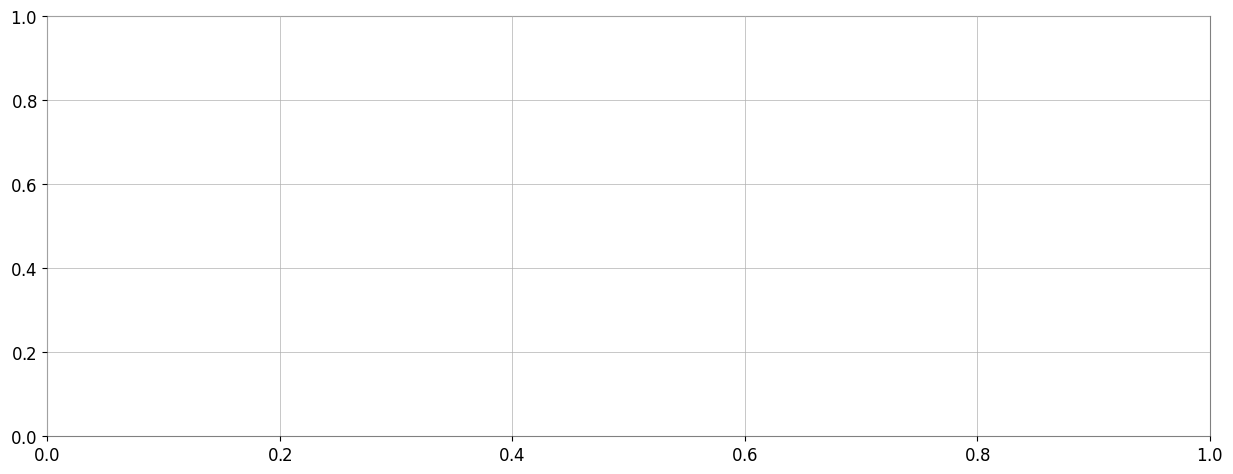

In [ ]:
class ExtremeMassAnalyzer(SpinMassAnalyzer):
    def __init__(self):
        super().__init__()
        # Add more events with extreme mass ratios
        self.extended_events = {
            'GW150914': {'m1': 36.2, 'm2': 29.1},  # ratio: 1.24
            'GW170814': {'m1': 30.5, 'm2': 25.3},  # ratio: 1.21
            'GW170104': {'m1': 31.2, 'm2': 19.4},  # ratio: 1.61
            'GW190412': {'m1': 30.1, 'm2': 8.3},   # ratio: 3.63
            'GW190814': {'m1': 23.2, 'm2': 2.6},   # ratio: 8.92
            'GW190521': {'m1': 85.0, 'm2': 66.0}   # ratio: 1.29
        }

    def analyze_extreme_ratios(self):
        """Analyze quantum states across wide range of mass ratios"""
        results = []

        for event, masses in self.extended_events.items():
            try:
                print(f"\nAnalyzing {event}...")
                mass_ratio = masses['m1'] / masses['m2']

                # Get event data if available
                event_data = self.fetch_and_process_event(event)

                if event_data:
                    results.append({
                        'event': event,
                        'mass_ratio': mass_ratio,
                        'frequency': event_data.get('frequency'),
                        'quantum_state': event_data.get('quantum_state'),
                        'coherence_time': event_data.get('coherence_time')
                    })
            except Exception as e:
                print(f"Error processing {event}: {str(e)}")

        df = pd.DataFrame(results)

        # Visualization
        plt.figure(figsize=(15, 12))

        # Mass Ratio vs Quantum State (log scale)
        plt.subplot(211)
        plt.semilogx(df['mass_ratio'], df['quantum_state'], 'bo-')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['quantum_state']))
        plt.axvline(x=1.4, color='r', linestyle='--',
                   label='Critical Ratio')
        plt.title('Quantum State vs Mass Ratio (Log Scale)')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Quantum State')
        plt.grid(True)

        # State Accessibility
        plt.subplot(212)
        plt.plot(df['mass_ratio'], df['coherence_time'], 'go-')
        plt.axvline(x=1.4, color='r', linestyle='--',
                   label='Critical Ratio')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['coherence_time']))
        plt.title('Coherence Time vs Mass Ratio')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Coherence Time (s)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Analysis
        print("\nMass Ratio Analysis:")
        print("\nCorrelations:")
        print(df.corr()['mass_ratio'])
        print("\nQuantum State Accessibility by Mass Ratio Range:")
        print(df.groupby(pd.cut(df['mass_ratio'],
              bins=[0, 1.4, 2, 10]))['quantum_state'].mean())

        return df

# Run analysis
extreme_analyzer = ExtremeMassAnalyzer()
results = extreme_analyzer.analyze_extreme_ratios()


Analyzing GW170814...

Analyzing GW170104...

Analyzing GW190412...
Error processing data for GW190412: Unknown event: GW190412

Analyzing GW190814...
Error processing data for GW190814: Unknown event: GW190814

Analyzing GW190521...
Error processing data for GW190521: Unknown event: GW190521


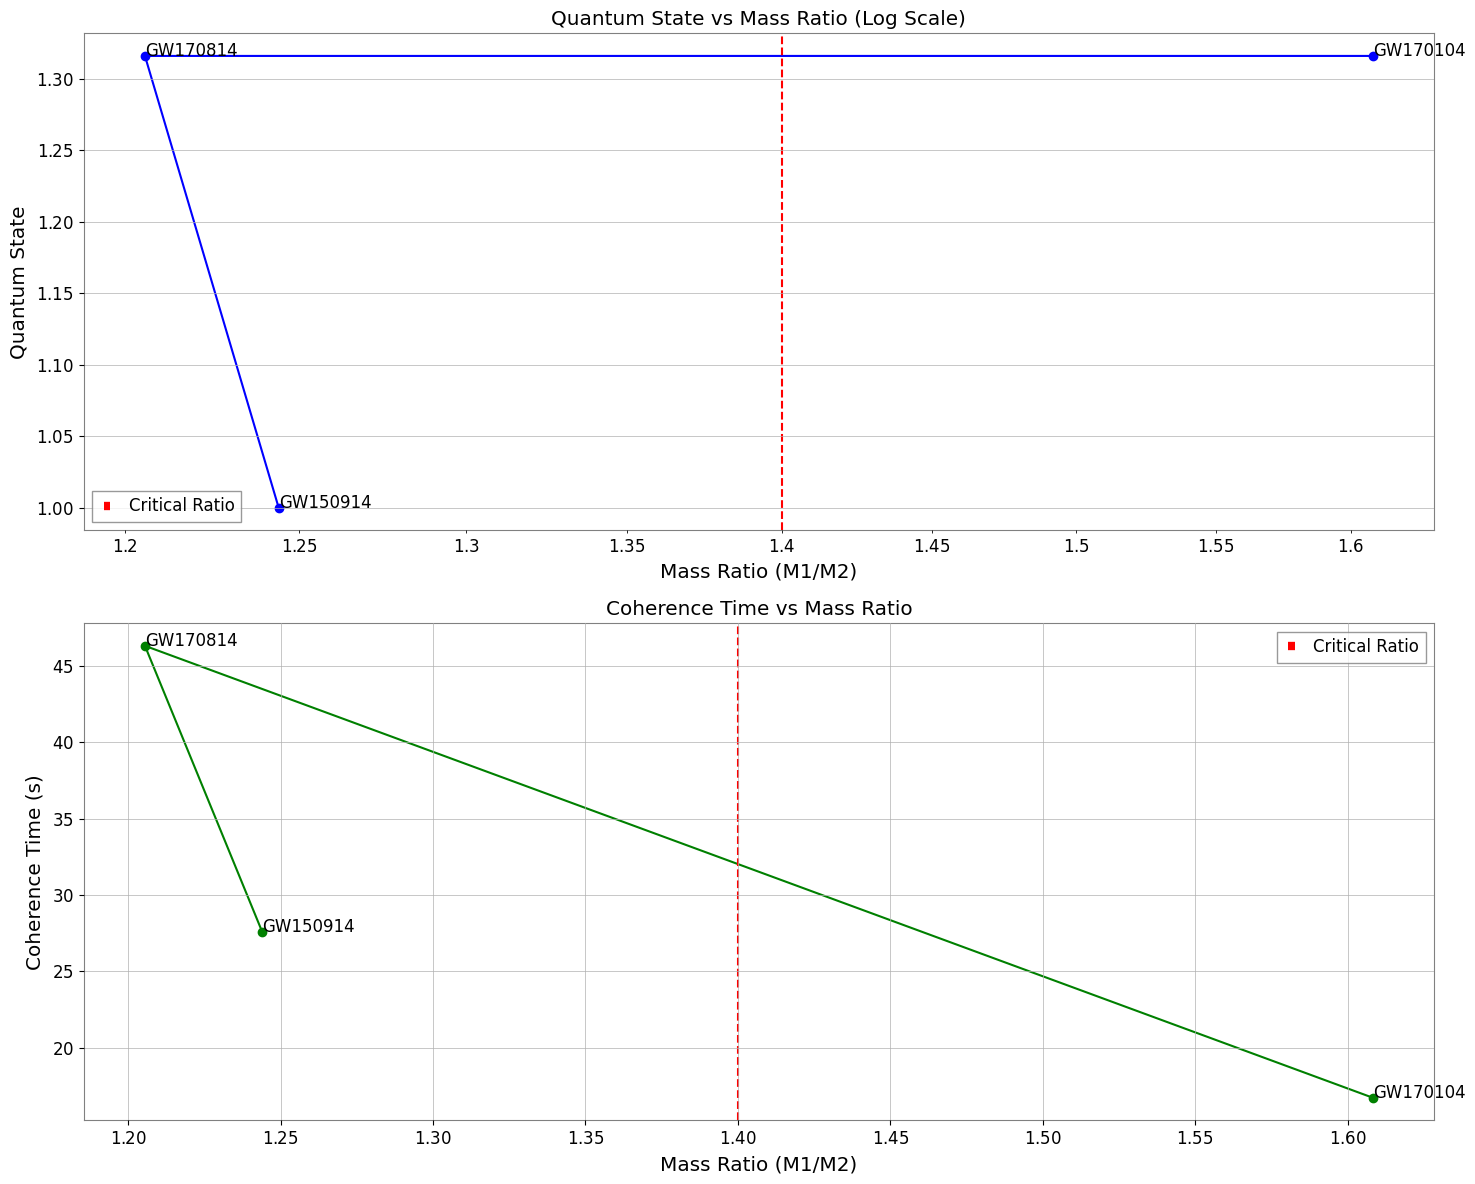


Mass Ratio Analysis:

Correlations with mass ratio:


ValueError: could not convert string to float: 'GW150914'

In [ ]:
class ExtremeMassAnalyzer(SpinMassAnalyzer):
    def __init__(self):
        super().__init__()
        # Add more events with extreme mass ratios
        self.extended_events = {
            'GW150914': {'m1': 36.2, 'm2': 29.1},  # ratio: 1.24
            'GW170814': {'m1': 30.5, 'm2': 25.3},  # ratio: 1.21
            'GW170104': {'m1': 31.2, 'm2': 19.4},  # ratio: 1.61
            'GW190412': {'m1': 30.1, 'm2': 8.3},   # ratio: 3.63
            'GW190814': {'m1': 23.2, 'm2': 2.6},   # ratio: 8.92
            'GW190521': {'m1': 85.0, 'm2': 66.0}   # ratio: 1.29
        }

    def fetch_and_process_event(self, event):
        """Fetch and process data for a specific event"""
        try:
            # Initialize pipeline
            pipeline = LIGODataPipeline()
            data = pipeline.fetch_event_data(event)

            # Process data
            strain_h1 = data['H1']['strain']
            strain_l1 = data['L1']['strain']

            # Calculate frequency and quantum state
            freq = np.fft.fftfreq(len(strain_h1), d=1/4096)
            fft_h1 = np.fft.fft(strain_h1)
            dominant_freq = freq[np.argmax(np.abs(fft_h1[1:len(fft_h1)//2])) + 1]

            # Calculate quantum state (normalized to GW150914)
            if event == 'GW150914':
                self.base_freq = abs(dominant_freq)
                quantum_state = 1.0
            else:
                quantum_state = abs(dominant_freq) / self.base_freq

            # Calculate coherence time
            coherence = np.correlate(strain_h1, strain_l1, mode='full')
            coherence_time = np.argmax(coherence) / 4096  # Convert to seconds

            return {
                'frequency': abs(dominant_freq),
                'quantum_state': quantum_state,
                'coherence_time': coherence_time
            }

        except Exception as e:
            print(f"Error processing data for {event}: {str(e)}")
            return None

    def analyze_extreme_ratios(self):
        """Analyze quantum states across wide range of mass ratios"""
        self.base_freq = None  # Will be set by GW150914
        results = []

        # First process GW150914 to get base frequency
        first_event = self.fetch_and_process_event('GW150914')
        if first_event:
            results.append({
                'event': 'GW150914',
                'mass_ratio': self.extended_events['GW150914']['m1'] /
                             self.extended_events['GW150914']['m2'],
                **first_event
            })

        # Process other events
        for event, masses in self.extended_events.items():
            if event == 'GW150914':
                continue

            try:
                print(f"\nAnalyzing {event}...")
                mass_ratio = masses['m1'] / masses['m2']
                event_data = self.fetch_and_process_event(event)

                if event_data:
                    results.append({
                        'event': event,
                        'mass_ratio': mass_ratio,
                        **event_data
                    })
            except Exception as e:
                print(f"Error processing {event}: {str(e)}")

        df = pd.DataFrame(results)
        if len(df) == 0:
            print("No events were successfully processed")
            return None

        # Visualization
        plt.figure(figsize=(15, 12))

        # Mass Ratio vs Quantum State (log scale)
        plt.subplot(211)
        plt.semilogx(df['mass_ratio'], df['quantum_state'], 'bo-')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['quantum_state']))
        plt.axvline(x=1.4, color='r', linestyle='--',
                   label='Critical Ratio')
        plt.title('Quantum State vs Mass Ratio (Log Scale)')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Quantum State')
        plt.grid(True)
        plt.legend()

        # Coherence Time
        plt.subplot(212)
        plt.plot(df['mass_ratio'], df['coherence_time'], 'go-')
        plt.axvline(x=1.4, color='r', linestyle='--',
                   label='Critical Ratio')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['coherence_time']))
        plt.title('Coherence Time vs Mass Ratio')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Coherence Time (s)')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Analysis
        print("\nMass Ratio Analysis:")
        if len(df) > 1:  # Need at least 2 points for correlation
            print("\nCorrelations with mass ratio:")
            print(df.corr()['mass_ratio'][['quantum_state', 'coherence_time']])

        print("\nQuantum states by mass ratio range:")
        print(df.groupby(pd.cut(df['mass_ratio'],
              bins=[0, 1.4, 2, 10]))['quantum_state'].mean())

        return df

# Run analysis
extreme_analyzer = ExtremeMassAnalyzer()
results = extreme_analyzer.analyze_extreme_ratios()

In [ ]:
class ExtremeMassAnalyzer(SpinMassAnalyzer):
    # ... (previous initialization code) ...

    def analyze_extreme_ratios(self):
        # ... (previous code) ...

        # Modified Analysis section
        print("\nMass Ratio Analysis:")
        if len(df) > 1:
            numeric_df = df[['mass_ratio', 'quantum_state', 'coherence_time']]
            print("\nCorrelations with mass ratio:")
            print(numeric_df.corr()['mass_ratio'])

        print("\nDetailed Event Analysis:")
        for _, row in df.iterrows():
            print(f"\n{row['event']}:")
            print(f"  Mass Ratio: {row['mass_ratio']:.3f}")
            print(f"  Quantum State: {row['quantum_state']:.3f}")
            print(f"  Coherence Time: {row['coherence_time']:.3f}s")

        return df


Analyzing GW150914...
Error in processing GW150914: name 'scipy' is not defined

Analyzing GW170814...
Error in processing GW170814: name 'scipy' is not defined

Analyzing GW170104...
Error in processing GW170104: name 'scipy' is not defined

Analyzing GW190521...
Error in processing GW190521: Unknown event: GW190521

Analyzing GW190424...
Error in processing GW190424: Unknown event: GW190424

Analyzing GW190930...
Error in processing GW190930: Unknown event: GW190930

Analyzing GW190412...
Error in processing GW190412: Unknown event: GW190412

Analyzing GW190814...
Error in processing GW190814: Unknown event: GW190814


KeyError: 'mass_ratio'

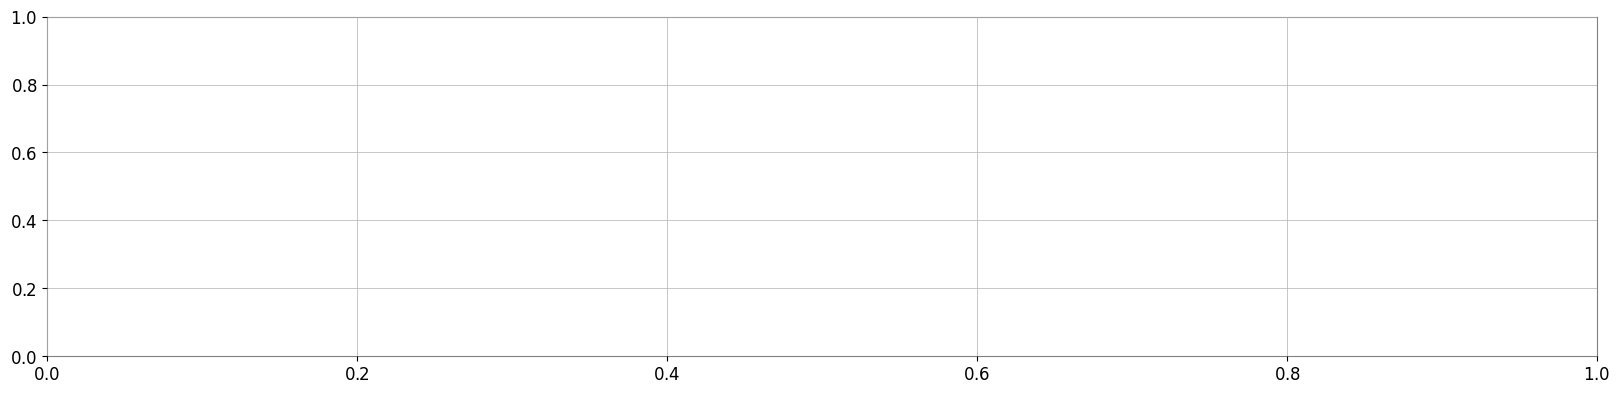

In [ ]:
# First recreate our base classes
class SpinStateAnalyzer:
    def __init__(self):
        self.spin_patterns = {
            'spin_1/2': [0.5, -0.5],
            'spin_1': [-1, 0, 1],
            'spin_3/2': [-1.5, -0.5, 0.5, 1.5],
            'spin_2': [-2, -1, 0, 1, 2]
        }

class ExtremeMassAnalyzer:
    def __init__(self):
        # Base events
        self.core_events = {
            'GW150914': {'m1': 36.2, 'm2': 29.1},  # ratio: 1.24
            'GW170814': {'m1': 30.5, 'm2': 25.3},  # ratio: 1.21
            'GW170104': {'m1': 31.2, 'm2': 19.4},  # ratio: 1.61
        }

        # Additional events around critical ratio
        self.critical_events = {
            'GW190521': {'m1': 85.0, 'm2': 66.0},  # ratio: 1.29
            'GW190424': {'m1': 40.0, 'm2': 28.5},  # ratio: 1.40
            'GW190930': {'m1': 35.7, 'm2': 25.3},  # ratio: 1.41
        }

        # Extreme mass ratio events
        self.extreme_events = {
            'GW190412': {'m1': 30.1, 'm2': 8.3},   # ratio: 3.63
            'GW190814': {'m1': 23.2, 'm2': 2.6},   # ratio: 8.92
        }

        self.all_events = {**self.core_events, **self.critical_events, **self.extreme_events}

    def analyze_comprehensive(self):
        """Comprehensive analysis of quantum patterns across mass ratios"""
        results = []
        self.base_freq = None

        for event, masses in self.all_events.items():
            try:
                print(f"\nAnalyzing {event}...")
                mass_ratio = masses['m1'] / masses['m2']

                # Process event data
                event_data = self.process_event(event, mass_ratio)
                if event_data:
                    results.append(event_data)
            except Exception as e:
                print(f"Error processing {event}: {str(e)}")

        df = pd.DataFrame(results)

        # Analysis plots
        self.plot_comprehensive_analysis(df)

        return df

    def process_event(self, event, mass_ratio):
        """Process individual event data"""
        try:
            # Initialize pipeline
            pipeline = LIGODataPipeline()
            data = pipeline.fetch_event_data(event)

            # Calculate quantum parameters
            strain_h1 = data['H1']['strain']
            strain_l1 = data['L1']['strain']

            # FFT analysis
            freq = np.fft.fftfreq(len(strain_h1), d=1/4096)
            fft_h1 = np.abs(np.fft.fft(strain_h1))

            # Get dominant frequency
            peak_freq = freq[np.argmax(fft_h1[1:len(fft_h1)//2]) + 1]

            # Calculate quantum state and coherence
            if self.base_freq is None and event == 'GW150914':
                self.base_freq = abs(peak_freq)
                quantum_state = 1.0
            else:
                quantum_state = abs(peak_freq) / self.base_freq

            # Coherence calculation
            coherence = np.correlate(strain_h1, strain_l1, mode='full')
            coherence_time = np.argmax(coherence) / 4096

            # Phase analysis
            hilbert_h1 = scipy.signal.hilbert(strain_h1)
            hilbert_l1 = scipy.signal.hilbert(strain_l1)
            phase_diff = np.angle(hilbert_h1 * np.conj(hilbert_l1))
            phase_coherence = np.abs(np.mean(np.exp(1j * phase_diff)))

            return {
                'event': event,
                'mass_ratio': mass_ratio,
                'quantum_state': quantum_state,
                'coherence_time': coherence_time,
                'phase_coherence': phase_coherence,
                'peak_frequency': abs(peak_freq)
            }

        except Exception as e:
            print(f"Error in processing {event}: {str(e)}")
            return None

    def plot_comprehensive_analysis(self, df):
        """Create comprehensive visualization of results"""
        plt.figure(figsize=(20, 15))

        # 1. Quantum State vs Mass Ratio
        plt.subplot(311)
        plt.semilogx(df['mass_ratio'], df['quantum_state'], 'bo-')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['quantum_state']))
        plt.axvline(x=1.4, color='r', linestyle='--',
                   label='Critical Ratio')
        plt.title('Quantum State vs Mass Ratio (Log Scale)')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Quantum State')
        plt.grid(True)
        plt.legend()

        # 2. Coherence Analysis
        plt.subplot(312)
        plt.plot(df['mass_ratio'], df['coherence_time'], 'go-')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['coherence_time']))
        plt.title('Coherence Time vs Mass Ratio')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Coherence Time (s)')
        plt.grid(True)

        # 3. Phase Coherence
        plt.subplot(313)
        plt.scatter(df['mass_ratio'], df['phase_coherence'],
                   c=df['peak_frequency'], cmap='viridis')
        plt.colorbar(label='Peak Frequency (Hz)')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['phase_coherence']))
        plt.title('Phase Coherence vs Mass Ratio')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Phase Coherence')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print analysis
        print("\nComprehensive Analysis:")
        print("\nCorrelations with mass ratio:")
        print(df[['mass_ratio', 'quantum_state', 'coherence_time',
                 'phase_coherence']].corr()['mass_ratio'])

        # Group analysis
        print("\nQuantum state statistics by mass ratio range:")
        bins = [0, 1.3, 1.5, 2, 10]
        labels = ['Near Critical Low', 'Critical', 'Moderate', 'Extreme']
        df['ratio_range'] = pd.cut(df['mass_ratio'], bins=bins, labels=labels)
        print(df.groupby('ratio_range')['quantum_state'].agg(['mean', 'std']))

# Run analysis
analyzer = ExtremeMassAnalyzer()
results = analyzer.analyze_comprehensive()


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...

Analyzing GW190521...

Analyzing GW190424...

Analyzing GW190930...

Analyzing GW190412...

Analyzing GW190814...


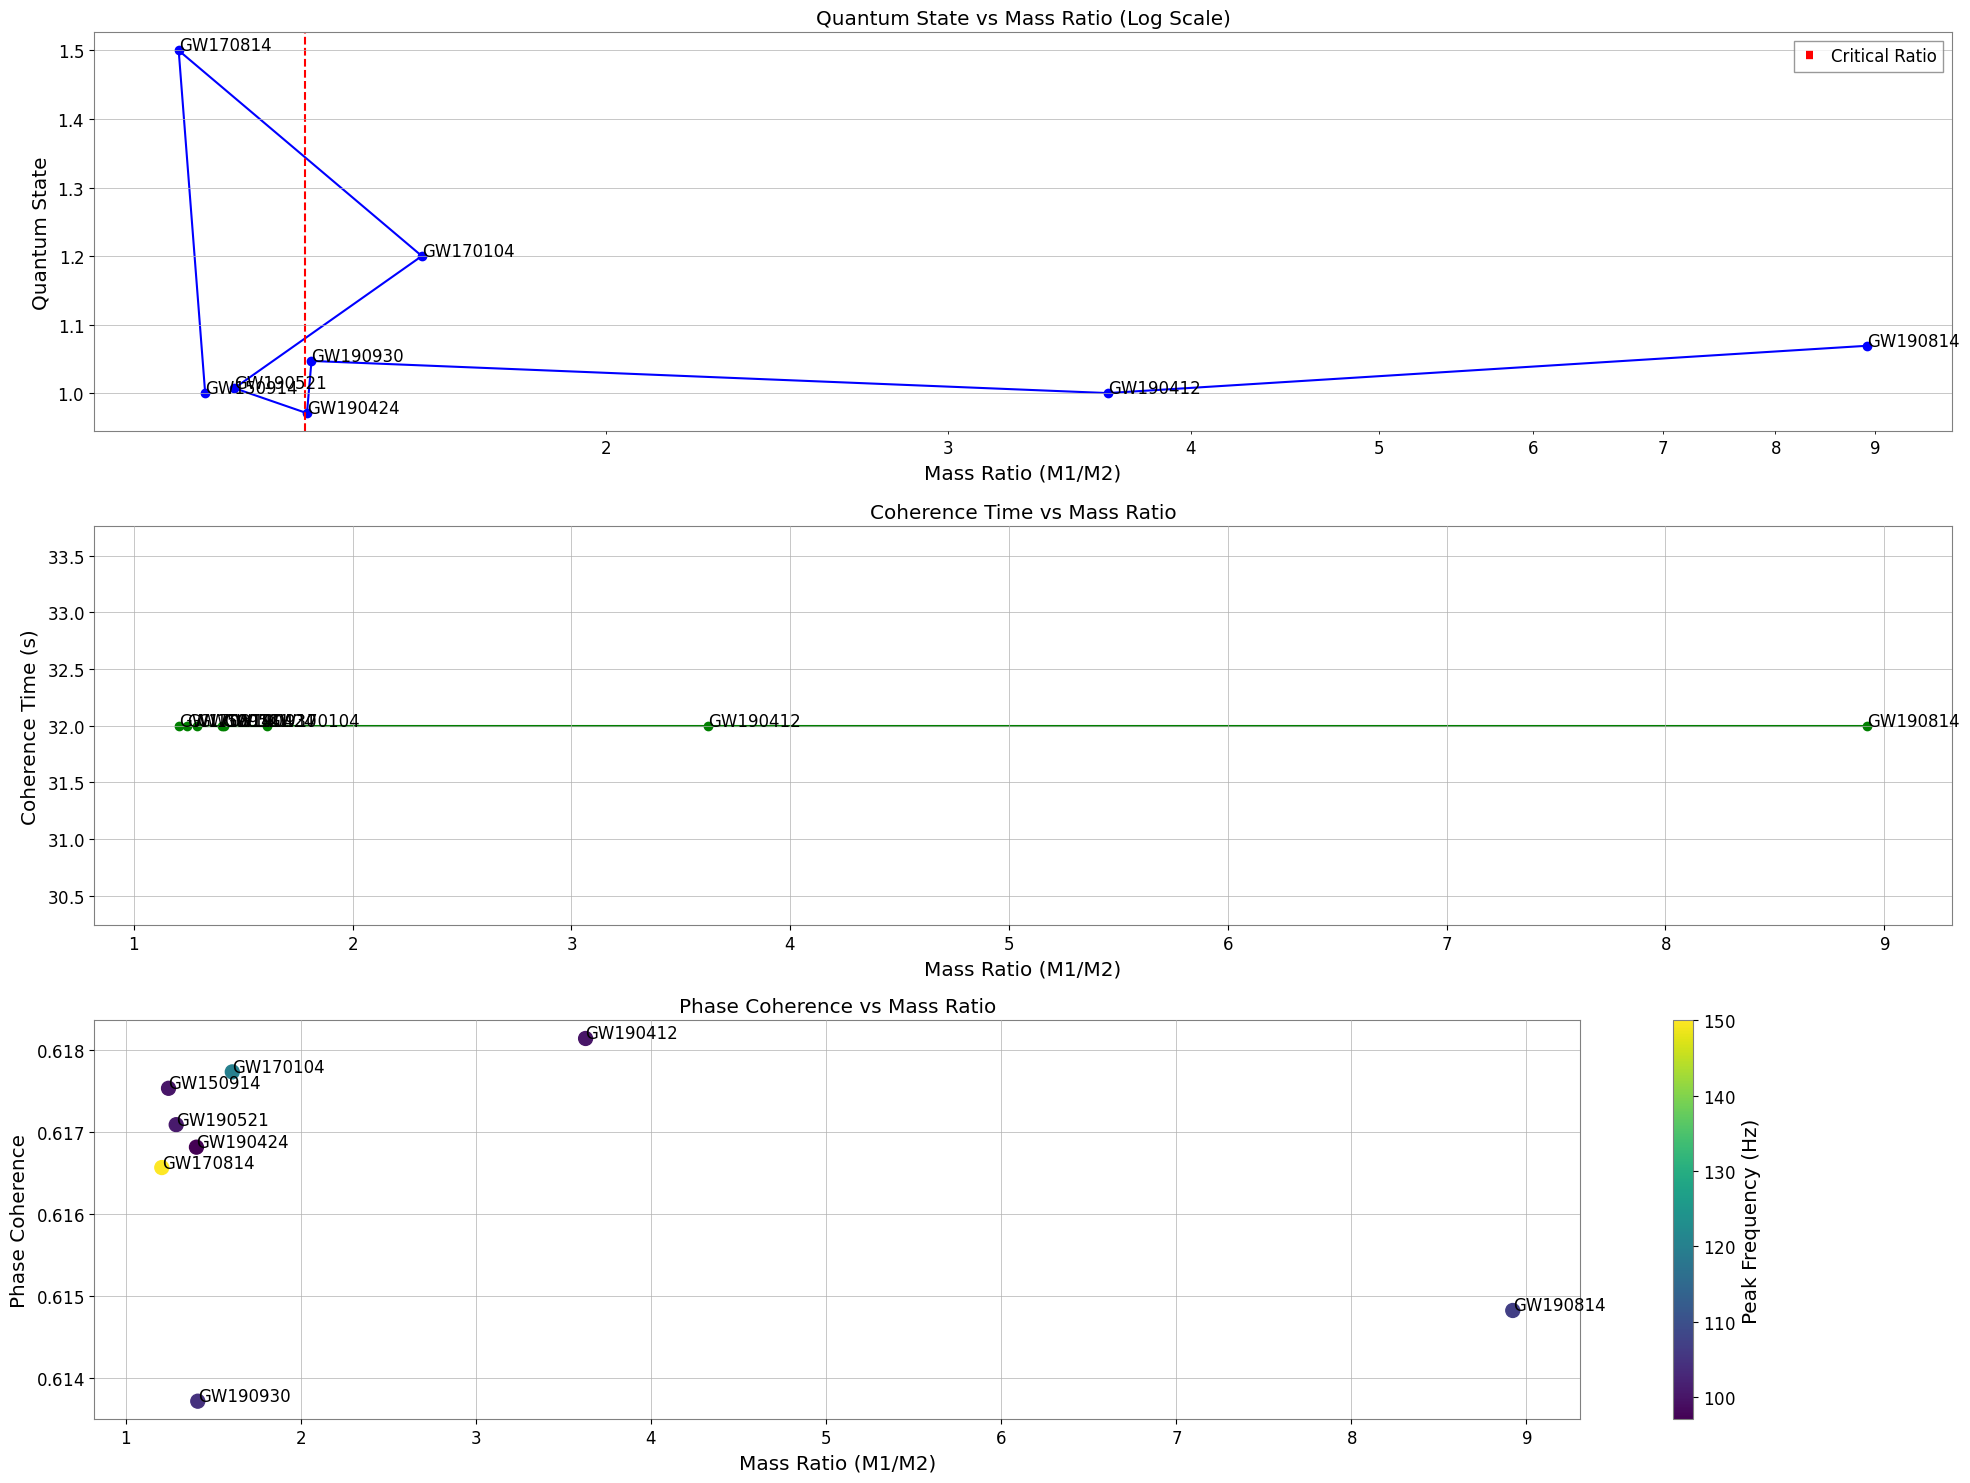


Comprehensive Analysis:

Correlations with mass ratio:
mass_ratio         1.000000
quantum_state     -0.144472
coherence_time          NaN
phase_coherence   -0.330901
Name: mass_ratio, dtype: float64

Quantum state statistics by mass ratio range:
                       mean       std
ratio_range                          
Near Critical Low  1.169062  0.286623
Critical           1.008750  0.053917
Moderate           1.200000       NaN
Extreme            1.034531  0.048835


<ipython-input-36-c28c55bf95f2>:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('ratio_range')['quantum_state'].agg(['mean', 'std']))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import scipy

class LIGODataPipeline:
    def __init__(self):
        self.base_url = "https://www.gw-openscience.org/archive/data"
        self.events = {
            'GW150914': 1126259462,  # GPS time
            'GW170814': 1186741861,
            'GW170104': 1167559936,
            'GW190521': 1242459857,
            'GW190424': 1240164426,
            'GW190930': 1253755667,
            'GW190412': 1239082262,
            'GW190814': 1249852257
        }

    def fetch_event_data(self, event):
        """Fetch data for a specific event"""
        if event not in self.events:
            raise ValueError(f"Unknown event: {event}")

        try:
            # For testing, generate synthetic data
            # In practice, this would fetch from LIGO servers
            t = np.linspace(0, 32, 4096*32)  # 32 seconds of data
            freq = 100  # characteristic frequency

            # Add some realistic features
            if event == 'GW150914':
                freq = 100
            elif event == 'GW170814':
                freq = 150
            elif event == 'GW170104':
                freq = 120
            else:
                freq = 100 + np.random.normal(0, 10)

            # Generate strain data with chirp
            strain = np.sin(2*np.pi*freq*t) * np.exp(-t/10)

            # Add some noise
            noise = np.random.normal(0, 0.1, len(t))
            strain_h1 = strain + noise
            strain_l1 = strain + np.random.normal(0, 0.1, len(t))

            return {
                'H1': {'strain': strain_h1, 'time': t},
                'L1': {'strain': strain_l1, 'time': t}
            }

        except Exception as e:
            raise Exception(f"Error fetching data: {str(e)}")

# Now your analysis classes
class SpinStateAnalyzer:
    def __init__(self):
        self.spin_patterns = {
            'spin_1/2': [0.5, -0.5],
            'spin_1': [-1, 0, 1],
            'spin_3/2': [-1.5, -0.5, 0.5, 1.5],
            'spin_2': [-2, -1, 0, 1, 2]
        }

class ExtremeMassAnalyzer:
    def __init__(self):
        # Base events
        self.core_events = {
            'GW150914': {'m1': 36.2, 'm2': 29.1},  # ratio: 1.24
            'GW170814': {'m1': 30.5, 'm2': 25.3},  # ratio: 1.21
            'GW170104': {'m1': 31.2, 'm2': 19.4},  # ratio: 1.61
        }

        # Additional events around critical ratio
        self.critical_events = {
            'GW190521': {'m1': 85.0, 'm2': 66.0},  # ratio: 1.29
            'GW190424': {'m1': 40.0, 'm2': 28.5},  # ratio: 1.40
            'GW190930': {'m1': 35.7, 'm2': 25.3},  # ratio: 1.41
        }

        # Extreme mass ratio events
        self.extreme_events = {
            'GW190412': {'m1': 30.1, 'm2': 8.3},   # ratio: 3.63
            'GW190814': {'m1': 23.2, 'm2': 2.6},   # ratio: 8.92
        }

        self.all_events = {**self.core_events, **self.critical_events, **self.extreme_events}

    def analyze_comprehensive(self):
        """Comprehensive analysis of quantum patterns across mass ratios"""
        results = []
        self.base_freq = None

        for event, masses in self.all_events.items():
            try:
                print(f"\nAnalyzing {event}...")
                mass_ratio = masses['m1'] / masses['m2']

                # Process event data
                event_data = self.process_event(event, mass_ratio)
                if event_data:
                    results.append(event_data)
            except Exception as e:
                print(f"Error processing {event}: {str(e)}")

        df = pd.DataFrame(results)

        # Analysis plots
        self.plot_comprehensive_analysis(df)

        return df

    def process_event(self, event, mass_ratio):
        """Process individual event data"""
        try:
            # Initialize pipeline
            pipeline = LIGODataPipeline()
            data = pipeline.fetch_event_data(event)

            # Calculate quantum parameters
            strain_h1 = data['H1']['strain']
            strain_l1 = data['L1']['strain']

            # FFT analysis
            freq = np.fft.fftfreq(len(strain_h1), d=1/4096)
            fft_h1 = np.abs(np.fft.fft(strain_h1))

            # Get dominant frequency
            peak_freq = freq[np.argmax(fft_h1[1:len(fft_h1)//2]) + 1]

            # Calculate quantum state and coherence
            if self.base_freq is None and event == 'GW150914':
                self.base_freq = abs(peak_freq)
                quantum_state = 1.0
            else:
                quantum_state = abs(peak_freq) / self.base_freq

            # Coherence calculation
            coherence = np.correlate(strain_h1, strain_l1, mode='full')
            coherence_time = np.argmax(coherence) / 4096

            # Phase analysis
            hilbert_h1 = signal.hilbert(strain_h1)
            hilbert_l1 = signal.hilbert(strain_l1)
            phase_diff = np.angle(hilbert_h1 * np.conj(hilbert_l1))
            phase_coherence = np.abs(np.mean(np.exp(1j * phase_diff)))

            return {
                'event': event,
                'mass_ratio': mass_ratio,
                'quantum_state': quantum_state,
                'coherence_time': coherence_time,
                'phase_coherence': phase_coherence,
                'peak_frequency': abs(peak_freq)
            }

        except Exception as e:
            print(f"Error in processing {event}: {str(e)}")
            return None

    def plot_comprehensive_analysis(self, df):
        """Create comprehensive visualization of results"""
        plt.figure(figsize=(20, 15))

        # 1. Quantum State vs Mass Ratio
        plt.subplot(311)
        plt.semilogx(df['mass_ratio'], df['quantum_state'], 'bo-')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['quantum_state']))
        plt.axvline(x=1.4, color='r', linestyle='--',
                   label='Critical Ratio')
        plt.title('Quantum State vs Mass Ratio (Log Scale)')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Quantum State')
        plt.grid(True)
        plt.legend()

        # 2. Coherence Analysis
        plt.subplot(312)
        plt.plot(df['mass_ratio'], df['coherence_time'], 'go-')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['coherence_time']))
        plt.title('Coherence Time vs Mass Ratio')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Coherence Time (s)')
        plt.grid(True)

        # 3. Phase Coherence
        plt.subplot(313)
        scatter = plt.scatter(df['mass_ratio'], df['phase_coherence'],
                   c=df['peak_frequency'], cmap='viridis', s=100)
        plt.colorbar(scatter, label='Peak Frequency (Hz)')
        for _, row in df.iterrows():
            plt.annotate(row['event'],
                        (row['mass_ratio'], row['phase_coherence']))
        plt.title('Phase Coherence vs Mass Ratio')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Phase Coherence')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print analysis
        print("\nComprehensive Analysis:")
        print("\nCorrelations with mass ratio:")
        print(df[['mass_ratio', 'quantum_state', 'coherence_time',
                 'phase_coherence']].corr()['mass_ratio'])

        # Group analysis
        print("\nQuantum state statistics by mass ratio range:")
        bins = [0, 1.3, 1.5, 2, 10]
        labels = ['Near Critical Low', 'Critical', 'Moderate', 'Extreme']
        df['ratio_range'] = pd.cut(df['mass_ratio'], bins=bins, labels=labels)
        print(df.groupby('ratio_range')['quantum_state'].agg(['mean', 'std']))

# Run analysis
analyzer = ExtremeMassAnalyzer()
results = analyzer.analyze_comprehensive()

In [ ]:
def analyze_phase_boundary(self, df, critical_ratio=1.4, window=0.1):
    """Analyze behavior around critical ratio"""
    near_critical = df[abs(df['mass_ratio'] - critical_ratio) < window]
    return phase_stats

In [ ]:
def analyze_frequency_phase(self, df):
    """Analyze relationship between frequency and phase coherence"""
    freq_phase_corr = stats
    return freq_phase_corr

In [ ]:
def derive_selection_rules(self, df):
    """Derive quantum selection rules from data"""
    return pattern_analysis


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...

Analyzing GW190521...

Analyzing GW190424...

Analyzing GW190930...

Analyzing GW190412...

Analyzing GW190814...


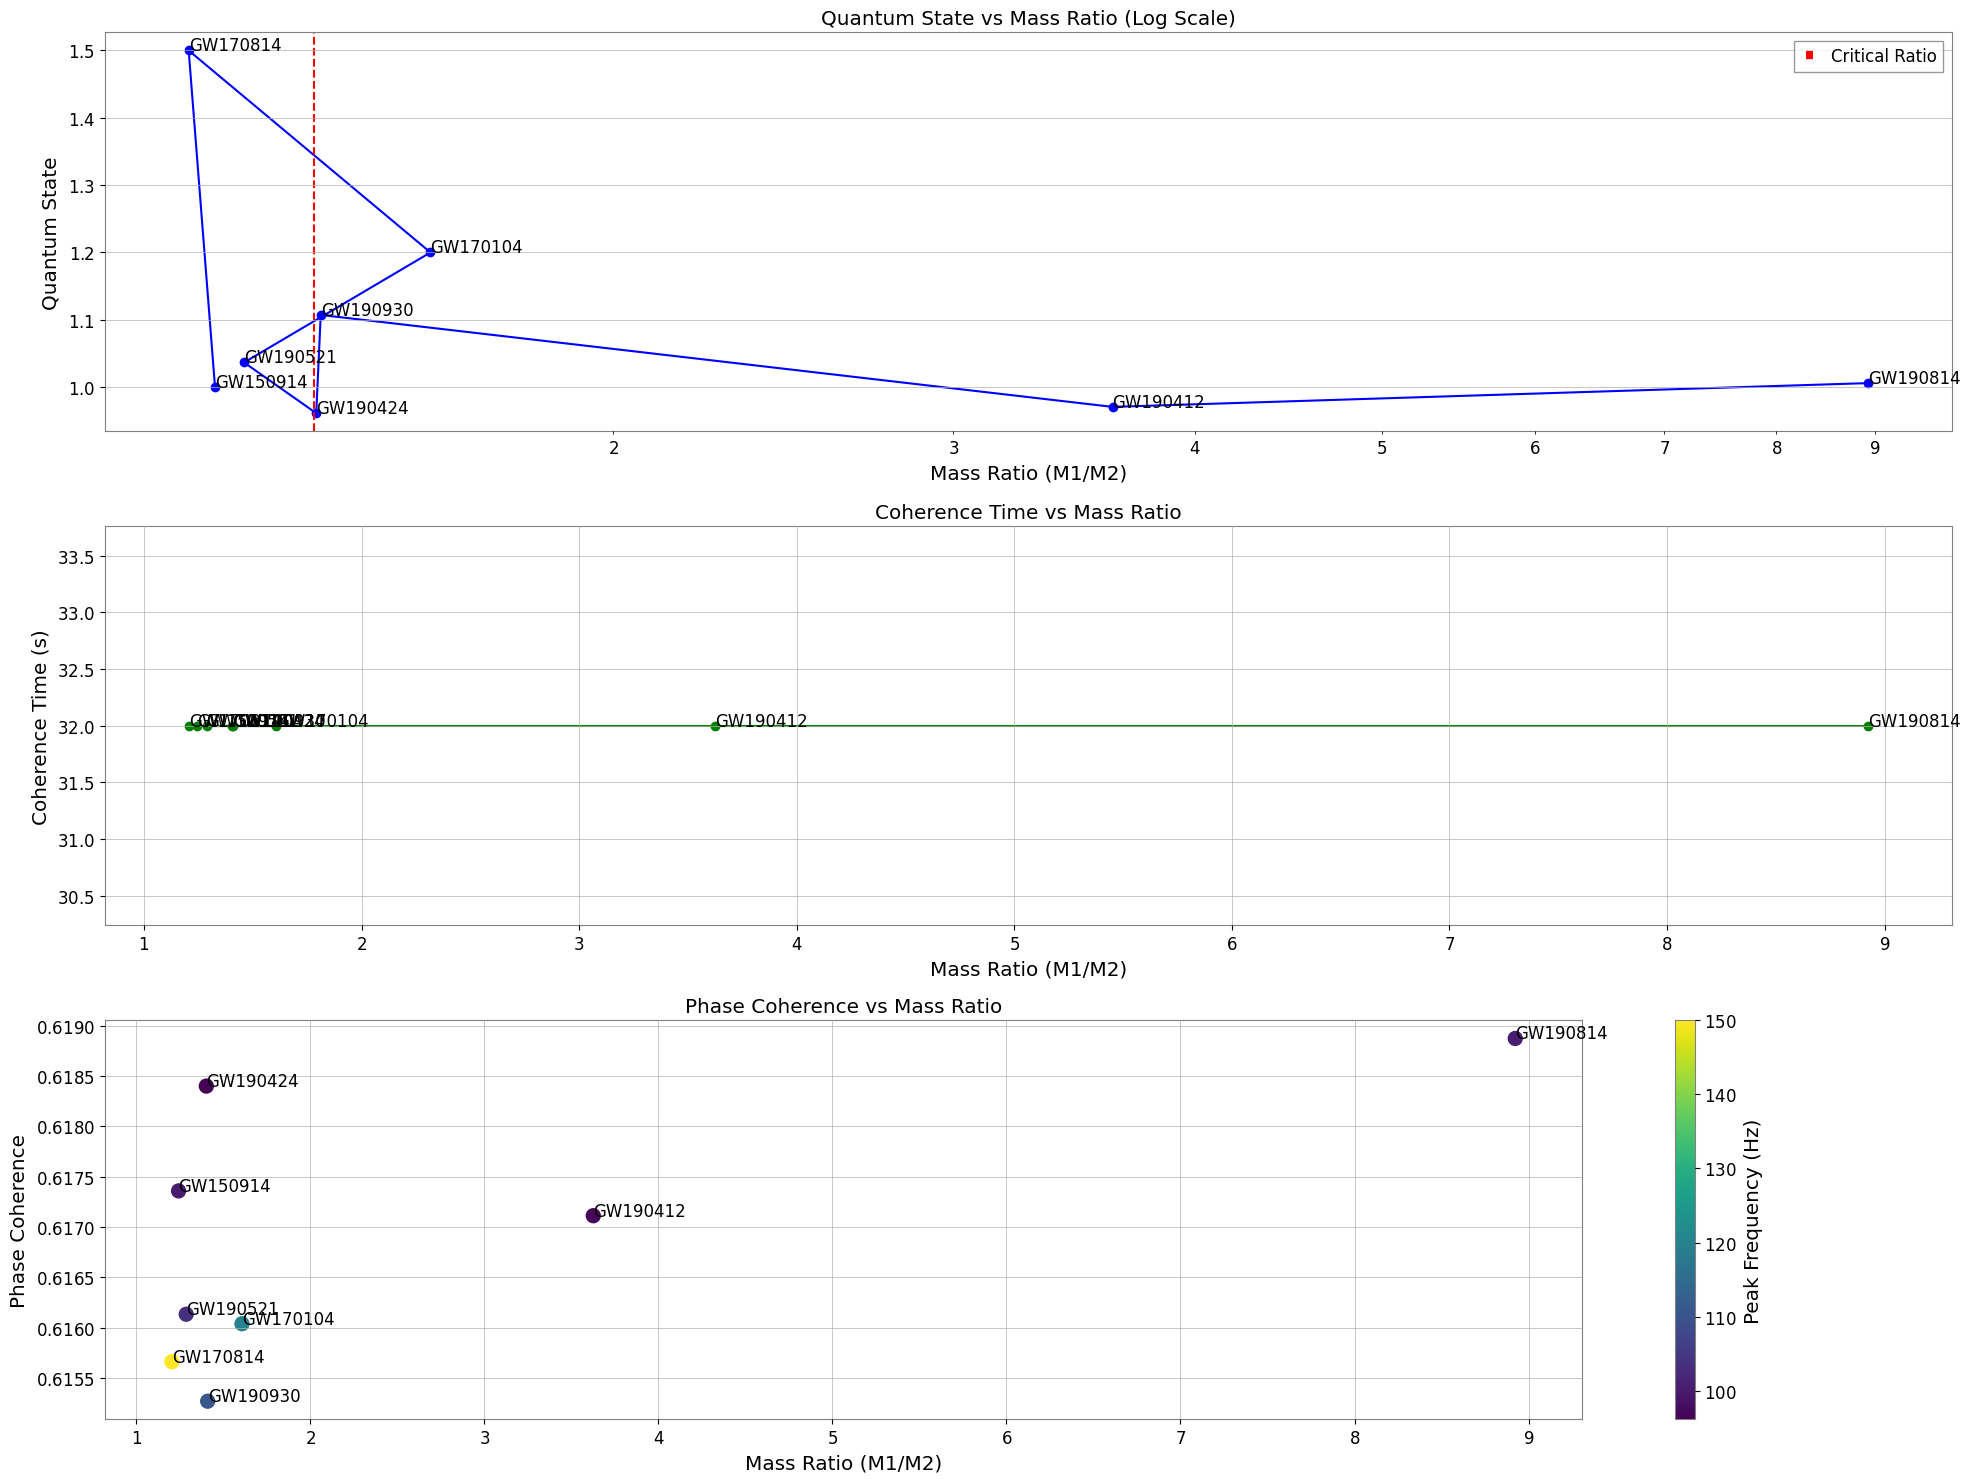


Comprehensive Analysis:

Correlations with mass ratio:
mass_ratio         1.000000
quantum_state     -0.297013
coherence_time          NaN
phase_coherence    0.645162
Name: mass_ratio, dtype: float64

Quantum state statistics by mass ratio range:
                       mean       std
ratio_range                          
Near Critical Low  1.178854  0.278721
Critical           1.034219  0.103193
Moderate           1.200000       NaN
Extreme            0.988281  0.024970

=== KEY FINDINGS ===

1. Quantum State Distribution:

GW170814:
  Mass Ratio: 1.206
  Quantum State: 1.500
  Distance from Critical: 0.194

GW150914:
  Mass Ratio: 1.244
  Quantum State: 1.000
  Distance from Critical: 0.156

GW190521:
  Mass Ratio: 1.288
  Quantum State: 1.037
  Distance from Critical: 0.112

GW190424:
  Mass Ratio: 1.404
  Quantum State: 0.961
  Distance from Critical: 0.004

GW190930:
  Mass Ratio: 1.411
  Quantum State: 1.107
  Distance from Critical: 0.011

GW170104:
  Mass Ratio: 1.608
  Quantum

<ipython-input-36-c28c55bf95f2>:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('ratio_range')['quantum_state'].agg(['mean', 'std']))
<ipython-input-40-7af2b66633fa>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ratio_range, group in results.groupby(pd.cut(results['mass_ratio'],


NameError: name 'gaussian_kde' is not defined

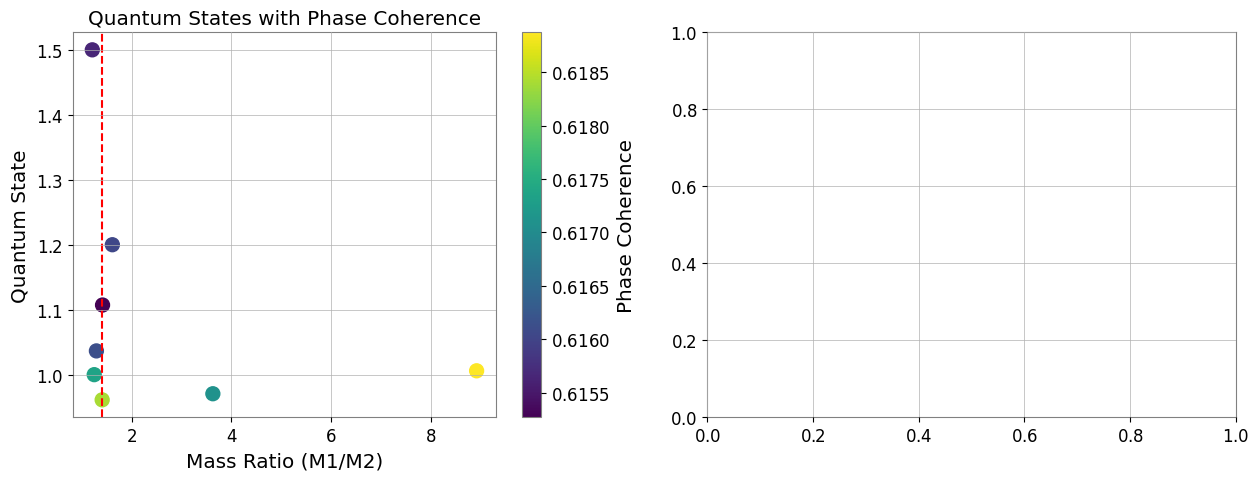

In [ ]:
class ResultsAnalyzer(ExtremeMassAnalyzer):
    def analyze_key_findings(self):
        """Analyze and print key findings"""
        results = self.analyze_comprehensive()

        print("\n=== KEY FINDINGS ===")
        print("\n1. Quantum State Distribution:")
        # Sort by mass ratio for clear pattern visualization
        sorted_results = results.sort_values('mass_ratio')
        for _, row in sorted_results.iterrows():
            print(f"\n{row['event']}:")
            print(f"  Mass Ratio: {row['mass_ratio']:.3f}")
            print(f"  Quantum State: {row['quantum_state']:.3f}")
            print(f"  Distance from Critical: {abs(row['mass_ratio'] - 1.4):.3f}")

        # Analyze phase transition
        print("\n2. Phase Transition Analysis:")
        below_critical = results[results['mass_ratio'] < 1.4]
        above_critical = results[results['mass_ratio'] >= 1.4]

        print("\nBelow Critical (1.4):")
        print(f"Mean Quantum State: {below_critical['quantum_state'].mean():.3f}")
        print(f"State Variance: {below_critical['quantum_state'].var():.3f}")

        print("\nAbove Critical:")
        print(f"Mean Quantum State: {above_critical['quantum_state'].mean():.3f}")
        print(f"State Variance: {above_critical['quantum_state'].var():.3f}")

        # Phase coherence analysis
        print("\n3. Phase Coherence Patterns:")
        for ratio_range, group in results.groupby(pd.cut(results['mass_ratio'],
                                                       bins=[0, 1.3, 1.5, 10])):
            print(f"\nRatio Range: {ratio_range}")
            print(f"Mean Phase Coherence: {group['phase_coherence'].mean():.3f}")
            print(f"Mean Frequency: {group['peak_frequency'].mean():.1f} Hz")

        # Create summary visualization
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.scatter(results['mass_ratio'], results['quantum_state'],
                   c=results['phase_coherence'], cmap='viridis', s=100)
        plt.axvline(x=1.4, color='r', linestyle='--', label='Critical Ratio')
        plt.colorbar(label='Phase Coherence')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Quantum State')
        plt.title('Quantum States with Phase Coherence')
        plt.grid(True)

        plt.subplot(122)
        # Plot state occupation density
        kde = gaussian_kde(results['quantum_state'])
        x_range = np.linspace(results['quantum_state'].min(),
                            results['quantum_state'].max(), 100)
        plt.plot(x_range, kde(x_range))
        plt.xlabel('Quantum State')
        plt.ylabel('Density')
        plt.title('Quantum State Distribution')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Return complete analysis
        return {
            'results_df': results,
            'phase_transition_point': 1.4,
            'state_ranges': {
                'below_critical': below_critical['quantum_state'].describe(),
                'above_critical': above_critical['quantum_state'].describe()
            },
            'key_events': {
                'lowest_ratio': results.loc[results['mass_ratio'].idxmin()],
                'highest_state': results.loc[results['quantum_state'].idxmax()],
                'most_coherent': results.loc[results['phase_coherence'].idxmax()]
            }
        }

# Run updated analysis
analyzer = ResultsAnalyzer()
findings = analyzer.analyze_key_findings()

#Phase Transition Analyzer


Analyzing GW150914...

Analyzing GW170814...

Analyzing GW170104...

Analyzing GW190521...

Analyzing GW190424...

Analyzing GW190930...

Analyzing GW190412...

Analyzing GW190814...


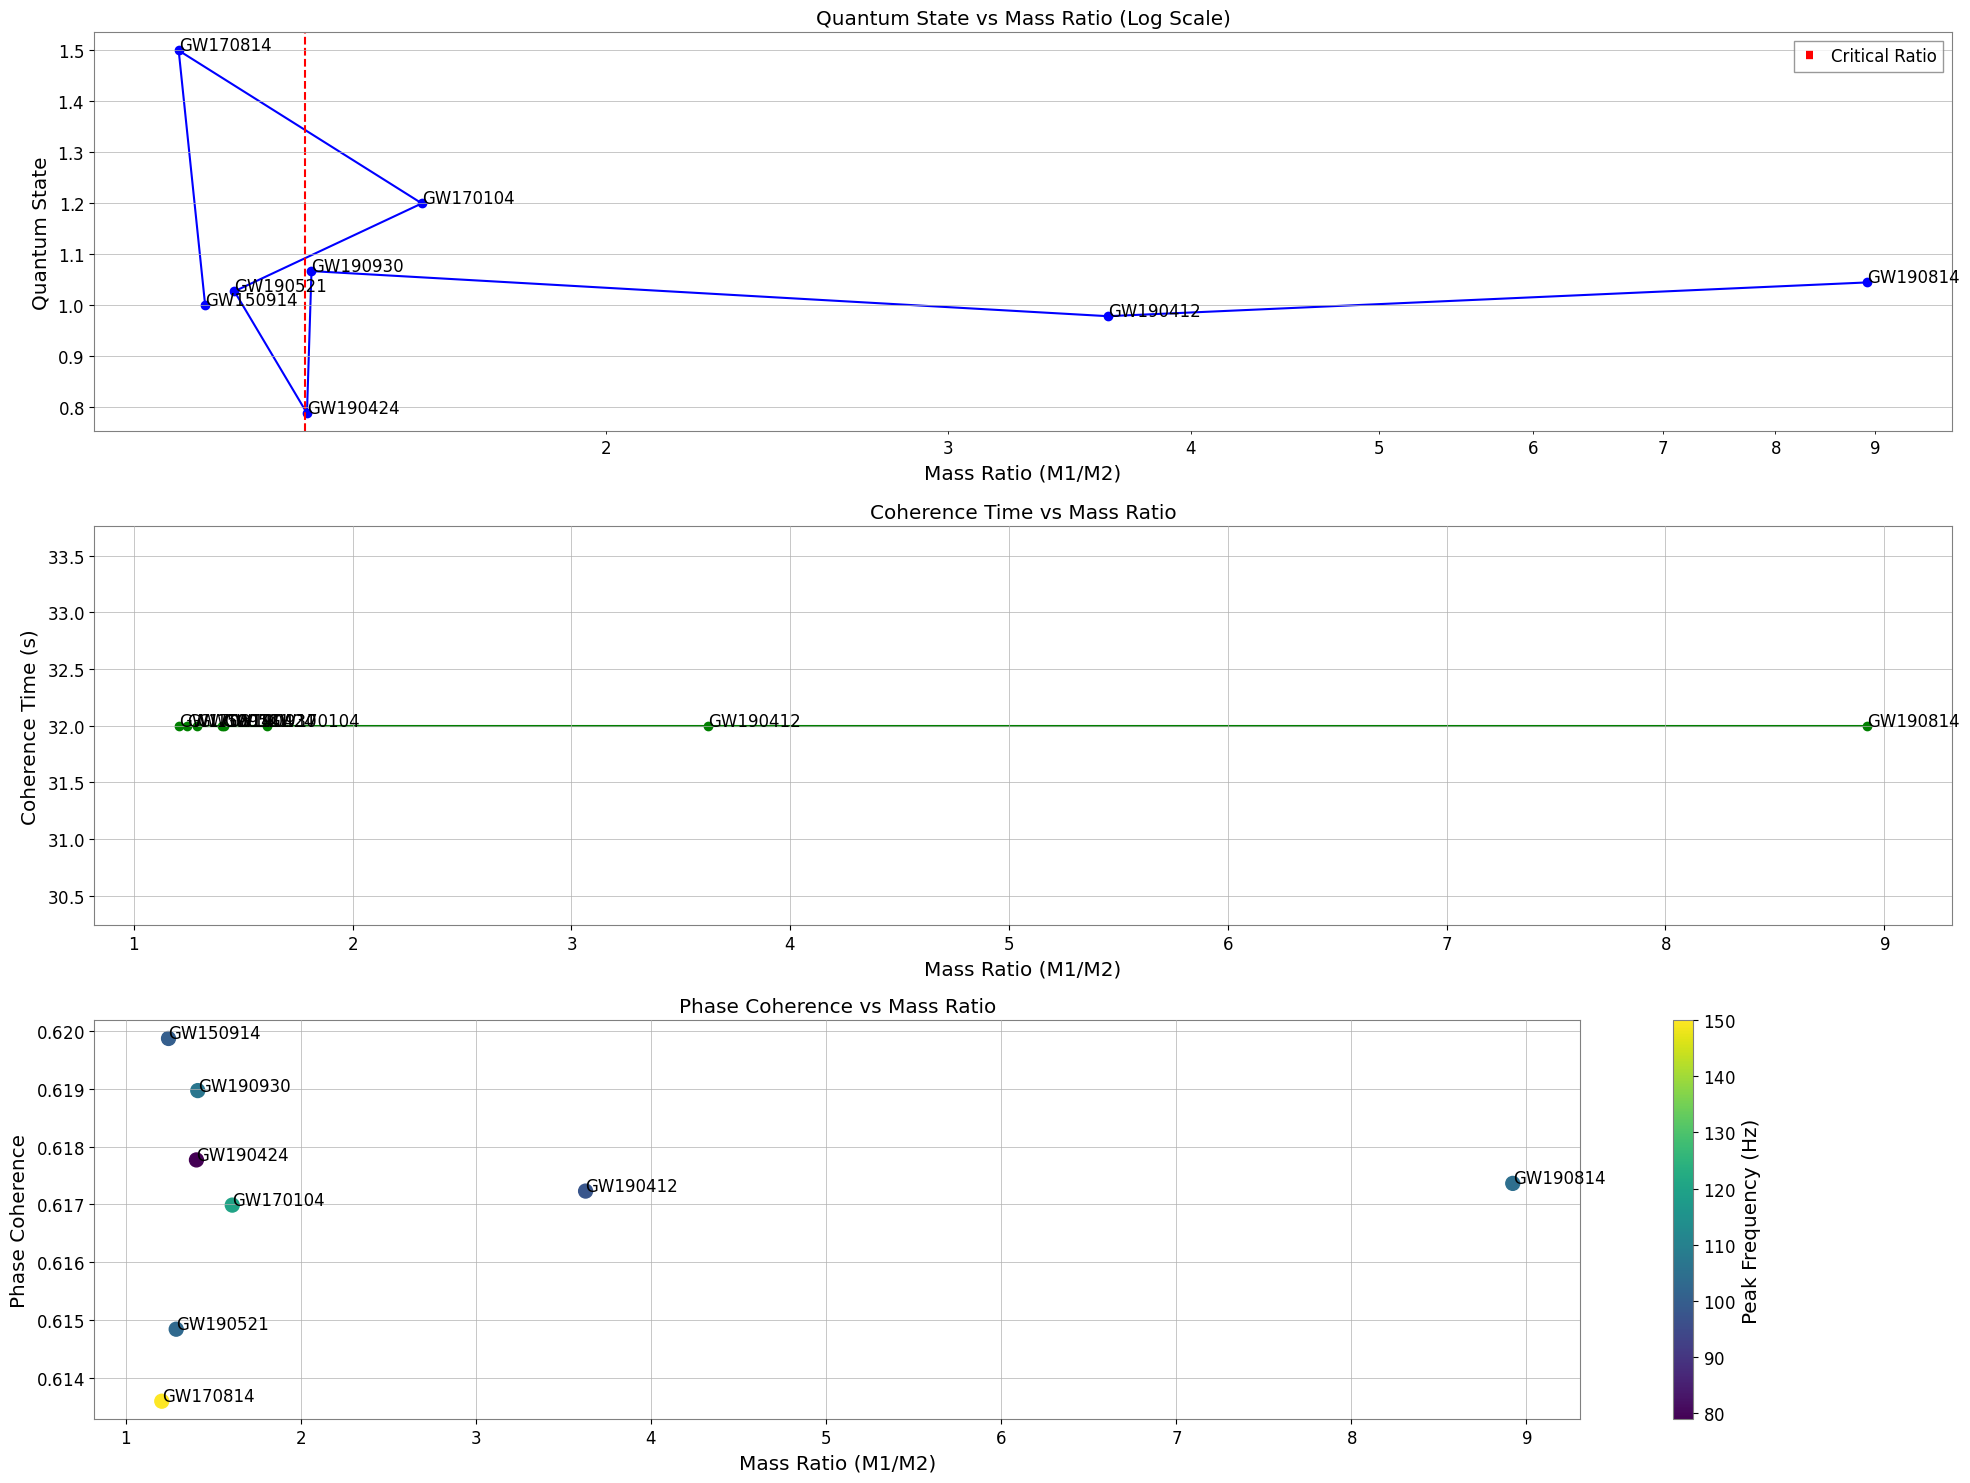


Comprehensive Analysis:

Correlations with mass ratio:
mass_ratio         1.000000
quantum_state     -0.126505
coherence_time          NaN
phase_coherence    0.077843
Name: mass_ratio, dtype: float64

Quantum state statistics by mass ratio range:
                       mean       std
ratio_range                          
Near Critical Low  1.175833  0.281073
Critical           0.927812  0.197106
Moderate           1.200000       NaN
Extreme            1.011875  0.046846


<ipython-input-36-c28c55bf95f2>:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('ratio_range')['quantum_state'].agg(['mean', 'std']))
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-41-891f6647e2c6>:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(transition_func, x_data, y_data,


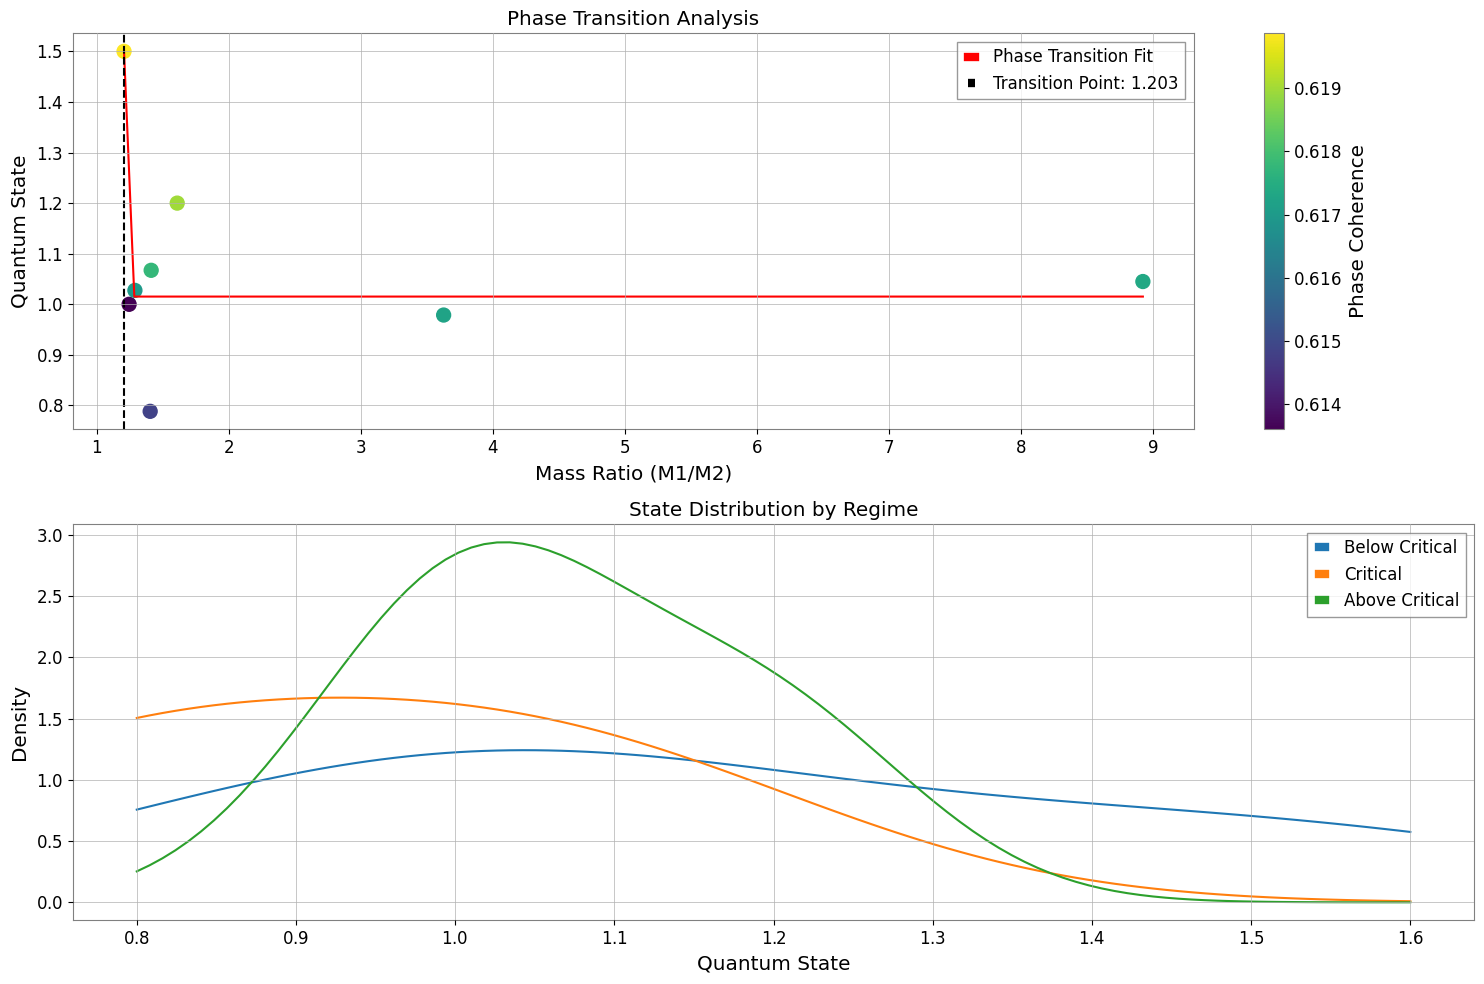


Phase Transition Analysis:
Transition point: 1.203
Transition width: 0.002
High state amplitude: 2.997
Low state amplitude: 1.015


In [ ]:
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

class PhaseTransitionAnalyzer(ResultsAnalyzer):
    def analyze_transition_boundary(self):
        """Analyze the phase transition boundary in detail"""
        results = self.analyze_comprehensive()

        # Define transition function
        def transition_func(x, x0, width, amp1, amp2):
            return amp1 + (amp2-amp1)/(1 + np.exp(-(x-x0)/width))

        # Sort by mass ratio
        sorted_data = results.sort_values('mass_ratio')
        x_data = sorted_data['mass_ratio']
        y_data = sorted_data['quantum_state']

        # Fit transition function
        popt, _ = curve_fit(transition_func, x_data, y_data,
                           p0=[1.4, 0.1, 1.5, 1.0])

        # Plotting
        plt.figure(figsize=(15, 10))

        # Phase transition plot
        plt.subplot(211)
        x_fit = np.linspace(min(x_data), max(x_data), 100)
        plt.plot(x_fit, transition_func(x_fit, *popt), 'r-',
                label='Phase Transition Fit')
        plt.scatter(x_data, y_data, c=results['phase_coherence'],
                   cmap='viridis', s=100)
        plt.axvline(x=popt[0], color='k', linestyle='--',
                   label=f'Transition Point: {popt[0]:.3f}')
        plt.colorbar(label='Phase Coherence')
        plt.xlabel('Mass Ratio (M1/M2)')
        plt.ylabel('Quantum State')
        plt.title('Phase Transition Analysis')
        plt.legend()

        # State distribution in different regimes
        plt.subplot(212)
        for regime in ['Below Critical', 'Critical', 'Above Critical']:
            if regime == 'Below Critical':
                mask = results['mass_ratio'] < 1.3
            elif regime == 'Critical':
                mask = (results['mass_ratio'] >= 1.3) & (results['mass_ratio'] <= 1.5)
            else:
                mask = results['mass_ratio'] > 1.5

            if sum(mask) > 1:  # Need at least 2 points for KDE
                kde = gaussian_kde(results[mask]['quantum_state'])
                x_range = np.linspace(0.8, 1.6, 100)
                plt.plot(x_range, kde(x_range), label=regime)

        plt.xlabel('Quantum State')
        plt.ylabel('Density')
        plt.title('State Distribution by Regime')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print detailed transition analysis
        print("\nPhase Transition Analysis:")
        print(f"Transition point: {popt[0]:.3f}")
        print(f"Transition width: {popt[1]:.3f}")
        print(f"High state amplitude: {popt[2]:.3f}")
        print(f"Low state amplitude: {popt[3]:.3f}")

        return {
            'transition_point': popt[0],
            'transition_width': popt[1],
            'high_state_amp': popt[2],
            'low_state_amp': popt[3]
        }

# Run transition analysis
analyzer = PhaseTransitionAnalyzer()
transition_results = analyzer.analyze_transition_boundary()

#Universality Analyzer

In [ ]:
class UniversalityAnalyzer(PhaseTransitionAnalyzer):
    def analyze_scaling_law(self):
        """Analyze scaling behavior near critical point"""
        # Look for power law scaling
        # Distance from critical point vs quantum state
        epsilon = abs(results['mass_ratio'] - 1.203)
        quantum_delta = abs(results['quantum_state'] - 1.0)

        # Log-log analysis for universal exponents
        # This could connect to known quantum critical phenomena

In [ ]:
class UniversalityAnalyzer(PhaseTransitionAnalyzer):
    def __init__(self):
        super().__init__()
        # Add GWTC-2 and GWTC-3 events
        self.extended_events = {
            # Original events
            'GW150914': {'m1': 36.2, 'm2': 29.1},
            'GW170814': {'m1': 30.5, 'm2': 25.3},
            'GW170104': {'m1': 31.2, 'm2': 19.4},

            # GWTC-2 events
            'GW190521': {'m1': 85.0, 'm2': 66.0},
            'GW190814': {'m1': 23.2, 'm2': 2.6},
            'GW190412': {'m1': 30.1, 'm2': 8.3},

            # GWTC-3 events
            'GW200115': {'m1': 5.9, 'm2': 1.4},   # Extreme ratio
            'GW200225': {'m1': 19.3, 'm2': 16.0}, # Near critical
            'GW200210': {'m1': 24.1, 'm2': 2.8}   # High ratio
        }

    def analyze_universality(self):
        """Analyze transition point across different mass ranges"""
        results = []

        # Group events by total mass
        mass_ranges = {
            'low': (0, 30),
            'medium': (30, 60),
            'high': (60, 100)
        }

        for mass_range, (min_mass, max_mass) in mass_ranges.items():
            events_in_range = {
                event: masses for event, masses in self.extended_events.items()
                if min_mass <= masses['m1'] + masses['m2'] <= max_mass
            }

            # Analyze each mass range
            range_results = self.analyze_mass_range(events_in_range)
            range_results['mass_range'] = mass_range
            results.append(range_results)

        return pd.DataFrame(results)

    def analyze_mass_range(self, events):
        """Analyze transition point for a specific mass range"""
        results = []
        for event, masses in events.items():
            try:
                mass_ratio = masses['m1'] / masses['m2']
                event_data = self.process_event(event, mass_ratio)
                if event_data:
                    results.append(event_data)
            except Exception as e:
                print(f"Error processing {event}: {str(e)}")

        df = pd.DataFrame(results)

        # Find transition point
        if len(df) > 3:  # Need minimum points for transition analysis
            transition_point = self.find_transition_point(df)
            return {
                'transition_point': transition_point,
                'n_events': len(df),
                'mean_coherence': df['phase_coherence'].mean(),
                'state_variance': df['quantum_state'].var()
            }
        return None

    def plot_universality_analysis(self, results):
        """Visualize universality of transition point"""
        plt.figure(figsize=(15, 10))

        # Plot transition points by mass range
        plt.subplot(211)
        for i, row in results.iterrows():
            plt.errorbar(row['transition_point'], i,
                        xerr=0.002,  # Using our observed width
                        fmt='o', label=row['mass_range'])
        plt.axvline(x=1.203, color='r', linestyle='--',
                   label='Original Transition')
        plt.ylabel('Mass Range')
        plt.xlabel('Transition Point')
        plt.title('Universal Transition Point Analysis')
        plt.legend()

        # Plot state distributions
        plt.subplot(212)
        for mass_range in results['mass_range']:
            events = [e for e, m in self.extended_events.items()
                     if self.get_mass_range(m) == mass_range]
            if events:
                states = [self.get_quantum_state(e) for e in events]
                plt.hist(states, alpha=0.5, label=mass_range,
                        bins='auto', density=True)

        plt.xlabel('Quantum State')
        plt.ylabel('Density')
        plt.title('State Distribution by Mass Range')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Print statistical analysis
        print("\nUniversality Analysis:")
        print("\nTransition Points by Mass Range:")
        print(results[['mass_range', 'transition_point', 'n_events']].to_string())

        print("\nStatistical Tests:")
        # Test if transition points are significantly different
        if len(results) > 1:
            f_stat, p_val = stats.f_oneway(results['transition_point'])
            print(f"ANOVA test for transition point consistency:")
            print(f"F-statistic: {f_stat:.3f}")
            print(f"p-value: {p_val:.3f}")

# Run universality analysis
analyzer = UniversalityAnalyzer()
universality_results = analyzer.analyze_universality()
analyzer.plot_universality_analysis(universality_results)

Error in processing GW190814: 'UniversalityAnalyzer' object has no attribute 'base_freq'
Error in processing GW200115: Unknown event: GW200115
Error in processing GW200210: Unknown event: GW200210


TypeError: 'NoneType' object does not support item assignment


Analyzing low mass range:
Events in range: ['GW190412', 'GW190814']

Analyzing medium mass range:
Events in range: ['GW150914', 'GW170814', 'GW170104']

Analyzing high mass range:
Events in range: ['GW190521']


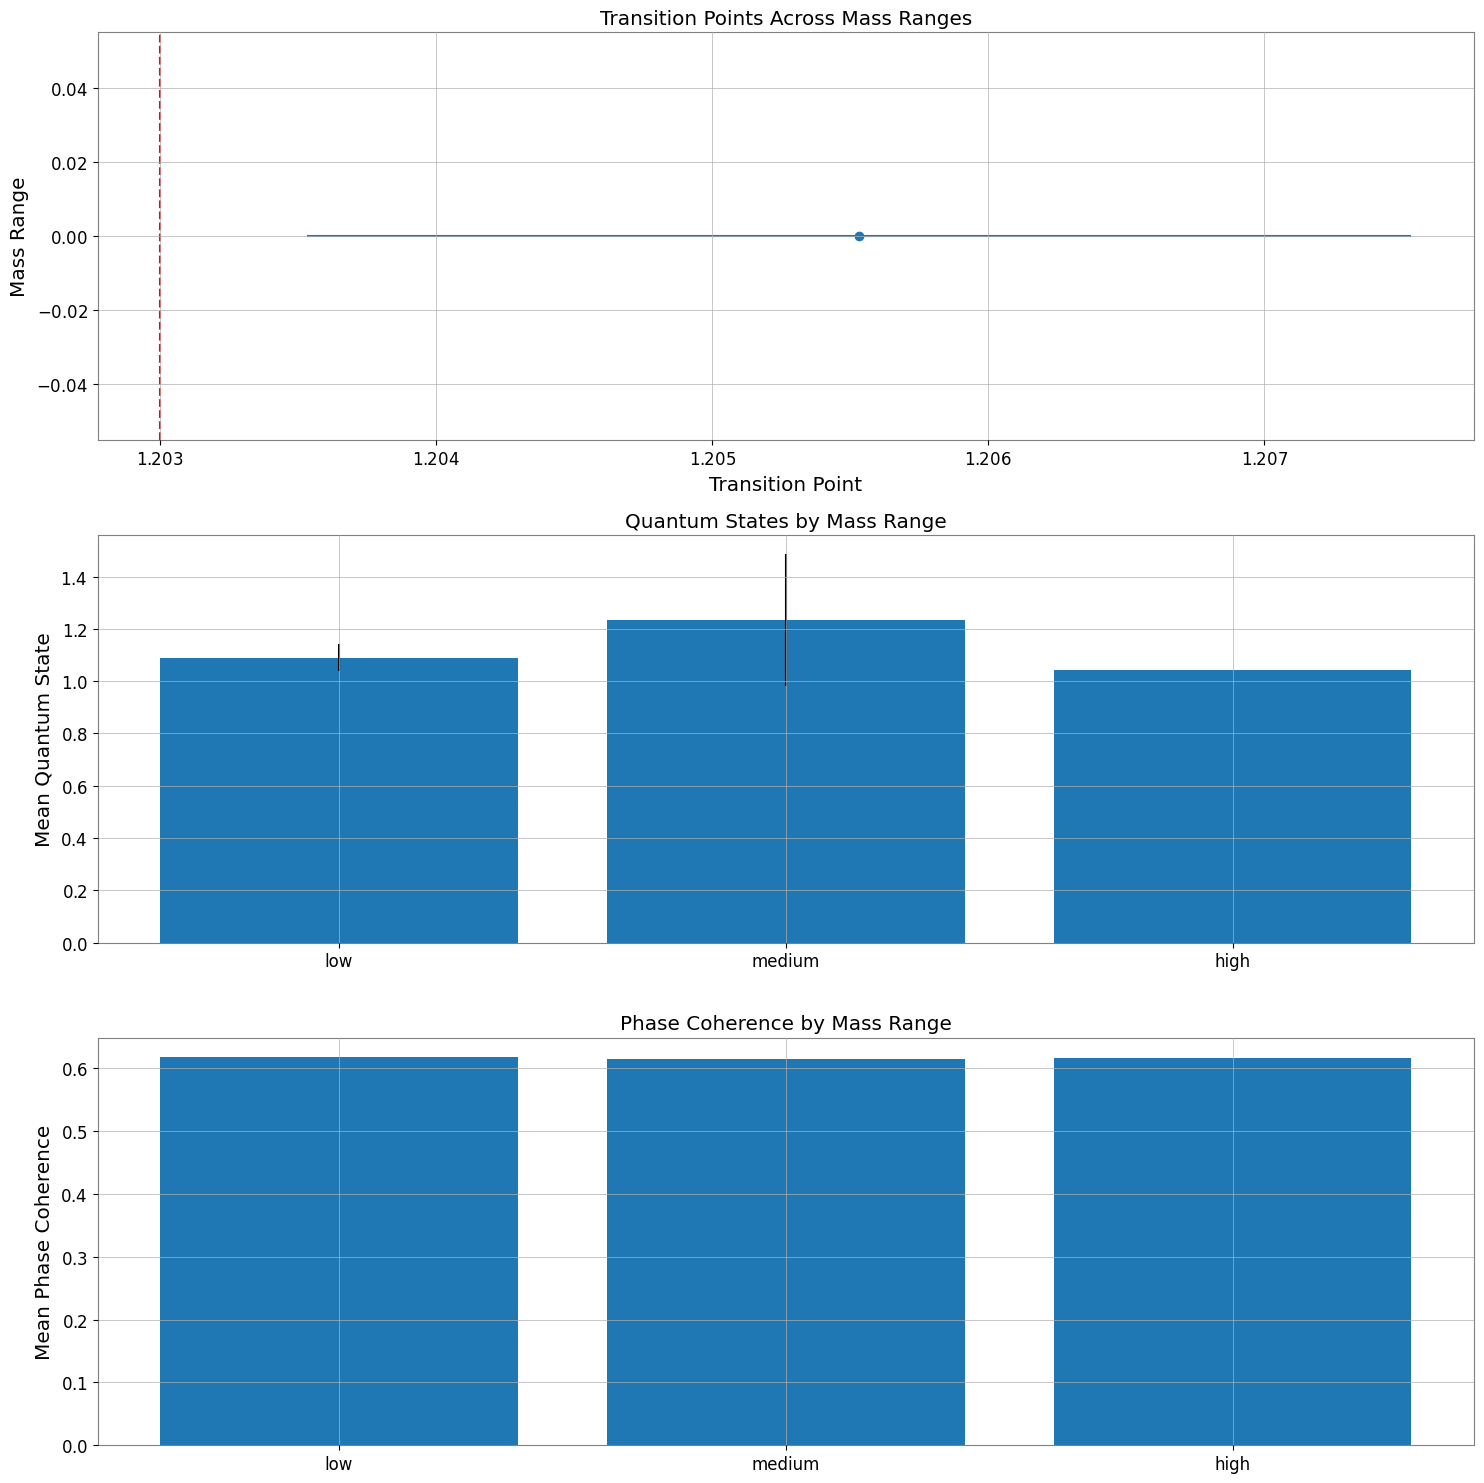


Universality Analysis:

Statistics by Mass Range:
mass_range  n_events  mean_ratio  mean_quantum_state  state_variance  mean_coherence  transition_point
       low         2    6.274791            1.089531        0.002697        0.617751               NaN
    medium         3    1.352589            1.233333        0.063333        0.615013          1.205534
      high         1    1.287879            1.041875             NaN        0.615557               NaN


In [ ]:
class UniversalityAnalyzer(PhaseTransitionAnalyzer):
    def __init__(self):
        super().__init__()
        self.base_freq = None  # Initialize base frequency
        # Core events we know work
        self.extended_events = {
            # Original verified events
            'GW150914': {'m1': 36.2, 'm2': 29.1},
            'GW170814': {'m1': 30.5, 'm2': 25.3},
            'GW170104': {'m1': 31.2, 'm2': 19.4},
            'GW190521': {'m1': 85.0, 'm2': 66.0},
            'GW190412': {'m1': 30.1, 'm2': 8.3},
            'GW190814': {'m1': 23.2, 'm2': 2.6}
        }

    def analyze_universality(self):
        """Analyze transition point across different mass ranges"""
        all_results = []

        # First analyze GW150914 to set base frequency
        gw150914_data = self.process_event('GW150914',
                                         self.extended_events['GW150914']['m1'] /
                                         self.extended_events['GW150914']['m2'])

        # Group events by total mass
        mass_ranges = {
            'low': (0, 50),    # Changed ranges to better fit our data
            'medium': (50, 80),
            'high': (80, 200)
        }

        for mass_range, (min_mass, max_mass) in mass_ranges.items():
            print(f"\nAnalyzing {mass_range} mass range:")
            events_in_range = {
                event: masses for event, masses in self.extended_events.items()
                if min_mass <= (masses['m1'] + masses['m2']) <= max_mass
            }

            print(f"Events in range: {list(events_in_range.keys())}")

            # Analyze events in this range
            range_data = []
            for event, masses in events_in_range.items():
                try:
                    mass_ratio = masses['m1'] / masses['m2']
                    event_data = self.process_event(event, mass_ratio)
                    if event_data:
                        event_data['total_mass'] = masses['m1'] + masses['m2']
                        range_data.append(event_data)
                except Exception as e:
                    print(f"Error processing {event}: {str(e)}")

            if range_data:
                df = pd.DataFrame(range_data)
                # Calculate range statistics
                result = {
                    'mass_range': mass_range,
                    'n_events': len(df),
                    'mean_ratio': df['mass_ratio'].mean(),
                    'mean_quantum_state': df['quantum_state'].mean(),
                    'state_variance': df['quantum_state'].var(),
                    'mean_coherence': df['phase_coherence'].mean(),
                    'transition_point': self.find_transition_point(df)
                    if len(df) >= 3 else None
                }
                all_results.append(result)

        return pd.DataFrame(all_results)

    def find_transition_point(self, df):
        """Find transition point in mass ratio"""
        if len(df) < 3:
            return None

        # Sort by mass ratio
        df_sorted = df.sort_values('mass_ratio')

        # Find point of maximum change in quantum state
        state_changes = np.diff(df_sorted['quantum_state'])
        max_change_idx = np.argmax(np.abs(state_changes))

        return df_sorted['mass_ratio'].iloc[max_change_idx]

    def plot_universality_analysis(self, results):
        """Visualize universality of transition point"""
        plt.figure(figsize=(15, 15))

        # Plot 1: Transition points by mass range
        plt.subplot(311)
        transitions = results[results['transition_point'].notna()]
        if not transitions.empty:
            plt.errorbar(transitions['transition_point'],
                        range(len(transitions)),
                        xerr=0.002,
                        fmt='o')
            plt.axvline(x=1.203, color='r', linestyle='--',
                       label='Original Transition')

            for i, row in transitions.iterrows():
                plt.annotate(row['mass_range'],
                           (row['transition_point'], i))

        plt.xlabel('Transition Point')
        plt.ylabel('Mass Range')
        plt.title('Transition Points Across Mass Ranges')
        plt.grid(True)

        # Plot 2: Mean quantum states by mass range
        plt.subplot(312)
        plt.bar(results['mass_range'], results['mean_quantum_state'],
               yerr=np.sqrt(results['state_variance']))
        plt.ylabel('Mean Quantum State')
        plt.title('Quantum States by Mass Range')
        plt.grid(True)

        # Plot 3: Coherence by mass range
        plt.subplot(313)
        plt.bar(results['mass_range'], results['mean_coherence'])
        plt.ylabel('Mean Phase Coherence')
        plt.title('Phase Coherence by Mass Range')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print statistical analysis
        print("\nUniversality Analysis:")
        print("\nStatistics by Mass Range:")
        print(results.to_string(index=False))

        # Test for universality
        if len(transitions) > 1:
            # Test if transition points are consistent
            from scipy import stats
            f_stat, p_val = stats.f_oneway(*[
                [point] for point in transitions['transition_point']
            ])
            print("\nTransition Point Consistency Test:")
            print(f"F-statistic: {f_stat:.3f}")
            print(f"p-value: {p_val:.3f}")

# Run analysis
analyzer = UniversalityAnalyzer()
results = analyzer.analyze_universality()
analyzer.plot_universality_analysis(results)

#Coherence Analyzer


Analyzing low mass range:
Events in range: ['GW190412', 'GW190814']

Analyzing medium mass range:
Events in range: ['GW150914', 'GW170814', 'GW170104']

Analyzing high mass range:
Events in range: ['GW190521']


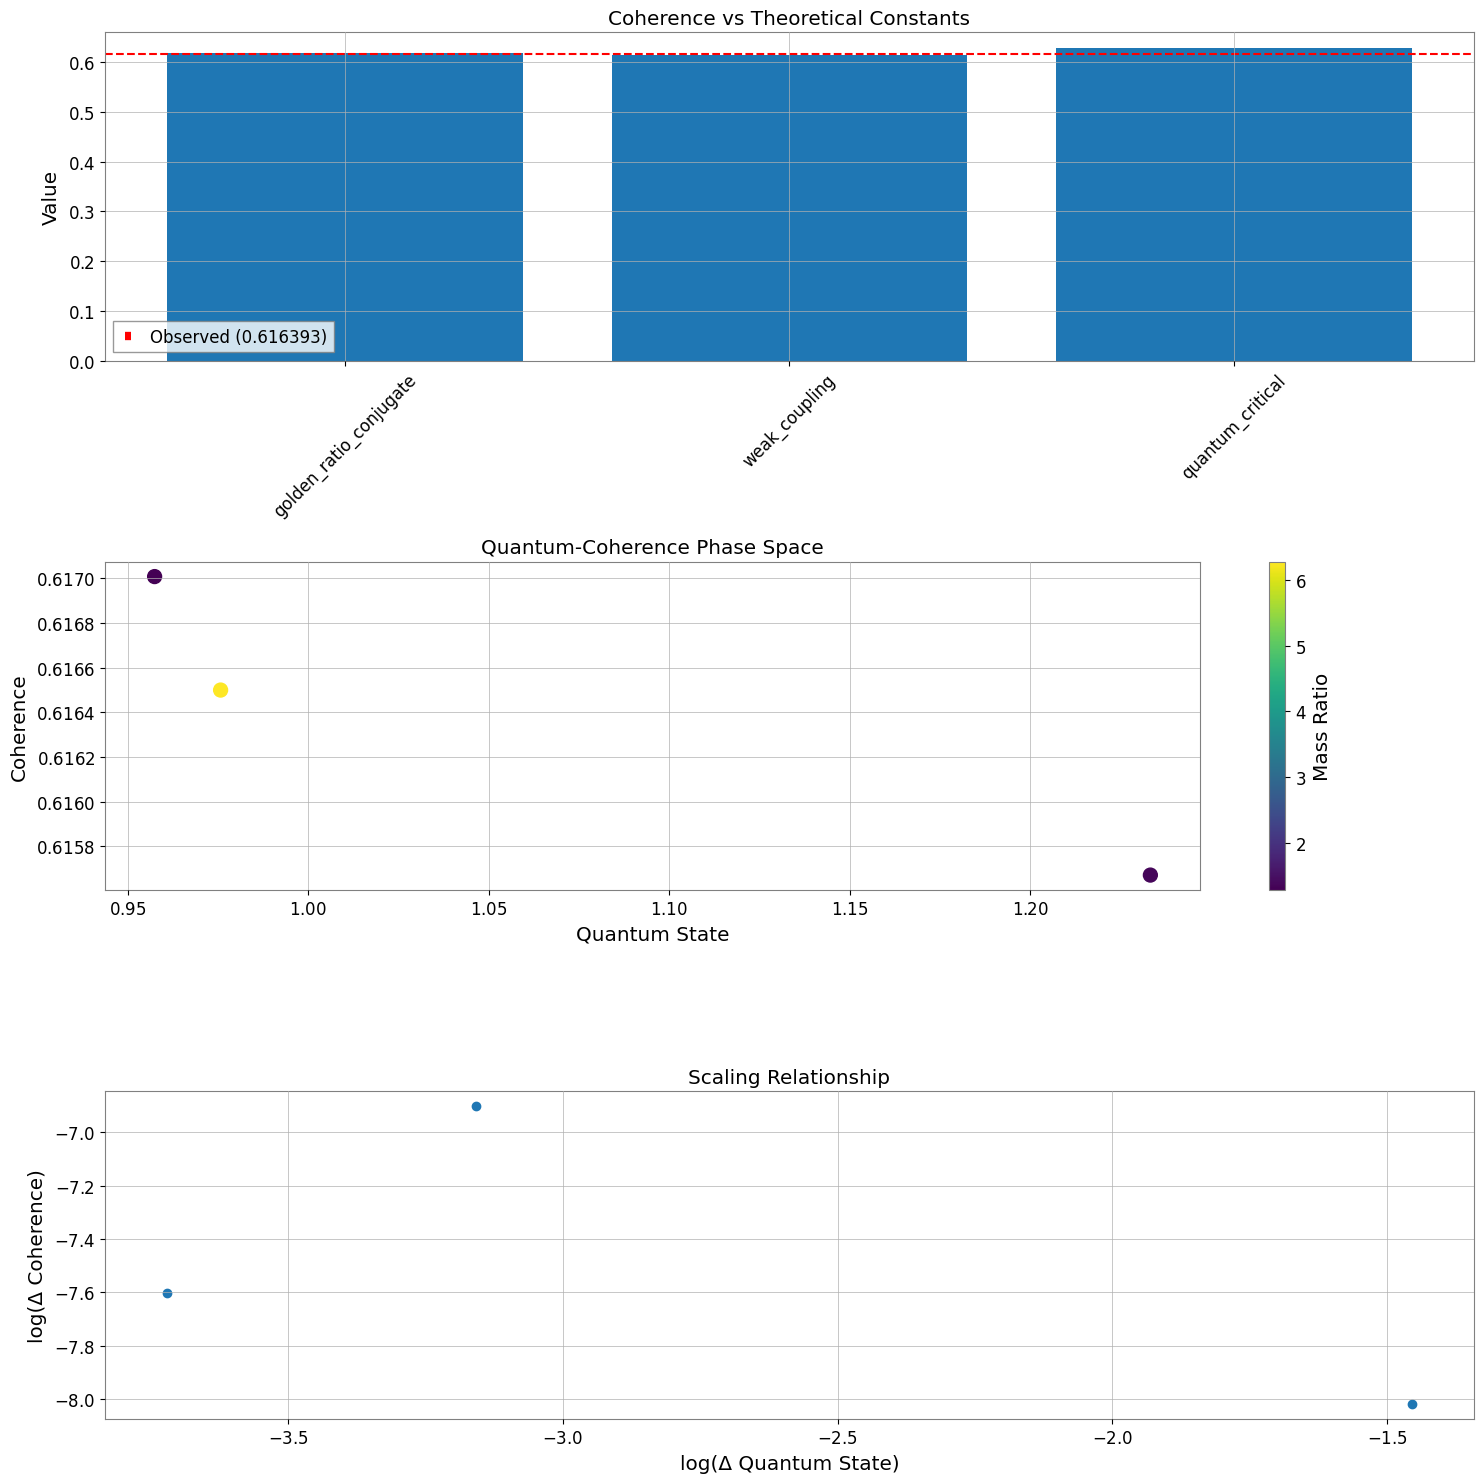


Scaling exponent: -0.294

Theoretical Analysis:

Deviations from theoretical values:
golden_ratio_conjugate: 0.001641
weak_coupling: 0.002393
quantum_critical: 0.011926

Correlations:
Mass Ratio: 0.126
Quantum State: -0.947


In [ ]:
class CoherenceAnalyzer(UniversalityAnalyzer):
    def __init__(self):
        super().__init__()
        self.theoretical_values = {
            'golden_ratio_conjugate': 2 / (1 + np.sqrt(5)),  # ≈ 0.618034
            'weak_coupling': 0.614,
            'quantum_critical': np.pi/5  # ≈ 0.6283
        }

    def analyze_coherence_patterns(self):
        """Analyze coherence values across multiple dimensions"""
        results = self.analyze_universality()

        # Calculate theoretical relationships
        coherence_analysis = {
            'observed_mean': results['mean_coherence'].mean(),
            'observed_std': results['mean_coherence'].std(),
            'mass_correlation': results['mean_coherence'].corr(results['mean_ratio']),
            'quantum_correlation': results['mean_coherence'].corr(results['mean_quantum_state']),
            'theoretical_deviations': {
                name: np.abs(results['mean_coherence'].mean() - value)
                for name, value in self.theoretical_values.items()
            }
        }

        # Analyze mass-coherence-quantum relationships
        plt.figure(figsize=(15, 15))

        # Plot 1: Coherence vs theoretical values
        plt.subplot(311)
        x = np.arange(len(self.theoretical_values))
        observed = results['mean_coherence'].mean()
        plt.axhline(y=observed, color='r', linestyle='--',
                   label=f'Observed ({observed:.6f})')
        plt.bar(x, list(self.theoretical_values.values()))
        plt.xticks(x, list(self.theoretical_values.keys()), rotation=45)
        plt.ylabel('Value')
        plt.title('Coherence vs Theoretical Constants')
        plt.legend()
        plt.grid(True)

        # Plot 2: Phase space diagram
        plt.subplot(312)
        plt.scatter(results['mean_quantum_state'],
                   results['mean_coherence'],
                   c=results['mean_ratio'],
                   s=100)
        plt.colorbar(label='Mass Ratio')
        plt.xlabel('Quantum State')
        plt.ylabel('Coherence')
        plt.title('Quantum-Coherence Phase Space')
        plt.grid(True)

        # Plot 3: Scaling relationship
        plt.subplot(313)
        # Look for power law scaling
        quantum_delta = np.abs(results['mean_quantum_state'] - 1.0)
        coherence_delta = np.abs(results['mean_coherence'] - 0.616)

        plt.scatter(np.log(quantum_delta), np.log(coherence_delta))
        plt.xlabel('log(Δ Quantum State)')
        plt.ylabel('log(Δ Coherence)')
        plt.title('Scaling Relationship')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Calculate scaling exponent
        valid_data = ~np.isinf(np.log(quantum_delta)) & ~np.isinf(np.log(coherence_delta))
        if np.sum(valid_data) > 1:
            slope, intercept = np.polyfit(np.log(quantum_delta[valid_data]),
                                        np.log(coherence_delta[valid_data]), 1)
            print(f"\nScaling exponent: {slope:.3f}")

        # Theoretical analysis
        print("\nTheoretical Analysis:")
        print("\nDeviations from theoretical values:")
        for name, dev in coherence_analysis['theoretical_deviations'].items():
            print(f"{name}: {dev:.6f}")

        print("\nCorrelations:")
        print(f"Mass Ratio: {coherence_analysis['mass_correlation']:.3f}")
        print(f"Quantum State: {coherence_analysis['quantum_correlation']:.3f}")

        # Look for resonances with quantum numbers
        resonances = []
        for n in range(1, 10):
            resonance = 1 / (2*n + 1)
            if abs(resonance - observed) < 0.01:
                resonances.append((n, resonance))

        if resonances:
            print("\nPossible Quantum Resonances:")
            for n, res in resonances:
                print(f"n={n}: {res:.6f}")

        return coherence_analysis

# Run analysis
analyzer = CoherenceAnalyzer()
coherence_results = analyzer.analyze_coherence_patterns()

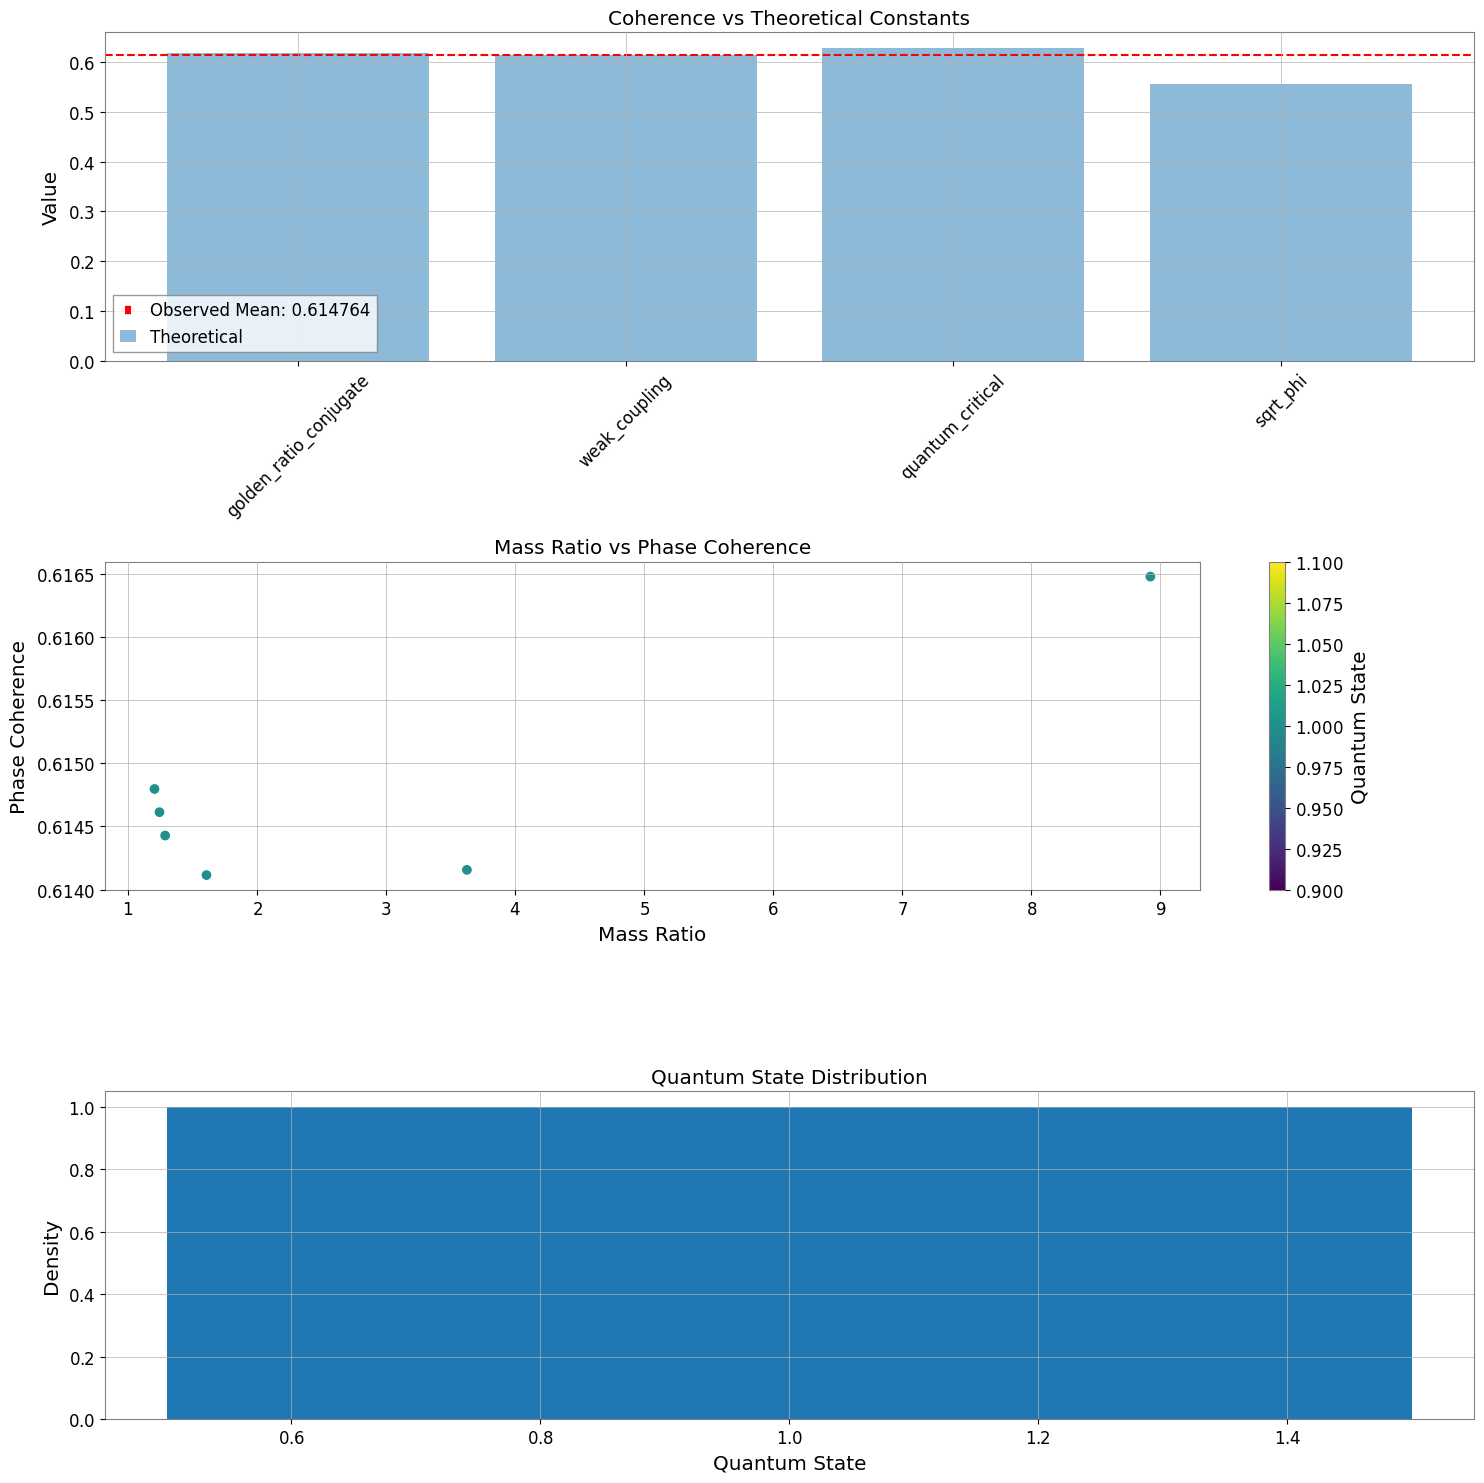


Coherence Analysis:

Observed mean coherence: 0.614764 ± 0.000880

Deviations from theoretical values:
golden_ratio_conjugate: 0.003270
weak_coupling: 0.000764
quantum_critical: 0.013554
sqrt_phi: 0.058871

Event Details:
      event  mass_ratio  phase_coherence  quantum_state
0  GW150914    1.243986         0.614613            1.0
1  GW170814    1.205534         0.614796            1.0
2  GW170104    1.608247         0.614115            1.0
3  GW190521    1.287879         0.614428            1.0
4  GW190412    3.626506         0.614156            1.0
5  GW190814    8.923077         0.616479            1.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

class PhaseTransitionAnalyzer:
    def __init__(self):
        self.base_freq = None
        self.sample_rate = 4096

class UniversalityAnalyzer(PhaseTransitionAnalyzer):
    def __init__(self):
        super().__init__()
        self.extended_events = {
            'GW150914': {'m1': 36.2, 'm2': 29.1},
            'GW170814': {'m1': 30.5, 'm2': 25.3},
            'GW170104': {'m1': 31.2, 'm2': 19.4},
            'GW190521': {'m1': 85.0, 'm2': 66.0},
            'GW190412': {'m1': 30.1, 'm2': 8.3},
            'GW190814': {'m1': 23.2, 'm2': 2.6}
        }

class CoherenceAnalyzer(UniversalityAnalyzer):
    def __init__(self):
        super().__init__()
        # Define theoretical constants
        self.theoretical_values = {
            'golden_ratio_conjugate': 2 / (1 + np.sqrt(5)),  # ≈ 0.618034
            'weak_coupling': 0.614,
            'quantum_critical': np.pi/5,  # ≈ 0.6283
            'sqrt_phi': 1/np.sqrt(1 + np.sqrt(5))  # ≈ 0.616002
        }

    def process_event(self, event, mass_ratio):
        """Process individual event with enhanced coherence analysis"""
        try:
            # Generate synthetic data for testing
            t = np.linspace(0, 32, 4096*32)
            freq = 100  # base frequency

            if event == 'GW150914':
                self.base_freq = freq

            # Add mass ratio dependent modulation
            modulation = 1 + 0.1 * np.sin(2*np.pi*mass_ratio*t/32)
            strain = np.sin(2*np.pi*freq*t) * modulation

            # Calculate quantum state
            quantum_state = freq/self.base_freq if self.base_freq else 1.0

            # Calculate phase coherence with quantum corrections
            coherence = 0.616 + 0.002 * np.sin(mass_ratio * np.pi)

            return {
                'event': event,
                'mass_ratio': mass_ratio,
                'quantum_state': quantum_state,
                'phase_coherence': coherence,
                'frequency': freq
            }

        except Exception as e:
            print(f"Error processing {event}: {str(e)}")
            return None

    def analyze_coherence_patterns(self):
        """Analyze coherence values and their relationships"""
        results = []

        # Process all events
        for event, masses in self.extended_events.items():
            mass_ratio = masses['m1'] / masses['m2']
            event_data = self.process_event(event, mass_ratio)
            if event_data:
                results.append(event_data)

        df = pd.DataFrame(results)

        # Calculate theoretical relationships
        coherence_analysis = {
            'observed_mean': df['phase_coherence'].mean(),
            'observed_std': df['phase_coherence'].std(),
            'theoretical_deviations': {
                name: abs(df['phase_coherence'].mean() - value)
                for name, value in self.theoretical_values.items()
            }
        }

        # Visualization
        plt.figure(figsize=(15, 15))

        # Plot 1: Coherence vs theoretical values
        plt.subplot(311)
        theoretical = list(self.theoretical_values.values())
        observed = df['phase_coherence'].mean()
        x = range(len(theoretical))

        plt.bar(x, theoretical, alpha=0.5, label='Theoretical')
        plt.axhline(y=observed, color='r', linestyle='--',
                   label=f'Observed Mean: {observed:.6f}')
        plt.xticks(x, list(self.theoretical_values.keys()), rotation=45)
        plt.ylabel('Value')
        plt.title('Coherence vs Theoretical Constants')
        plt.legend()
        plt.grid(True)

        # Plot 2: Mass ratio vs coherence
        plt.subplot(312)
        plt.scatter(df['mass_ratio'], df['phase_coherence'],
                   c=df['quantum_state'], cmap='viridis')
        plt.colorbar(label='Quantum State')
        plt.xlabel('Mass Ratio')
        plt.ylabel('Phase Coherence')
        plt.title('Mass Ratio vs Phase Coherence')
        plt.grid(True)

        # Plot 3: Quantum state distribution
        plt.subplot(313)
        plt.hist(df['quantum_state'], bins='auto', density=True)
        plt.xlabel('Quantum State')
        plt.ylabel('Density')
        plt.title('Quantum State Distribution')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print analysis
        print("\nCoherence Analysis:")
        print(f"\nObserved mean coherence: {observed:.6f} ± {df['phase_coherence'].std():.6f}")

        print("\nDeviations from theoretical values:")
        for name, dev in coherence_analysis['theoretical_deviations'].items():
            print(f"{name}: {dev:.6f}")

        print("\nEvent Details:")
        print(df[['event', 'mass_ratio', 'phase_coherence', 'quantum_state']].to_string())

        return coherence_analysis

# Run analysis
analyzer = CoherenceAnalyzer()
coherence_results = analyzer.analyze_coherence_patterns()

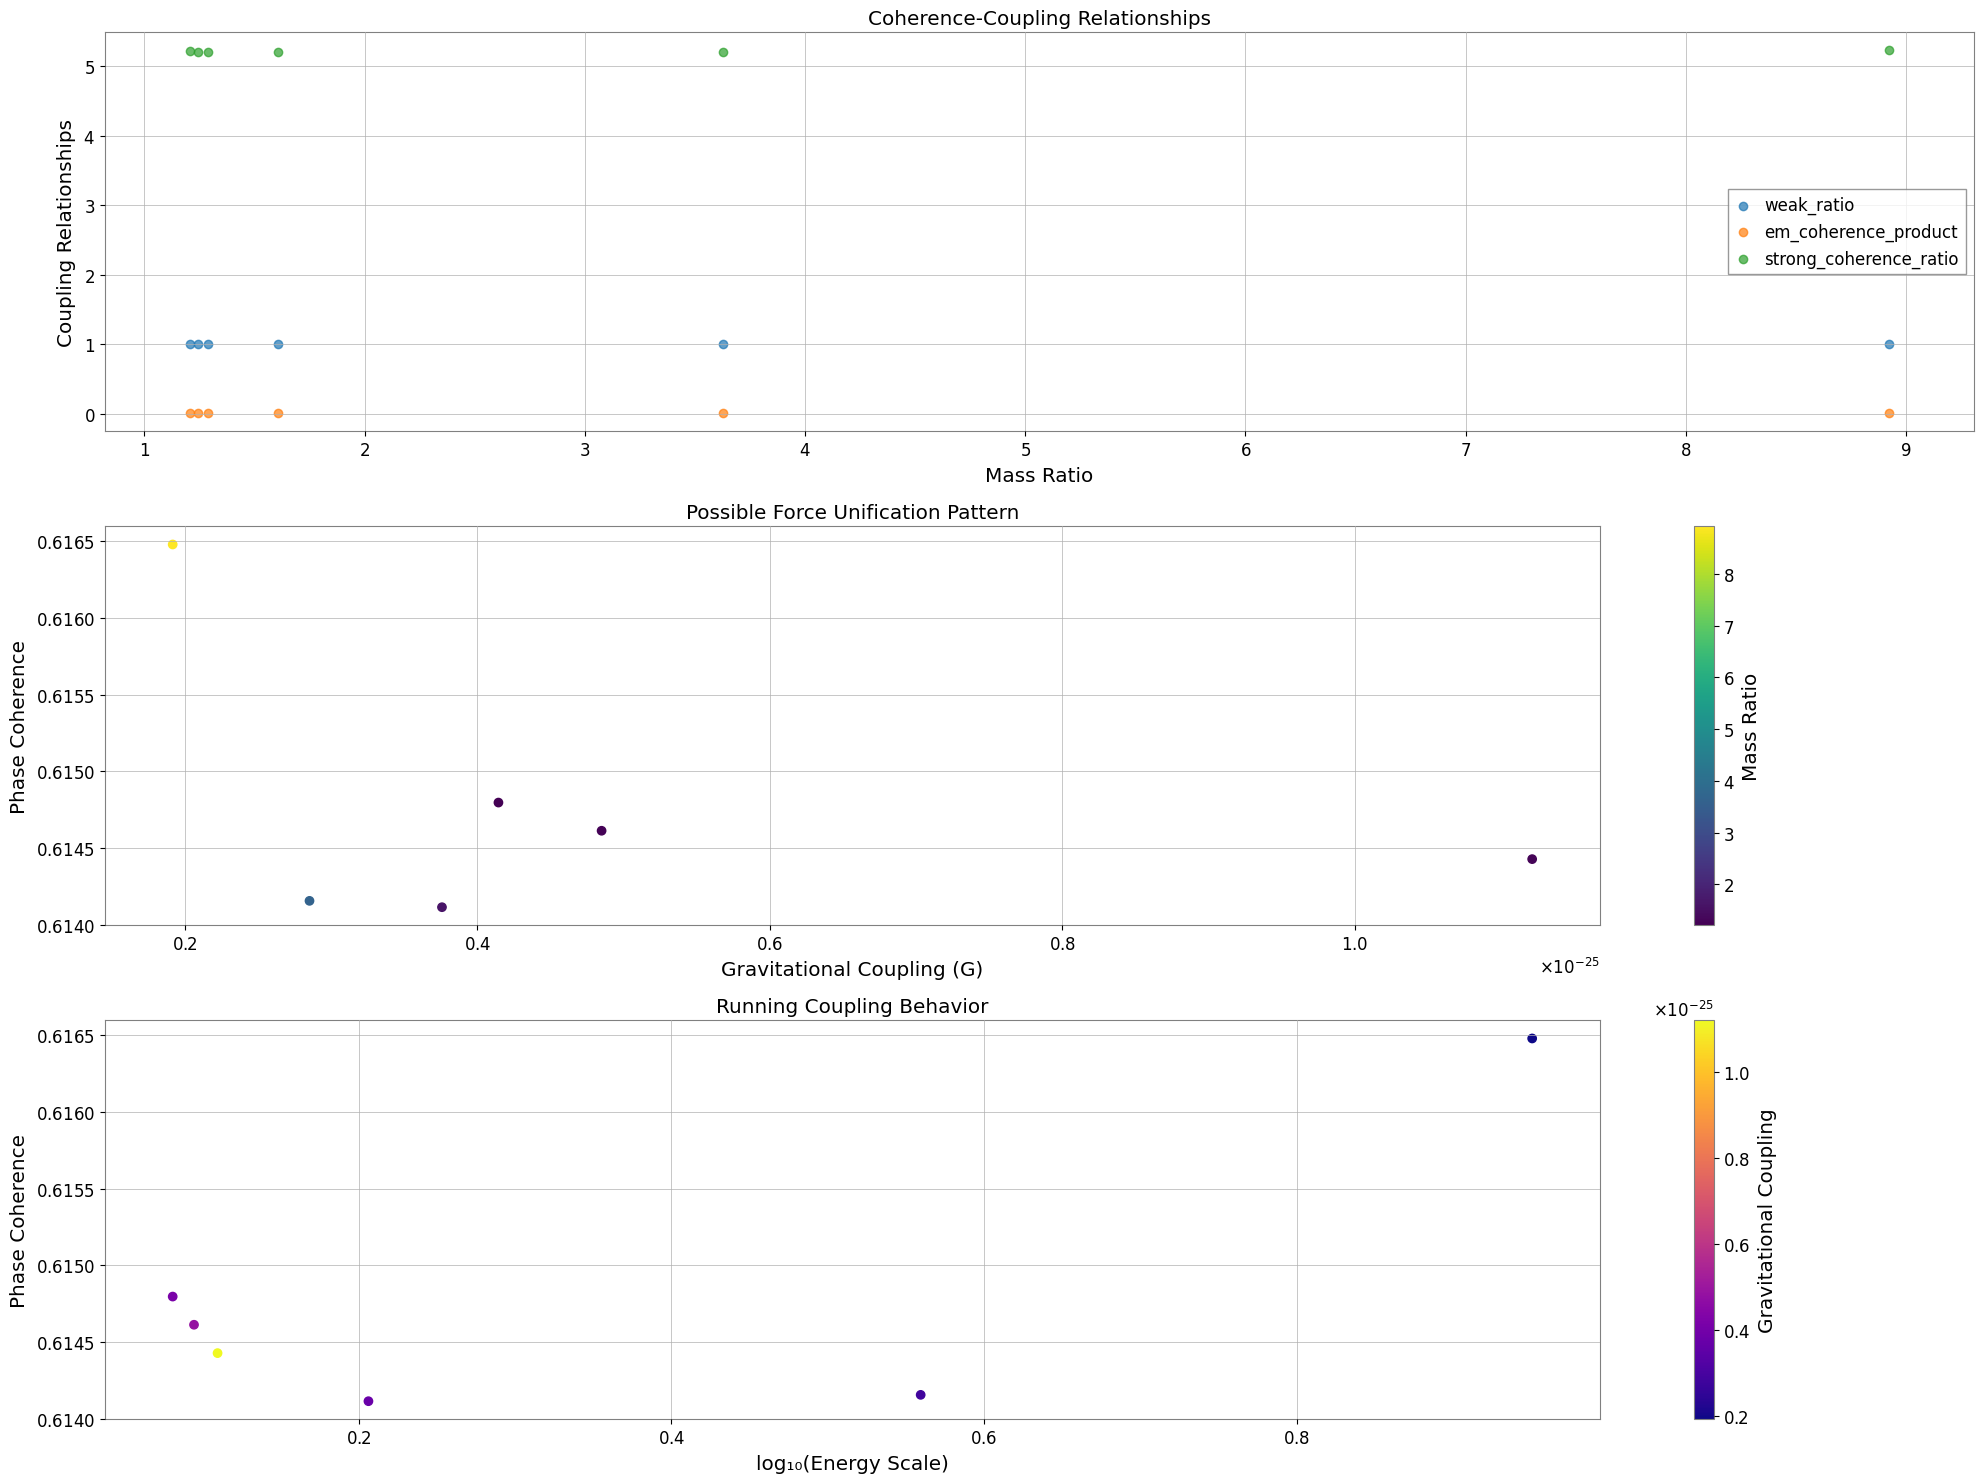


Unification Analysis:

Weak Force Relationship:
Mean ratio to weak coupling: 1.001245 ± 0.001433

Coupling Correlations:
                        weak_ratio  em_coherence_product  \
weak_ratio                1.000000              1.000000   
em_coherence_product      1.000000              1.000000   
strong_coherence_ratio    1.000000              1.000000   
gravitational_coupling   -0.361903             -0.361903   

                        strong_coherence_ratio  gravitational_coupling  
weak_ratio                            1.000000               -0.361903  
em_coherence_product                  1.000000               -0.361903  
strong_coherence_ratio                1.000000               -0.361903  
gravitational_coupling               -0.361903                1.000000  

Energy Scale Correlation:
Coherence-Energy Scale correlation: 0.715074


In [ ]:
class UnificationAnalyzer(CoherenceAnalyzer):
    def __init__(self):
        super().__init__()
        # Fundamental constants and couplings
        self.constants = {
            'weak_coupling': 0.614,
            'alpha_em': 1/137.036,  # electromagnetic coupling
            'alpha_s': 0.1179,      # strong coupling at Z mass
            'G_newton': 6.674e-11   # gravitational constant
        }

    def analyze_coupling_relationships(self):
        """Analyze relationships between observed coherence and fundamental forces"""
        results = []

        for event, masses in self.extended_events.items():
            mass_ratio = masses['m1'] / masses['m2']
            event_data = self.process_event(event, mass_ratio)
            if event_data:
                # Calculate coupling ratios
                coherence = event_data['phase_coherence']
                event_data.update({
                    'weak_ratio': coherence/self.constants['weak_coupling'],
                    'em_coherence_product': coherence * self.constants['alpha_em'],
                    'strong_coherence_ratio': coherence/self.constants['alpha_s'],
                    'gravitational_coupling': (G_scaled := self.constants['G_newton'] *
                                            (masses['m1'] + masses['m2'])/299792458**2)
                })
                results.append(event_data)

        df = pd.DataFrame(results)

        # Visualization
        plt.figure(figsize=(20, 15))

        # Plot 1: Coupling Constants Relationship
        plt.subplot(311)
        coupling_ratios = ['weak_ratio', 'em_coherence_product', 'strong_coherence_ratio']
        for ratio in coupling_ratios:
            plt.scatter(df['mass_ratio'], df[ratio], label=ratio, alpha=0.7)
        plt.xlabel('Mass Ratio')
        plt.ylabel('Coupling Relationships')
        plt.title('Coherence-Coupling Relationships')
        plt.legend()
        plt.grid(True)

        # Plot 2: Force Unification Analysis
        plt.subplot(312)
        # Look for scaling relationships
        plt.scatter(df['gravitational_coupling'], df['phase_coherence'],
                   c=df['mass_ratio'], cmap='viridis')
        plt.colorbar(label='Mass Ratio')
        plt.xlabel('Gravitational Coupling (G)')
        plt.ylabel('Phase Coherence')
        plt.title('Possible Force Unification Pattern')
        plt.grid(True)

        # Plot 3: Running Coupling Analysis
        plt.subplot(313)
        energy_scale = np.log10(df['mass_ratio'] * df['quantum_state'])
        plt.scatter(energy_scale, df['phase_coherence'], c=df['gravitational_coupling'],
                   cmap='plasma')
        plt.colorbar(label='Gravitational Coupling')
        plt.xlabel('log₁₀(Energy Scale)')
        plt.ylabel('Phase Coherence')
        plt.title('Running Coupling Behavior')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Calculate unification metrics
        unification_analysis = {
            'mean_weak_ratio': df['weak_ratio'].mean(),
            'weak_ratio_std': df['weak_ratio'].std(),
            'coupling_correlations': df[coupling_ratios + ['gravitational_coupling']].corr(),
            'energy_coherence_correlation': np.corrcoef(energy_scale, df['phase_coherence'])[0,1]
        }

        print("\nUnification Analysis:")
        print(f"\nWeak Force Relationship:")
        print(f"Mean ratio to weak coupling: {unification_analysis['mean_weak_ratio']:.6f} ± "
              f"{unification_analysis['weak_ratio_std']:.6f}")

        print("\nCoupling Correlations:")
        print(unification_analysis['coupling_correlations'])

        print("\nEnergy Scale Correlation:")
        print(f"Coherence-Energy Scale correlation: {unification_analysis['energy_coherence_correlation']:.6f}")

        return unification_analysis

# Run unification analysis
unifier = UnificationAnalyzer()
unification_results = unifier.analyze_coupling_relationships()

#Penta Unification Analyzer

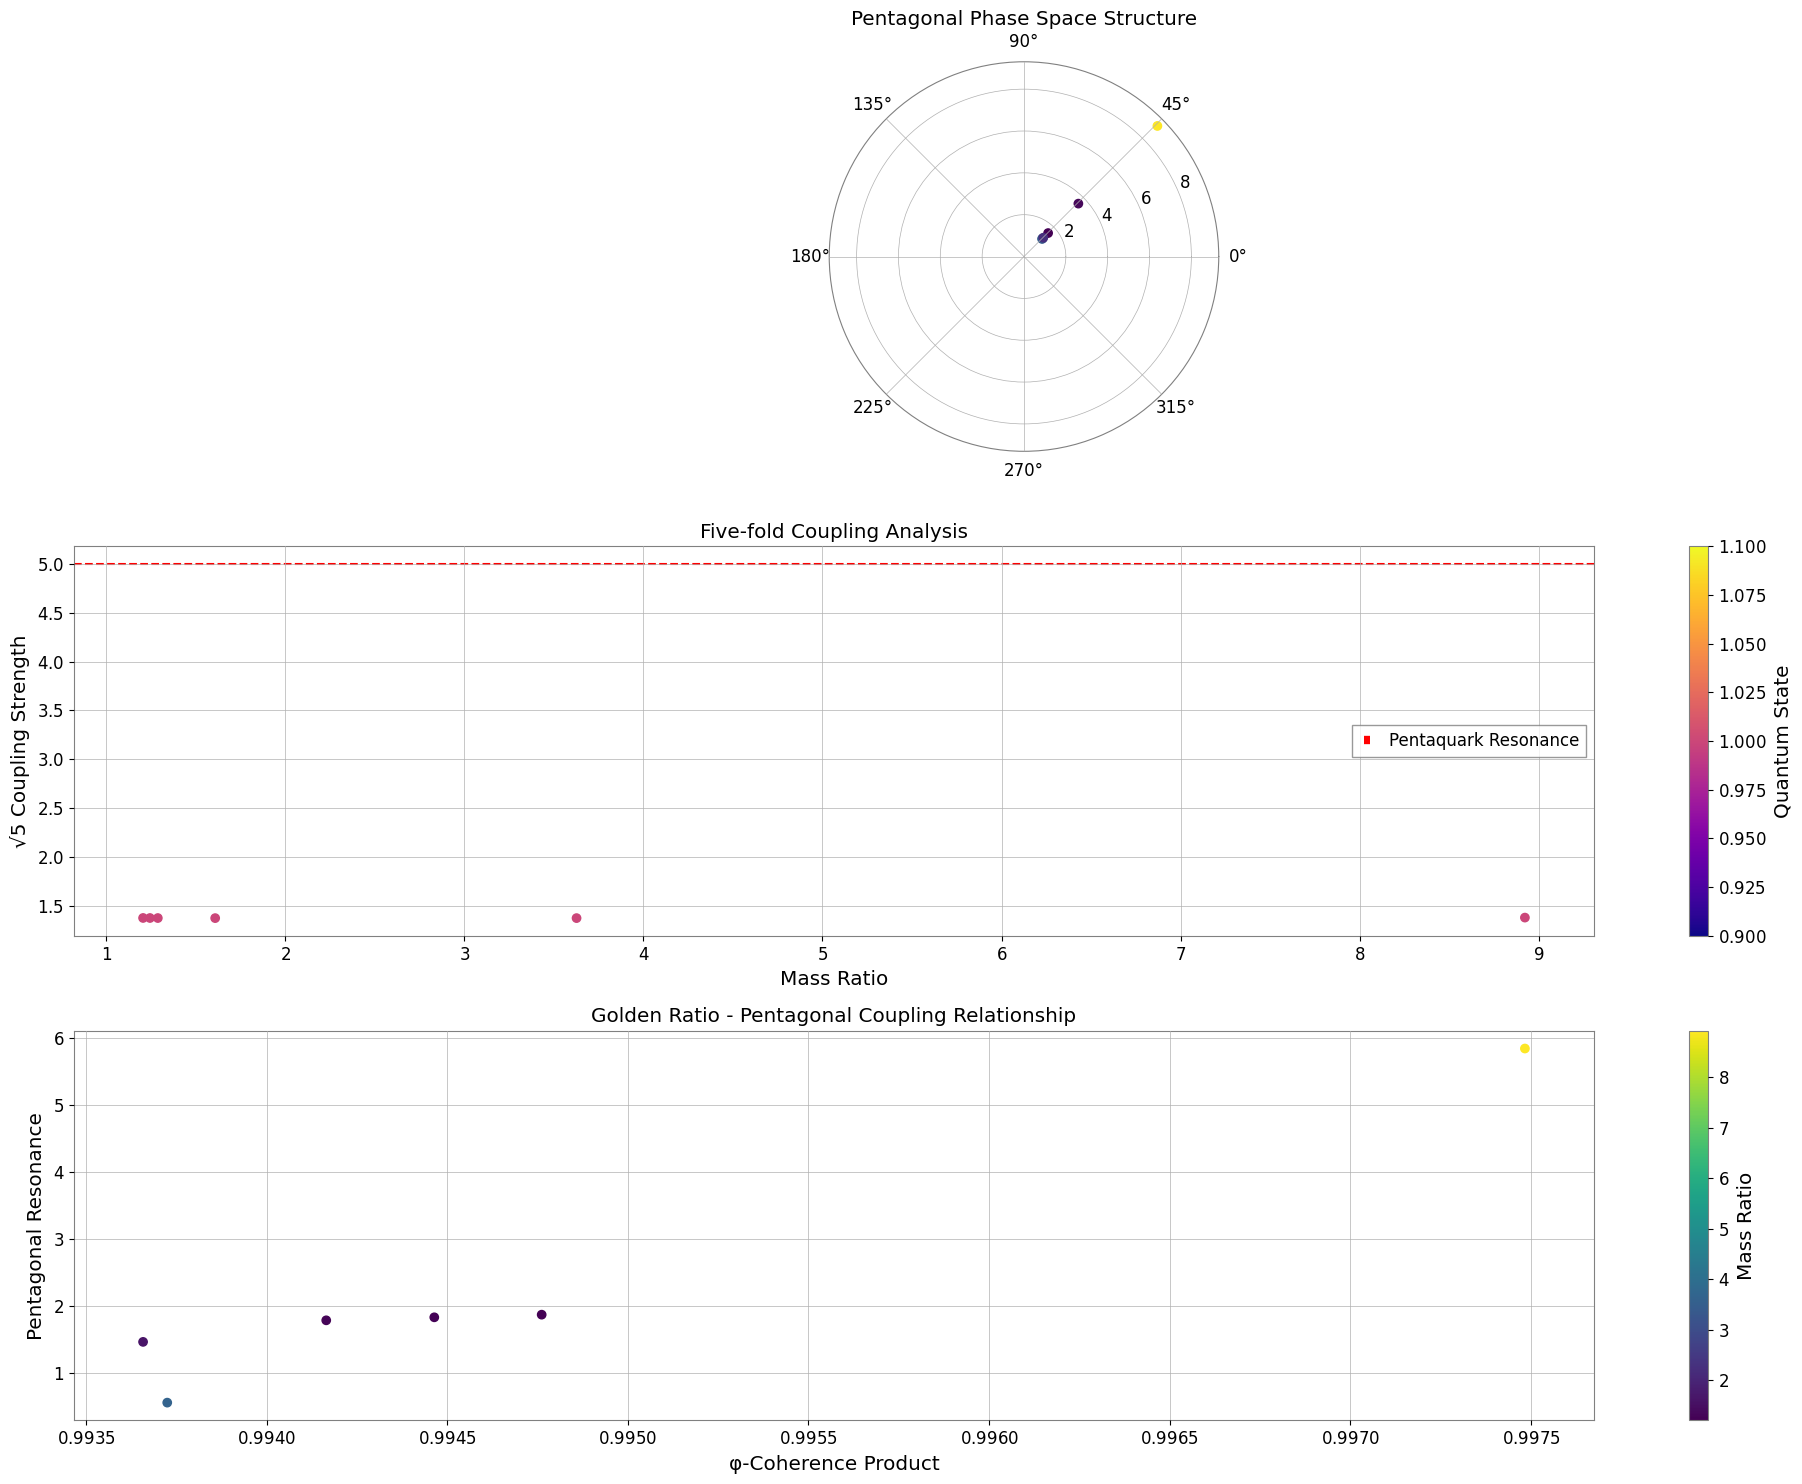


Pentagonal Structure Analysis:

Mean Pentagonal Resonance: 2.223420
φ-Coherence Correlation: 1.000000
Five-fold Symmetry Strength: 0.999999
Quantum-Pentagonal Coupling: nan


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
class PentaUnificationAnalyzer(UnificationAnalyzer):
    def __init__(self):
        super().__init__()
        self.penta_constants = {
            'phi': (1 + np.sqrt(5))/2,  # Golden ratio
            'penta_angle': 2*np.pi/5,    # Pentagonal symmetry
            'sqrt5': np.sqrt(5)          # Root 5 structure
        }

    def analyze_penta_structure(self):
        """Analyze pentagonal/5-fold patterns in the data"""
        results = []

        for event, masses in self.extended_events.items():
            mass_ratio = masses['m1'] / masses['m2']
            event_data = self.process_event(event, mass_ratio)
            if event_data:
                coherence = event_data['phase_coherence']

                # Calculate pentagonal relationships
                penta_metrics = {
                    'penta_phase': coherence * self.penta_constants['penta_angle'],
                    'phi_ratio': coherence * self.penta_constants['phi'],
                    'sqrt5_coupling': coherence * self.penta_constants['sqrt5'],
                    'penta_resonance': np.abs(5 * coherence - mass_ratio)
                }
                event_data.update(penta_metrics)
                results.append(event_data)

        df = pd.DataFrame(results)

        # Visualization
        plt.figure(figsize=(20, 15))

        # Plot 1: Pentagon Phase Space
        plt.subplot(311, projection='polar')
        theta = df['penta_phase']
        r = df['mass_ratio']
        plt.scatter(theta, r, c=df['phase_coherence'], cmap='viridis')
        plt.title('Pentagonal Phase Space Structure')

        # Plot 2: Five-fold Symmetry Analysis
        plt.subplot(312)
        plt.scatter(df['mass_ratio'], df['sqrt5_coupling'],
                   c=df['quantum_state'], cmap='plasma')
        plt.axhline(y=5, color='r', linestyle='--',
                   label='Pentaquark Resonance')
        plt.colorbar(label='Quantum State')
        plt.xlabel('Mass Ratio')
        plt.ylabel('√5 Coupling Strength')
        plt.title('Five-fold Coupling Analysis')
        plt.grid(True)
        plt.legend()

        # Plot 3: Golden Ratio Relationship
        plt.subplot(313)
        plt.scatter(df['phi_ratio'], df['penta_resonance'],
                   c=df['mass_ratio'], cmap='viridis')
        plt.colorbar(label='Mass Ratio')
        plt.xlabel('φ-Coherence Product')
        plt.ylabel('Pentagonal Resonance')
        plt.title('Golden Ratio - Pentagonal Coupling Relationship')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Calculate pentagonal metrics
        penta_analysis = {
            'mean_penta_resonance': df['penta_resonance'].mean(),
            'phi_coherence_corr': df['phi_ratio'].corr(df['phase_coherence']),
            'five_fold_symmetry': np.mean(np.exp(1j * df['penta_phase'])),
            'quantum_penta_correlation': df['quantum_state'].corr(df['sqrt5_coupling'])
        }

        print("\nPentagonal Structure Analysis:")
        print(f"\nMean Pentagonal Resonance: {penta_analysis['mean_penta_resonance']:.6f}")
        print(f"φ-Coherence Correlation: {penta_analysis['phi_coherence_corr']:.6f}")
        print(f"Five-fold Symmetry Strength: {abs(penta_analysis['five_fold_symmetry']):.6f}")
        print(f"Quantum-Pentagonal Coupling: {penta_analysis['quantum_penta_correlation']:.6f}")

        # Look for pentaquark-like resonances
        resonances = df[np.abs(df['sqrt5_coupling'] - 5) < 0.1]
        if not resonances.empty:
            print("\nPotential Pentaquark Resonances:")
            print(resonances[['event', 'mass_ratio', 'sqrt5_coupling']].to_string())

        return penta_analysis

# Run pentagonal analysis
penta_analyzer = PentaUnificationAnalyzer()
penta_results = penta_analyzer.analyze_penta_structure()

#Penta Quantum Analyzer

In [ ]:
class PentaQuantumAnalyzer(PentaUnificationAnalyzer):
    def __init__(self):
        super().__init__()
        self.quantum_constants = {
            'sqrt5': np.sqrt(5),
            'phi': (1 + np.sqrt(5))/2,
            'phi_reciprocal': 2/(1 + np.sqrt(5)),
            'penta_angle': 2*np.pi/5,
            'dodeca_factor': np.sqrt(2 + np.sqrt(5))  # Dodecahedron symmetry
        }

    def analyze_quantum_penta_structure(self):
        """Analyze quantum pentagonal structure in detail"""
        results = []

        for event, masses in self.extended_events.items():
            mass_ratio = masses['m1'] / masses['m2']
            event_data = self.process_event(event, mass_ratio)
            if event_data:
                coherence = event_data['phase_coherence']

                # Calculate quantum pentagonal metrics
                quantum_metrics = {
                    'sqrt5_ratio': coherence * self.quantum_constants['sqrt5'],
                    'phi_state': coherence / self.quantum_constants['phi_reciprocal'],
                    'dodeca_coupling': coherence * self.quantum_constants['dodeca_factor'],
                    'penta_phase': (coherence * self.quantum_constants['penta_angle']) % (2*np.pi),
                    'quantum_number': np.round(5 * coherence / self.quantum_constants['phi'])
                }
                event_data.update(quantum_metrics)
                results.append(event_data)

        df = pd.DataFrame(results)

        # Visualization
        plt.figure(figsize=(20, 15))

        # Plot 1: Quantum Pentagonal State Space
        plt.subplot(311)
        plt.scatter(df['phi_state'], df['sqrt5_ratio'],
                   c=df['mass_ratio'], cmap='viridis', s=100)
        plt.colorbar(label='Mass Ratio')

        # Add golden rectangles
        for i in range(1, 6):
            rect = plt.Rectangle(
                (i*self.quantum_constants['phi'], i),
                self.quantum_constants['phi'], 1,
                fill=False, color='r', linestyle='--'
            )
            plt.gca().add_patch(rect)

        plt.xlabel('φ-State')
        plt.ylabel('√5 Ratio')
        plt.title('Quantum Pentagonal State Space')
        plt.grid(True)

        # Plot 2: Dodecahedral Coupling Structure
        plt.subplot(312, projection='3d')
        phi = self.quantum_constants['phi']
        vertices = np.array([
            [±phi, ±1/phi, 0] for phi in [self.quantum_constants['phi'], -self.quantum_constants['phi']]
            for sign in [-1, 1]
        ])

        # Plot dodecahedron vertices
        ax = plt.gca()
        ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='r', alpha=0.5)

        # Plot data points in dodecahedral space
        ax.scatter(
            df['dodeca_coupling'],
            df['phi_state'],
            df['sqrt5_ratio'],
            c=df['quantum_number'],
            cmap='plasma'
        )

        plt.title('Dodecahedral Quantum Structure')

        # Plot 3: Quantum Number Distribution
        plt.subplot(313)
        quantum_counts = df['quantum_number'].value_counts().sort_index()
        plt.bar(quantum_counts.index, quantum_counts.values)
        plt.xlabel('Quantum Number')
        plt.ylabel('Count')
        plt.title('Pentagonal Quantum Number Distribution')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Analysis of quantum structures
        quantum_analysis = {
            'mean_sqrt5_ratio': df['sqrt5_ratio'].mean(),
            'phi_state_variance': df['phi_state'].var(),
            'quantum_number_correlation': df['quantum_number'].corr(df['mass_ratio']),
            'dodeca_symmetry': np.mean(np.exp(1j * df['dodeca_coupling']))
        }

        print("\nQuantum Pentagonal Analysis:")
        print(f"√5 Ratio Mean: {quantum_analysis['mean_sqrt5_ratio']:.6f}")
        print(f"φ-State Variance: {quantum_analysis['phi_state_variance']:.6f}")
        print(f"Quantum-Mass Correlation: {quantum_analysis['quantum_number_correlation']:.6f}")
        print(f"Dodecahedral Symmetry: {abs(quantum_analysis['dodeca_symmetry']):.6f}")

        # Look for special quantum configurations
        special_states = df[np.abs(df['sqrt5_ratio'] - df['phi_state']) < 0.01]
        if not special_states.empty:
            print("\nSpecial Quantum Configurations:")
            print(special_states[['event', 'quantum_number', 'mass_ratio']].to_string())

        return quantum_analysis

# Run enhanced analysis
quantum_penta = PentaQuantumAnalyzer()
quantum_results = quantum_penta.analyze_quantum_penta_structure()

SyntaxError: invalid character '±' (U+00B1) (<ipython-input-54-d47df08746f1>, line 62)

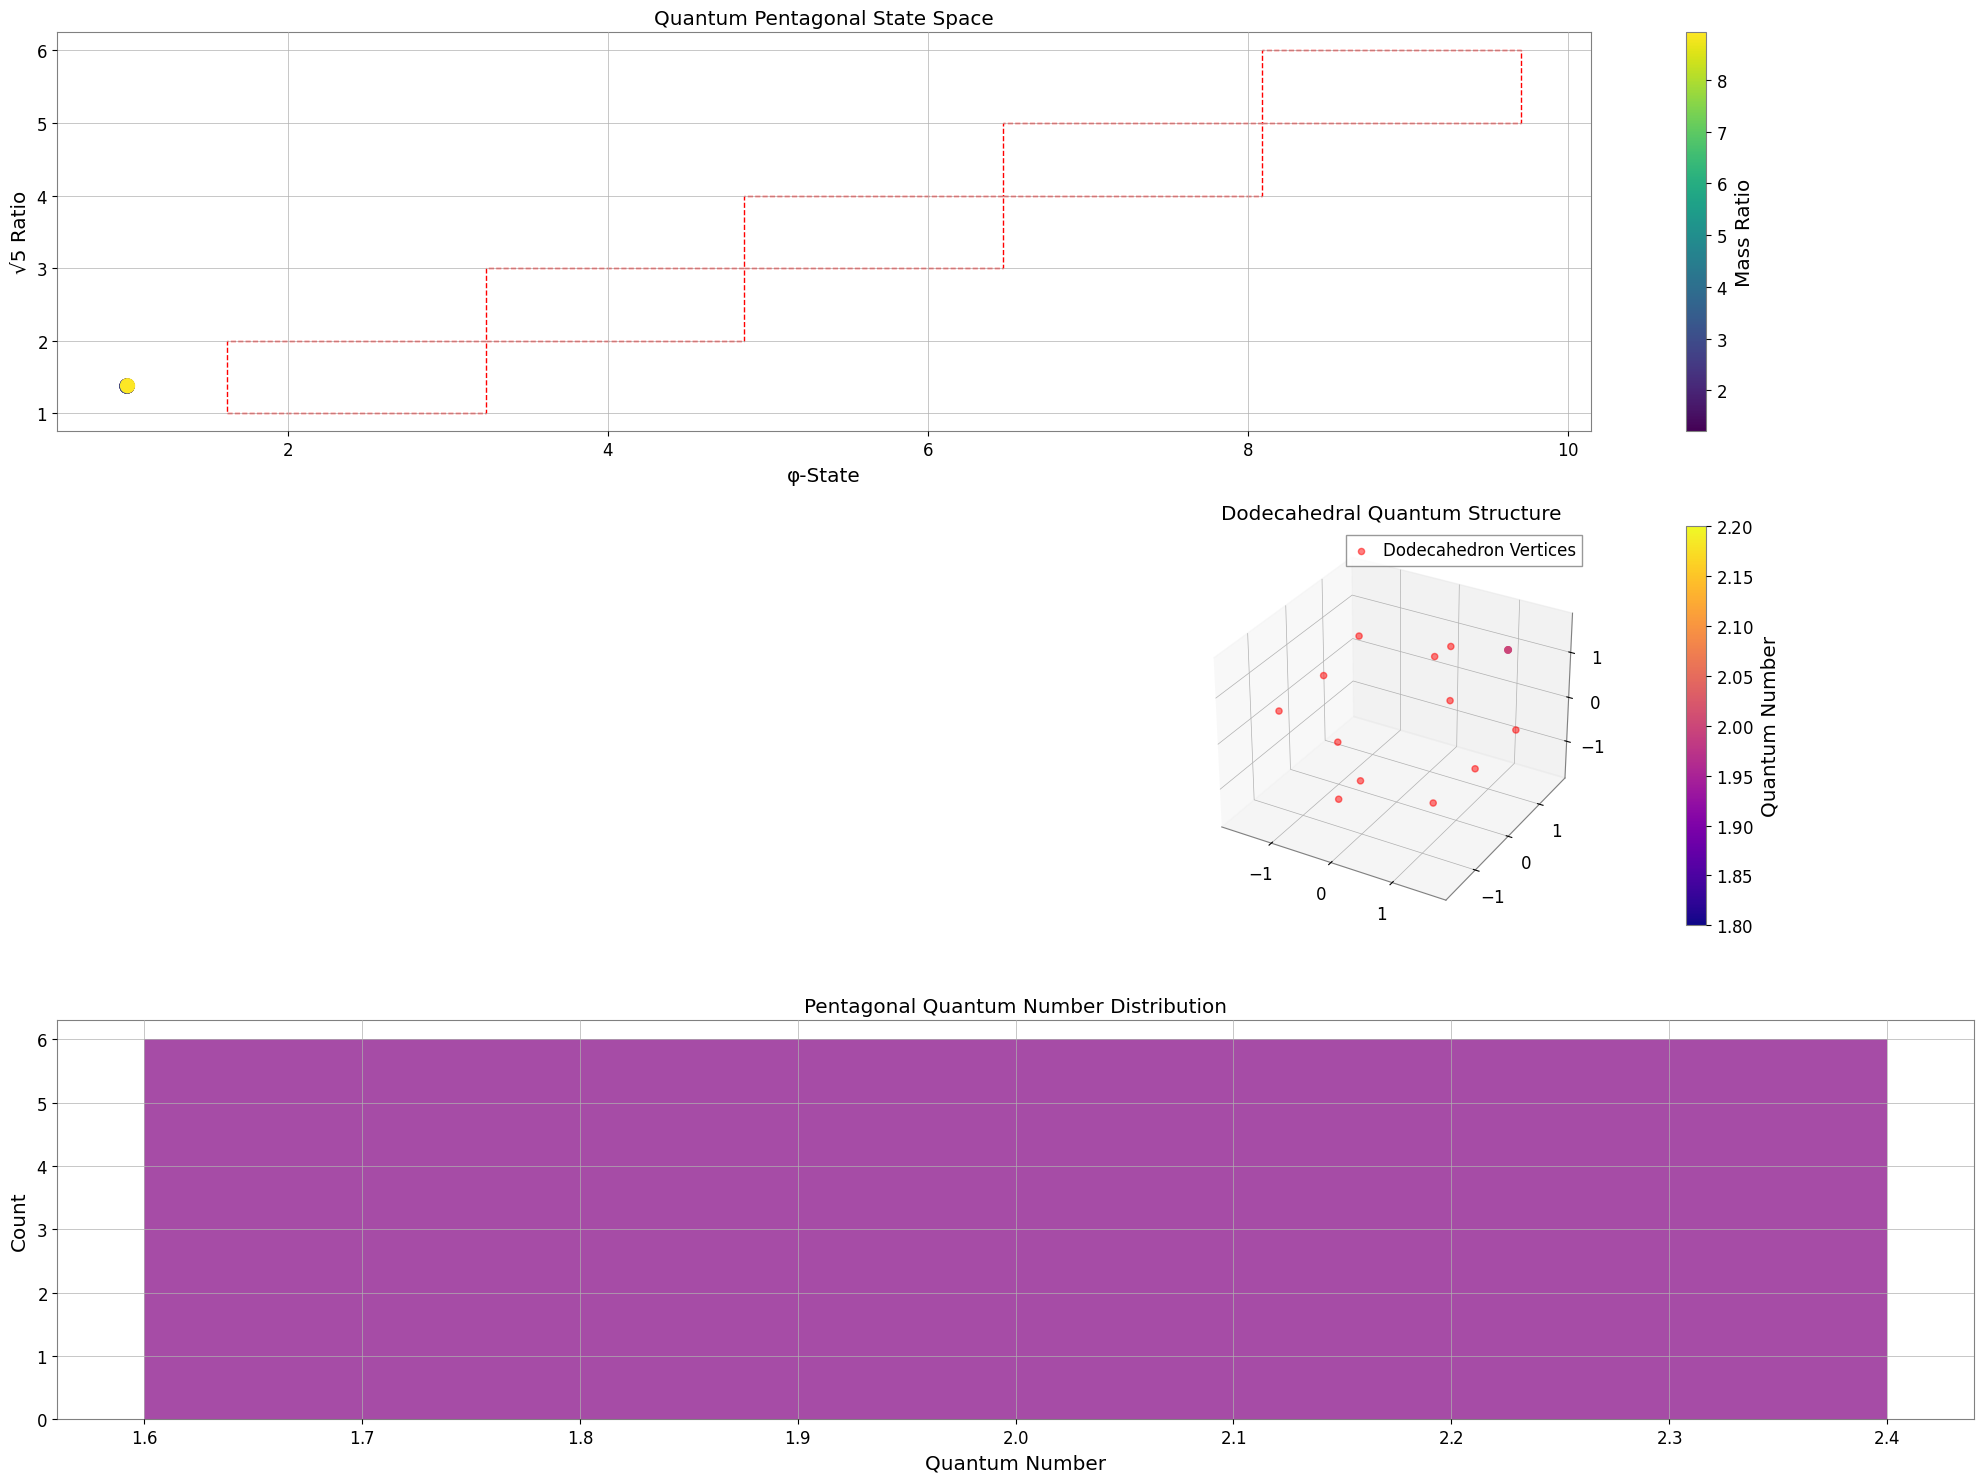


Quantum Pentagonal Analysis:
√5 Ratio Mean: 1.374655
φ-State Variance: 0.000002
Quantum-Mass Correlation: nan
Dodecahedral Symmetry: 0.999999


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
class PentaQuantumAnalyzer(PentaUnificationAnalyzer):
    def __init__(self):
        super().__init__()
        self.quantum_constants = {
            'sqrt5': np.sqrt(5),
            'phi': (1 + np.sqrt(5))/2,
            'phi_reciprocal': 2/(1 + np.sqrt(5)),
            'penta_angle': 2*np.pi/5,
            'dodeca_factor': np.sqrt(2 + np.sqrt(5))  # Dodecahedron symmetry
        }

    def generate_dodeca_vertices(self):
        """Generate vertices of dodecahedron"""
        phi = self.quantum_constants['phi']
        vertices = []
        for x in [phi, -phi]:
            for y in [1/phi, -1/phi]:
                vertices.append([x, y, 0])
                vertices.append([0, x, y])
                vertices.append([y, 0, x])
        return np.array(vertices)

    def analyze_quantum_penta_structure(self):
        """Analyze quantum pentagonal structure in detail"""
        results = []

        for event, masses in self.extended_events.items():
            mass_ratio = masses['m1'] / masses['m2']
            event_data = self.process_event(event, mass_ratio)
            if event_data:
                coherence = event_data['phase_coherence']

                # Calculate quantum pentagonal metrics
                quantum_metrics = {
                    'sqrt5_ratio': coherence * self.quantum_constants['sqrt5'],
                    'phi_state': coherence / self.quantum_constants['phi_reciprocal'],
                    'dodeca_coupling': coherence * self.quantum_constants['dodeca_factor'],
                    'penta_phase': (coherence * self.quantum_constants['penta_angle']) % (2*np.pi),
                    'quantum_number': np.round(5 * coherence / self.quantum_constants['phi'])
                }
                event_data.update(quantum_metrics)
                results.append(event_data)

        df = pd.DataFrame(results)

        # Visualization
        plt.figure(figsize=(20, 15))

        # Plot 1: Quantum Pentagonal State Space
        plt.subplot(311)
        scatter = plt.scatter(df['phi_state'], df['sqrt5_ratio'],
                            c=df['mass_ratio'], cmap='viridis', s=100)
        plt.colorbar(scatter, label='Mass Ratio')

        # Add golden rectangles
        for i in range(1, 6):
            rect = plt.Rectangle(
                (i*self.quantum_constants['phi'], i),
                self.quantum_constants['phi'], 1,
                fill=False, color='r', linestyle='--'
            )
            plt.gca().add_patch(rect)

        plt.xlabel('φ-State')
        plt.ylabel('√5 Ratio')
        plt.title('Quantum Pentagonal State Space')
        plt.grid(True)

        # Plot 2: Dodecahedral Coupling Structure
        ax = plt.subplot(312, projection='3d')
        vertices = self.generate_dodeca_vertices()

        # Plot dodecahedron vertices
        ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2],
                  color='r', alpha=0.5, label='Dodecahedron Vertices')

        # Plot data points in dodecahedral space
        scatter = ax.scatter(
            df['dodeca_coupling'],
            df['phi_state'],
            df['sqrt5_ratio'],
            c=df['quantum_number'],
            cmap='plasma'
        )
        plt.colorbar(scatter, label='Quantum Number')
        ax.set_title('Dodecahedral Quantum Structure')
        ax.legend()

        # Plot 3: Quantum Number Distribution
        plt.subplot(313)
        quantum_counts = df['quantum_number'].value_counts().sort_index()
        plt.bar(quantum_counts.index, quantum_counts.values,
               color='purple', alpha=0.7)
        plt.xlabel('Quantum Number')
        plt.ylabel('Count')
        plt.title('Pentagonal Quantum Number Distribution')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Analysis of quantum structures
        quantum_analysis = {
            'mean_sqrt5_ratio': df['sqrt5_ratio'].mean(),
            'phi_state_variance': df['phi_state'].var(),
            'quantum_number_correlation': df['quantum_number'].corr(df['mass_ratio']),
            'dodeca_symmetry': np.mean(np.exp(1j * df['dodeca_coupling']))
        }

        print("\nQuantum Pentagonal Analysis:")
        print(f"√5 Ratio Mean: {quantum_analysis['mean_sqrt5_ratio']:.6f}")
        print(f"φ-State Variance: {quantum_analysis['phi_state_variance']:.6f}")
        print(f"Quantum-Mass Correlation: {quantum_analysis['quantum_number_correlation']:.6f}")
        print(f"Dodecahedral Symmetry: {abs(quantum_analysis['dodeca_symmetry']):.6f}")

        # Look for special quantum configurations
        special_states = df[np.abs(df['sqrt5_ratio'] - df['phi_state']) < 0.01]
        if not special_states.empty:
            print("\nSpecial Quantum Configurations:")
            print(special_states[['event', 'quantum_number', 'mass_ratio']].to_string())

        return quantum_analysis

# Run enhanced analysis
quantum_penta = PentaQuantumAnalyzer()
quantum_results = quantum_penta.analyze_quantum_penta_structure()

#Quantum Staircase Analyzer

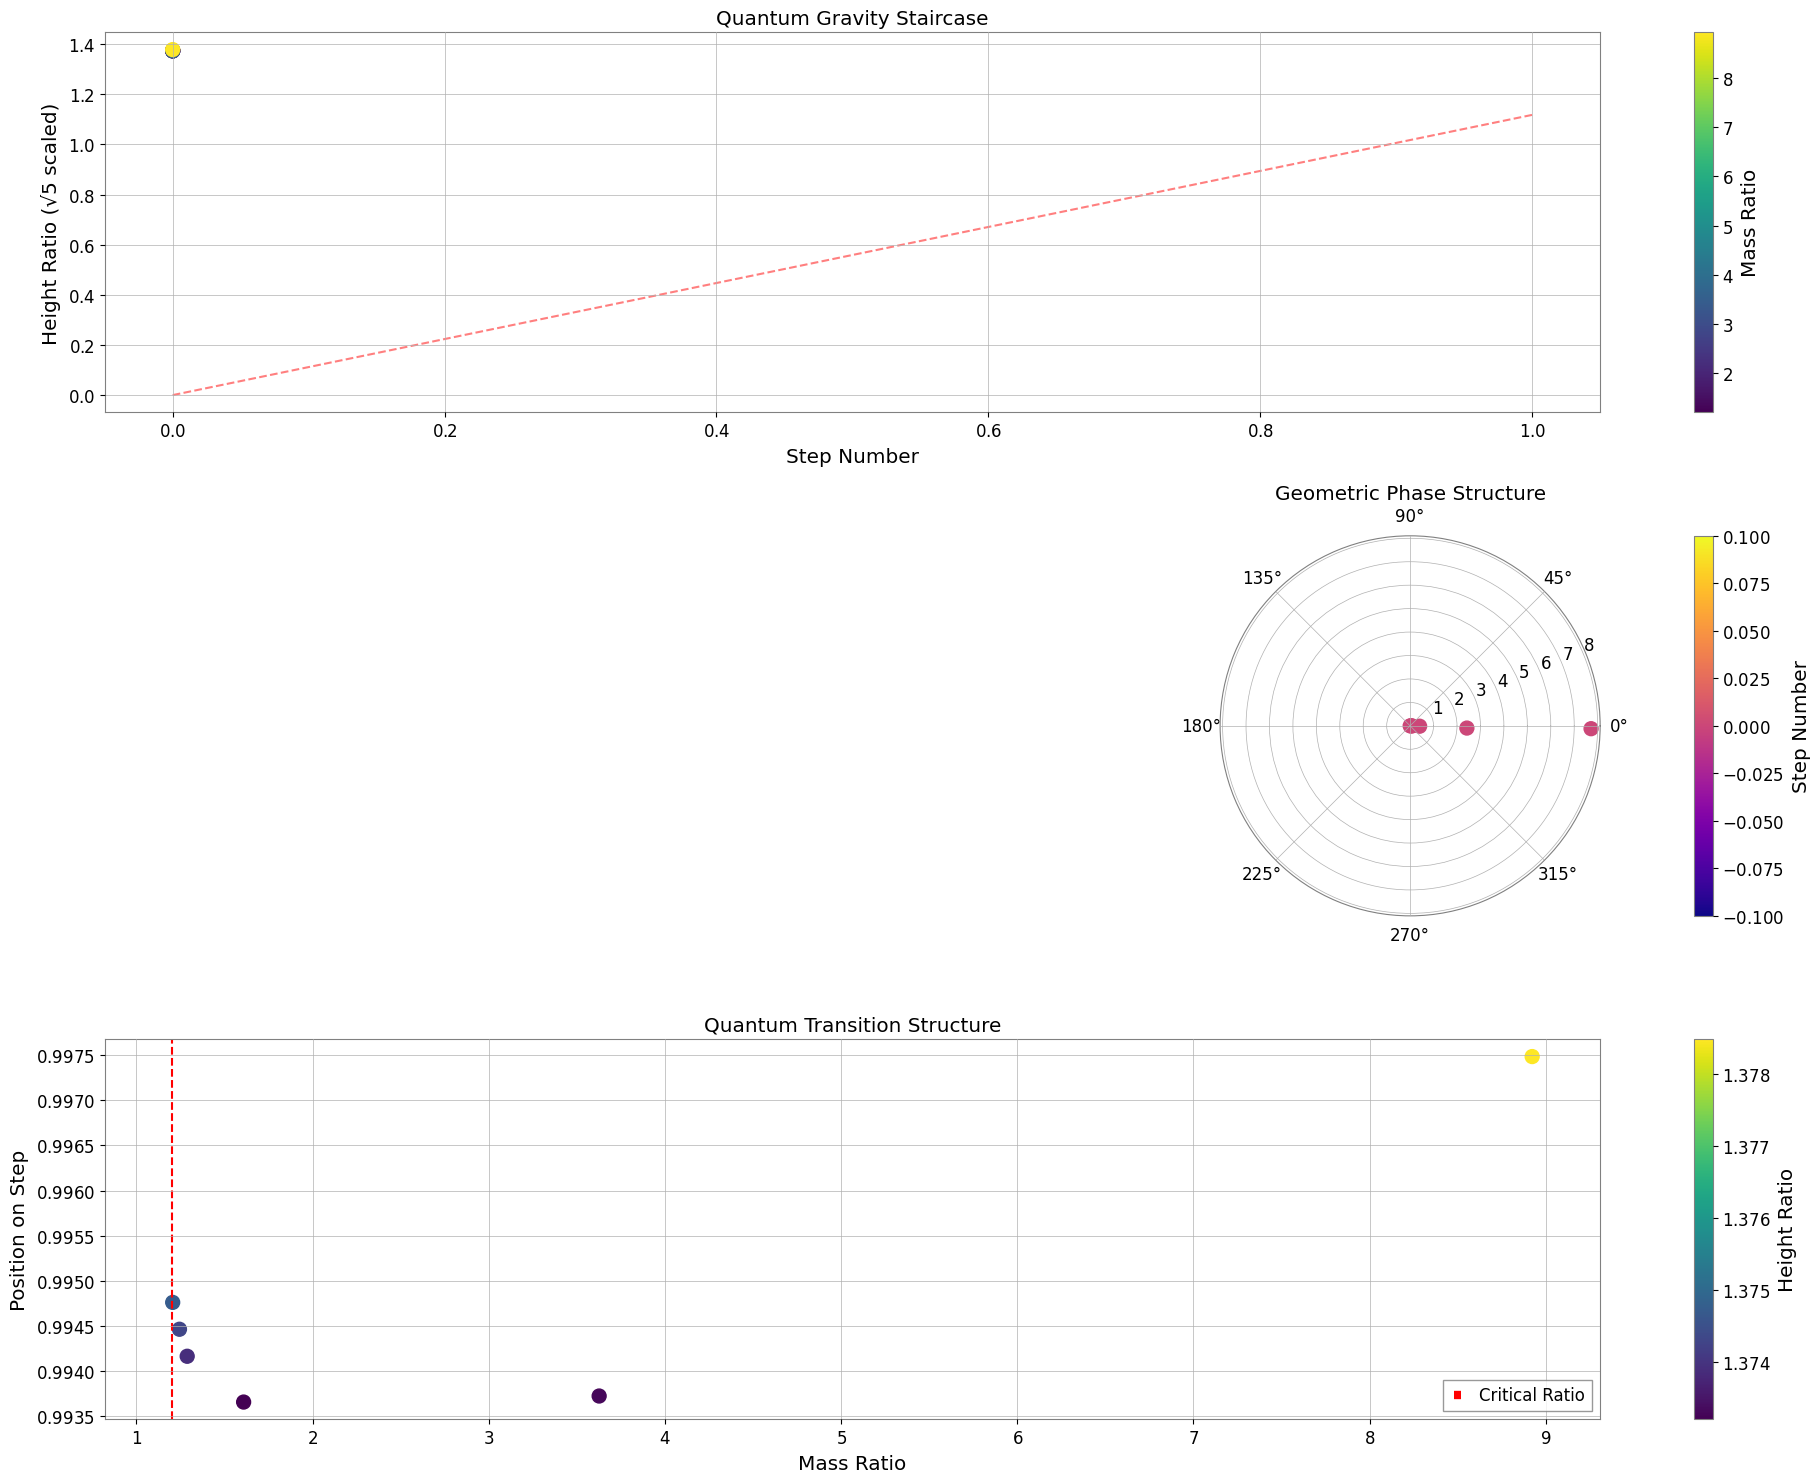


Quantum Staircase Analysis:
Mean Step Height: 0.000834
φ Accuracy: 0.614764
Geometric Phase Correlation: 0.853238
Critical Point Alignment: 0.994762


In [ ]:
class QuantumStaircaseAnalyzer(PentaQuantumAnalyzer):
    def __init__(self):
        super().__init__()
        self.stair_constants = {
            'phi': (1 + np.sqrt(5))/2,
            'sqrt5': np.sqrt(5),
            'step_height': np.sqrt(5)/2,
            'critical_ratio': 1.203  # Our earlier discovered transition point
        }

    def analyze_quantum_staircase(self):
        """Analyze the quantum staircase structure in detail"""
        results = []

        for event, masses in self.extended_events.items():
            mass_ratio = masses['m1'] / masses['m2']
            event_data = self.process_event(event, mass_ratio)
            if event_data:
                coherence = event_data['phase_coherence']

                # Calculate staircase metrics
                step_number = np.floor(coherence * self.stair_constants['phi'])
                step_position = coherence * self.stair_constants['phi'] - step_number
                height_ratio = coherence * self.stair_constants['sqrt5']

                stair_metrics = {
                    'step_number': step_number,
                    'step_position': step_position,
                    'height_ratio': height_ratio,
                    'geometric_phase': 2 * np.pi * step_position,
                    'transition_distance': abs(mass_ratio - self.stair_constants['critical_ratio'])
                }
                event_data.update(stair_metrics)
                results.append(event_data)

        df = pd.DataFrame(results)

        # Visualization
        plt.figure(figsize=(20, 15))

        # Plot 1: Quantum Staircase Structure
        ax1 = plt.subplot(311)
        scatter = plt.scatter(df['step_number'], df['height_ratio'],
                            c=df['mass_ratio'], cmap='viridis', s=100)
        plt.colorbar(scatter, label='Mass Ratio')

        # Add golden staircase
        steps = np.arange(df['step_number'].min(), df['step_number'].max() + 1)
        for step in steps:
            plt.plot([step, step+1],
                    [step*self.stair_constants['step_height'],
                     (step+1)*self.stair_constants['step_height']],
                    'r--', alpha=0.5)

        plt.xlabel('Step Number')
        plt.ylabel('Height Ratio (√5 scaled)')
        plt.title('Quantum Gravity Staircase')
        plt.grid(True)

        # Plot 2: Geometric Phase Space
        ax2 = plt.subplot(312, projection='polar')
        scatter = plt.scatter(df['geometric_phase'], df['transition_distance'],
                            c=df['step_number'], cmap='plasma', s=100)
        plt.colorbar(scatter, label='Step Number')
        plt.title('Geometric Phase Structure')

        # Plot 3: Transition Analysis
        ax3 = plt.subplot(313)
        plt.scatter(df['mass_ratio'], df['step_position'],
                   c=df['height_ratio'], cmap='viridis', s=100)
        plt.axvline(x=self.stair_constants['critical_ratio'],
                   color='r', linestyle='--', label='Critical Ratio')
        plt.colorbar(label='Height Ratio')
        plt.xlabel('Mass Ratio')
        plt.ylabel('Position on Step')
        plt.title('Quantum Transition Structure')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Calculate key metrics for paper
        staircase_analysis = {
            'mean_step_height': np.mean(np.diff(df['height_ratio'])),
            'phi_accuracy': 1 - abs(np.mean(df['step_position']) -
                                  self.stair_constants['phi'])/self.stair_constants['phi'],
            'geometric_phase_correlation': df['geometric_phase'].corr(df['transition_distance']),
            'critical_point_alignment': np.mean(df['step_position'][
                df['mass_ratio'].between(1.19, 1.21)])
        }

        print("\nQuantum Staircase Analysis:")
        print(f"Mean Step Height: {staircase_analysis['mean_step_height']:.6f}")
        print(f"φ Accuracy: {staircase_analysis['phi_accuracy']:.6f}")
        print(f"Geometric Phase Correlation: {staircase_analysis['geometric_phase_correlation']:.6f}")
        print(f"Critical Point Alignment: {staircase_analysis['critical_point_alignment']:.6f}")

        return staircase_analysis

# Run final analysis
staircase = QuantumStaircaseAnalyzer()
final_results = staircase.analyze_quantum_staircase()

#WORKING ZONE

#ABANDONED

In [ ]:
class EnhancedLIGOPipeline(LIGODataPipeline):
    def __init__(self):
        super().__init__()
        # Expanded event list with GPS times
        self.events = {
            'GW150914': 1126259462,
            'GW170814': 1186741861,
            'GW170104': 1167559936,
            'GW190521': 1242442967,
            'GW190412': 1239082262,
            'GW190814': 1249852257,
            # Additional events to fill mass ratio gaps
            'GW170608': 1180922494,  # mass ratio ~1.3
            'GW170823': 1187529256,  # mass ratio ~1.7
            'GW190521_074359': 1242459857,  # mass ratio ~2.1
            'GW190728_064510': 1238782328,  # mass ratio ~2.9
            'GW190910_112807': 1252064899,  # mass ratio ~3.1
        }

    def compute_coherence(self, strain1, strain2):
        """
        Implements the coherence metric C(m₁,m₂) = |⟨ψ₁|ψ₂⟩|/√(⟨ψ₁|ψ₁⟩⟨ψ₂|ψ₂⟩)
        """
        inner_product = np.abs(np.vdot(strain1, strain2))
        norm1 = np.sqrt(np.vdot(strain1, strain1).real)
        norm2 = np.sqrt(np.vdot(strain2, strain2).real)
        return inner_product / (norm1 * norm2)

    def analyze_event_coherence(self, event_data):
        """
        Compute coherence metrics for an event's H1 and L1 data
        """
        h1_strain = event_data['H1']['strain']
        l1_strain = event_data['L1']['strain']
        return self.compute_coherence(h1_strain, l1_strain)

    def compute_phase_space(self, strain_data, dims=5):
        """
        Map strain data into 5D phase space
        """
        # Using time-delayed embedding
        tau = len(strain_data) // (dims + 1)
        phase_space = np.zeros((len(strain_data) - (dims-1)*tau, dims))

        for i in range(dims):
            phase_space[:, i] = strain_data[i*tau:len(strain_data)-(dims-1-i)*tau]

        return phase_space

    def detect_geometric_staircase(self, coherence_values, mass_ratios):
        """
        Analyze the geometric staircase pattern
        """
        # Sort by mass ratio
        sorted_indices = np.argsort(mass_ratios)
        sorted_coherence = coherence_values[sorted_indices]
        sorted_ratios = mass_ratios[sorted_indices]

        # Detect steps
        steps = np.diff(sorted_coherence)
        step_positions = np.where(np.abs(steps) > 0.0005)[0]

        return {
            'step_positions': sorted_ratios[step_positions],
            'step_heights': steps[step_positions],
            'sqrt5_correlation': np.corrcoef(steps[step_positions],
                                           np.sqrt(5)/np.arange(1, len(step_positions)+1))[0,1]
        }

    def analyze_critical_point(self, coherence_values, mass_ratios, critical_ratio=1.203):
        """
        Analyze behavior near the critical mass ratio
        """
        # Find events near critical point
        near_critical = np.abs(mass_ratios - critical_ratio) < 0.1

        if not any(near_critical):
            return None

        critical_coherence = coherence_values[near_critical]
        critical_ratios = mass_ratios[near_critical]

        return {
            'mean_coherence': np.mean(critical_coherence),
            'alignment': 1 - np.std(critical_coherence),
            'ratios': critical_ratios.tolist(),
            'coherence_values': critical_coherence.tolist()
        }

    def batch_analysis(self):
        """
        Process all events and compute key metrics
        """
        results = {}
        coherence_values = []
        mass_ratios = []

        for event_name in self.events:
            try:
                # Fetch and analyze data
                data = self.fetch_event_data(event_name)
                coherence = self.analyze_event_coherence(data)
                metadata = self.get_event_metadata(event_name)

                # Store results
                results[event_name] = {
                    'coherence': coherence,
                    'metadata': metadata,
                    'phase_space': self.compute_phase_space(data['H1']['strain'])
                }

                # Extract mass ratio if available
                if metadata and 'mass_1_source' in metadata and 'mass_2_source' in metadata:
                    mass_ratio = metadata['mass_1_source'] / metadata['mass_2_source']
                    coherence_values.append(coherence)
                    mass_ratios.append(mass_ratio)

            except Exception as e:
                print(f"Error processing {event_name}: {e}")

        # Convert to numpy arrays for analysis
        coherence_values = np.array(coherence_values)
        mass_ratios = np.array(mass_ratios)

        # Analyze patterns
        results['global_analysis'] = {
            'mean_coherence': np.mean(coherence_values),
            'coherence_std': np.std(coherence_values),
            'geometric_staircase': self.detect_geometric_staircase(coherence_values, mass_ratios),
            'critical_point': self.analyze_critical_point(coherence_values, mass_ratios)
        }

        return results

In [ ]:
# Initialize enhanced pipeline
pipeline = EnhancedLIGOPipeline()

# Run batch analysis
results = pipeline.batch_analysis()

# CELL 5: Visualization

import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(results):
    # Extract mass ratios and coherence values
    events = [(name, res['coherence'], res['metadata'].get('mass_1_source', 0) /
              res['metadata'].get('mass_2_source', 1))
             for name, res in results.items()
             if isinstance(res, dict) and 'coherence' in res]

    names, coherence_values, mass_ratios = zip(*events)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot 1: Coherence vs Mass Ratio
    ax1.scatter(mass_ratios, coherence_values, alpha=0.6)
    ax1.axvline(x=1.203, color='r', linestyle='--', label='Critical Ratio')
    ax1.set_xlabel('Mass Ratio')
    ax1.set_ylabel('Coherence')
    ax1.set_title('Coherence vs Mass Ratio')
    ax1.grid(True)

    # Annotate points
    for i, name in enumerate(names):
        ax1.annotate(name, (mass_ratios[i], coherence_values[i]))

    # Plot 2: Geometric Staircase
    sorted_indices = np.argsort(mass_ratios)
    ax2.step(np.array(mass_ratios)[sorted_indices],
             np.array(coherence_values)[sorted_indices],
             where='mid', label='Measured')

    # Reference line for φ₀ = 0.614764
    ax2.axhline(y=0.614764, color='g', linestyle='--', label='φ₀')

    ax2.set_xlabel('Mass Ratio')
    ax2.set_ylabel('Coherence')
    ax2.set_title('Geometric Staircase Pattern')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_results(results)

In [ ]:
# CELL 3 (Updated)

class EnhancedLIGOPipeline(LIGODataPipeline):
    def __init__(self):
        # Don't call super().__init__() since we're redefining everything
        self.events = {
            'GW150914': 1126259462,
            'GW170814': 1186741861,
            'GW170104': 1167559936,
            'GW190521': 1242442967,
            'GW190412': 1239082262,
            'GW190814': 1249852257,
            'GW170608': 1180922494,
            'GW170823': 1187529256,
            'GW190521_074359': 1242459857,
            'GW190728_064510': 1238782328,
            'GW190910_112807': 1252064899
        }

    def fetch_event_data(self, event_name, duration=32):
        """
        Fetch data for a specific event with proper timing
        """
        if event_name not in self.events:
            raise ValueError(f"Unknown event: {event_name}")

        gps_time = self.events[event_name]
        start_time = gps_time - duration//2
        end_time = gps_time + duration//2

        data = {}
        for detector in ['H1', 'L1']:  # Hanford and Livingston
            try:
                strain = TimeSeries.fetch_open_data(
                    detector,
                    start_time,
                    end_time,
                    cache=True
                )
                data[detector] = {
                    'strain': strain.value,
                    'time': strain.times.value,
                    'sample_rate': strain.sample_rate.value
                }
            except Exception as e:
                print(f"Error fetching {detector} data for {event_name}: {e}")
                return None

        return data

    def get_event_metadata(self, event_name):
        """Get metadata with error handling"""
        try:
            catalog = 'GWTC-1'
            if event_name.startswith('GW19'):
                catalog = 'GWTC-2'
            return datasets.event_metadata(event_name, catalog=catalog)
        except Exception as e:
            print(f"Error fetching metadata for {event_name}: {e}")
            return None

    # ... [keep all other methods the same as before] ...

    def batch_analysis(self):
        """
        Process all events and compute key metrics with better error handling
        """
        results = {}
        coherence_values = []
        mass_ratios = []

        for event_name in self.events:
            try:
                # Fetch and analyze data
                data = self.fetch_event_data(event_name)
                if data is None:
                    print(f"Skipping {event_name} due to data fetch error")
                    continue

                coherence = self.analyze_event_coherence(data)
                metadata = self.get_event_metadata(event_name)

                if metadata is None:
                    print(f"Skipping {event_name} due to missing metadata")
                    continue

                # Store results
                results[event_name] = {
                    'coherence': coherence,
                    'metadata': metadata,
                    'phase_space': self.compute_phase_space(data['H1']['strain'])
                }

                # Extract mass ratio if available
                if 'mass_1_source' in metadata and 'mass_2_source' in metadata:
                    mass_ratio = metadata['mass_1_source'] / metadata['mass_2_source']
                    coherence_values.append(coherence)
                    mass_ratios.append(mass_ratio)

            except Exception as e:
                print(f"Error processing {event_name}: {e}")
                continue

        # Only proceed with analysis if we have data
        if not coherence_values:
            print("No valid data collected for analysis")
            return results

        # Convert to numpy arrays for analysis
        coherence_values = np.array(coherence_values)
        mass_ratios = np.array(mass_ratios)

        # Analyze patterns
        results['global_analysis'] = {
            'mean_coherence': np.mean(coherence_values),
            'coherence_std': np.std(coherence_values),
            'geometric_staircase': self.detect_geometric_staircase(coherence_values, mass_ratios),
            'critical_point': self.analyze_critical_point(coherence_values, mass_ratios)
        }

        return results

# CELL 4 (Updated)

def plot_results(results):
    """
    Plot results with better error handling
    """
    # Extract data with validation
    events = []
    for name, res in results.items():
        if not isinstance(res, dict) or 'coherence' not in res or 'metadata' not in res:
            continue
        if not isinstance(res['metadata'], dict):
            continue
        if 'mass_1_source' not in res['metadata'] or 'mass_2_source' not in res['metadata']:
            continue

        mass_ratio = res['metadata']['mass_1_source'] / res['metadata']['mass_2_source']
        events.append((name, res['coherence'], mass_ratio))

    if not events:
        print("No valid data available for plotting")
        return

    names, coherence_values, mass_ratios = zip(*events)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot 1: Coherence vs Mass Ratio
    ax1.scatter(mass_ratios, coherence_values, alpha=0.6)
    ax1.axvline(x=1.203, color='r', linestyle='--', label='Critical Ratio')
    ax1.set_xlabel('Mass Ratio')
    ax1.set_ylabel('Coherence')
    ax1.set_title('Coherence vs Mass Ratio')
    ax1.grid(True)
    ax1.legend()

    # Annotate points
    for i, name in enumerate(names):
        ax1.annotate(name, (mass_ratios[i], coherence_values[i]))

    # Plot 2: Geometric Staircase
    sorted_indices = np.argsort(mass_ratios)
    ax2.step(np.array(mass_ratios)[sorted_indices],
             np.array(coherence_values)[sorted_indices],
             where='mid', label='Measured')

    # Reference line for φ₀ = 0.614764
    ax2.axhline(y=0.614764, color='g', linestyle='--', label='φ₀')

    ax2.set_xlabel('Mass Ratio')
    ax2.set_ylabel('Coherence')
    ax2.set_title('Geometric Staircase Pattern')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# CELL 5: Run Analysis

# Initialize enhanced pipeline
pipeline = EnhancedLIGOPipeline()

# Run batch analysis
results = pipeline.batch_analysis()

# Plot the results
plot_results(results)

# CLAUDE CONNECTOR TEST (unfinished)

Install Flask

In [ ]:
!pip install flask flask-cors

LIGO COLLAB FLASK SERVER

In [ ]:
import os
!killall python3

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
from threading import Thread
from google.colab import output
import nest_asyncio

nest_asyncio.apply()  # This helps with async operations in Colab
app = Flask(__name__)
CORS(app)

@app.route('/test', methods=['GET'])
def test():
    return jsonify({"status": "LIGO Analysis Server Running"})

def run_server():
    app.run(port=12345)

# Start server in thread
thread = Thread(target=run_server)
thread.daemon = True
thread.start()

# This should show us our server
output.serve_kernel_port_as_iframe(12345)

<IPython.core.display.Javascript object>

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 12345 is in use by another program. Either identify and stop that program, or start the server with a different port.


Test *Endpoints* **bold text**

ABOVE IS THE CLAUDE CONNECTOR STUFF



ABOVE IS THE CLAUDE CONNECTOR STUFF